*09 / 03 / 2021 - Matheus Coutsiers, Benoit Maizi, Victor Saillant, Geoffrey Saunois*

*This notebook stands as the leading line of the project, around which other utility codes ar being imported. Comments, remarks and critics have been formulated all along the notebook to point out the critical points of the work. Feel free to contact us for more details. This work takes inspiration of Magenta Team (Google) project 'a Music VAE'.*

-----

# Music VAE

*The idea of this project is to train a Variational Auto-Encoder on a music dataset. Like if it was done on a "canonical" dataset such as MNIST, we will next be able to use this trained structure to generate musics. However the objective of this work is different. The goal is to perform a continuous transformation from a song to another. It is often shown in computer vision, with faces of a person being continously transform into other faces, or with MNIST where we can obtain a morphose of a number to another one. Such a tool would for example allow a DJ or a music broadcast systeme to perform smoot transitions.*
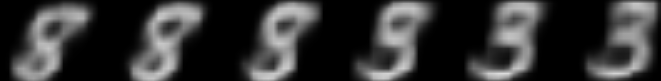

## 1. Dataset

### 1.1 Extract tracks from MIDI files

*What is music in terms of data ? It can be an MP3, WAV file containing the signal corresponding to the sound to emit. For this problem, it turns out that another type of data can be used : MIDI files. MIDI files contains all the informations about the music : temporality of notes, intensity, the different tracks, their corresponding instruments, lyrics. They are less big in terms of memory and thus more keen to be used for training an architecture. The only missing information compared to the first type of numerized music is the exact sound of each instrument. This is, in fact, not a issue for this work's objective : we will perform a continous transformation from a melody to another, the tone of the instrument can then be added to the MIDI file or by using a software such as Ableton of FLStudio.*

In [1]:
from _utils import *
from _preprocessing import *
%matplotlib nbagg
%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))
sys.path.insert(0, '../src/')
warnings.filterwarnings("ignore")

In [2]:
data_path = "data"  # path to data we want to use
midi_files = glob.glob(os.path.join(data_path, "**/*.mid"), recursive=True)  # list all mid files in data

saved_columns = [pretty_midi.note_number_to_name(n) for n in range(48,108)]
piano_rolls = pd.DataFrame(columns=['piano_roll_name', 'timestep'] + saved_columns)
piano_rolls = piano_rolls.set_index(['piano_roll_name', 'timestep'])

In [ ]:
preprocessor = Preprocessing(midi_files)
preprocessor.list_of_all_the_instruments(limit=-1)
preprocessor.most_common_instruments()
preprocessor.keep_only_piano_tracks()

file 331/116188: Loading and parsing 875d3d058033ff1b47f377f47d0fe2eb.mid


### 1.2 Turn MIDI tracks to CSV

*In this work, we choose to work on piano rolls formatted data : a table with the set of playable notes is created, filled with 0 and 1 where 0 correspond to blank and unplayed notes and 1 represent the current played note a time t. To store those piano rolls, we build a CSV that concatenate the melodies of all the different songs in the dataset. The following line of code is a big wrapper performing all chop/cut/formatting steps. It takes a huge amount of time to transform files and has been one of the limitation to this study's performances.*

In [ ]:
preprocessor.write_all_tracks_into_csv()

## 2. Model definition

### 2.1 Loading data

*A dataloader is built to process the data with a model. Each midi file that has been converted into a csv is split into several sequence that should last about 30 secondes, having 256 notes : 16 bars, each containing 16 notes. The work here had about 200 songs in MIDI format that have been transposed into CSV piano rolls. It thus leads us to a dataset of short-sequence songs of 773 samples. The dataset is split into the classical train/test scheme so we can perform model learning.*

In [18]:
from midi_builder import MidiBuilder
builder = MidiBuilder()

cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NOTESPERBAR=16 #total notes in one bar
totalbars=16 #total bars as input 
NUM_PITCHES=60+1 # all possible notes to play +1 for silences
TOTAL_NOTES=NOTESPERBAR*totalbars
num_features=NUM_PITCHES #size of input feature vector
batch_size = 64 #actual batchsize
TEACHER_FORCING=True #not used but it will be needed
random_seed = 42
test_split = .2
shuffle = True
if random_seed is not None:
    np.random.seed(random_seed)

In [19]:
transform = BarTransform(bars=totalbars, note_count=NUM_PITCHES)#configures number of input bars
midi_dataset = MidiDataset(csv_file='piano_rolls.csv', transform = transform) #imports dataset

dataset_size = len(midi_dataset)           #number of musics on dataset
test_size = int(test_split * dataset_size) #test size length
train_size = dataset_size - test_size      #train data length

train_dataset, test_dataset = random_split(midi_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=4)#, sampler=train_sampler)
test_loader = DataLoader(test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=4)#, sampler=test_sampler)
print("Train size: {}, Test size: {}".format(train_size, test_size))

Train size: 699, Test size: 174


### 2.2 loading the model

*The model is define in the overwritten class VariationalAutoencoder below. Its initialization and its forward function are implemented in this class. As a future work, it would be more convenient to introduce new function as encoding and decoding so the VAE could be easily manipulated with fewer lines of code. One important point in this forward function is the use of teacher_forcing process. As the model is learning how to reproduce a sequence, it learns notes after notes. However, during the learning process, the model is not good yet and first few notes might be the beginning of errors that are going to be propagated all along the sequence : the error is amplified along the sequence and the model quickly become less accurate for longer audio. The teacher_forcing allows a recall of what a note a time t should be so the model can know at few times along the sequence if it is far from the expected melody at this time of the song, and continue the rest of the sequence starting from the right note. In brief, it is a way to supervise the learning during the sequence.*

In [20]:
# define size variables
input_size = NUM_PITCHES
enc_hidden_size=256 #hidden size of encoder
conductor_hidden_size=256 #hidden size of decoder
decoders_hidden_size=64 #hidden size of decoder
decoders_initial_size=32 #decoder input size
n_layers_conductor=2 #not being used rn cuz number of layers is incorrect
n_layers_decoder=3 #not being used rn cuz number of layers is incorrect
latent_features=64 #latent space dimension
sequence_length = 16 #notes per decoder
dropout_rate = 0.2

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features,teacher_forcing, eps_i):
        super(VariationalAutoencoder, self).__init__()
        self.teacher_forcing = teacher_forcing
        self.eps_i = eps_i
        self.latent_features = latent_features
        #data goes into bidirectional encoder
        self.encoder = torch.nn.LSTM(
                batch_first = True,
                input_size = input_size,
                hidden_size = enc_hidden_size,
                num_layers = 1,
                bidirectional = True)
        #encoded data goes onto connect linear layer. inputs must be*2 because LSTM is bidirectional
        #output must be 2*latentspace because it needs to be split into miu and sigma right after.
        self.encoderOut = nn.Linear(in_features=enc_hidden_size*2, out_features=latent_features*2)
        #after being converted data goes through a fully connected layer
        self.linear_z = nn.Linear(in_features=latent_features, out_features=decoders_initial_size)
        self.dropout= nn.Dropout(p=dropout_rate)
        self.worddropout = nn.Dropout2d(p=dropout_rate)
        # Define the conductor and note decoder
        self.conductor = nn.LSTM(decoders_initial_size, decoders_initial_size, num_layers=1,batch_first=True)
        self.decoder = nn.LSTM(NUM_PITCHES+decoders_initial_size, decoders_initial_size, num_layers=1,batch_first=True)
        # Linear note to note type (classes/pitches)
        self.linear = nn.Linear(decoders_initial_size, NUM_PITCHES)

        
    #used to initialize the hidden layer of the encoder to zero before every batch
    def init_hidden(self, batch_size):
        #must be 2 x batch x hidden_size because its a bi-directional LSTM
        init = torch.zeros(2, batch_size, enc_hidden_size, device=device)
        c0 = torch.zeros(2, batch_size, enc_hidden_size, device=device)
        #2 because has 2 layers
        #n_layers_conductor
        init_conductor = torch.zeros(1, batch_size, decoders_initial_size, device=device)
        c_condunctor = torch.zeros(1, batch_size, decoders_initial_size, device=device)
        return init,c0,init_conductor,c_condunctor

    # Coin toss to determine whether to use teacher forcing on a note(Scheduled sampling)
    # Will always be True for eps_i = 1.
    def use_teacher_forcing(self):
        with torch.no_grad():
            tf = np.random.rand(1)[0] <= self.eps_i
        return tf
    
    def set_scheduled_sampling(self, eps_i):
        self.eps_i = eps_i

    def forward(self, x):
        batch_size = x.size(0)
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)
        the_input = torch.cat([note,x],dim=1)
        outputs = {}
        #creates hidden layer values
        h0,c0,hconductor,cconductor = self.init_hidden(batch_size)
        x = self.worddropout(x)
        #resets encoder at the beginning of every batch and gives it x
        x, hidden = self.encoder(x, ( h0,c0))
        #goes from 4096 to 1024
        x = self.encoderOut(x)      
        #x=self.dropout(x)
        # Split encoder outputs into a mean and variance vector 
        mu, log_var = torch.chunk(x, 2, dim=-1)
        # Make sure that the log variance is positive
        log_var = softplus(log_var)
        # Reparametrisation trick
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, 1, self.latent_features)
            if cuda:
                epsilon = epsilon.cuda()
        # setting sigma
        sigma = torch.exp(log_var*2)
        # generate z - latent space
        z = mu + epsilon * sigma
        # decrease space
        z = self.linear_z(z)
        # decoder part **
        conductor_hidden = (hconductor,cconductor)
        counter=0
        notes = torch.zeros(batch_size,TOTAL_NOTES,NUM_PITCHES,device=device)
        # For the first timestep the note is the embedding
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)
        # Go through each element in the latent sequence
        for i in range(16):
            embedding, conductor_hidden = self.conductor(z[:,i,:].view(batch_size,1, -1), conductor_hidden)    
            if self.use_teacher_forcing():
                 # Reset the decoder state of each 16 bar sequence
                decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))
                embedding = embedding.expand(batch_size, NOTESPERBAR, embedding.shape[2])
                e = torch.cat([embedding,the_input[:,range(i*16,i*16+16),:]],dim=-1)
                notes2, decoder_hidden = self.decoder(e, decoder_hidden)
                aux = self.linear(notes2)
                aux = torch.softmax(aux, dim=2);
                # generates 16 notes per batch at a time
                notes[:,range(i*16,i*16+16),:]=aux;
            else:           
                 # Reset the decoder state of each 16 bar sequence
                decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))
                for _ in range(sequence_length):
                    # Concat embedding with previous note
                    e = torch.cat([embedding, note], dim=-1)
                    e = e.view(batch_size, 1, -1)
                    # Generate a single note (for each batch)
                    note, decoder_hidden = self.decoder(e, decoder_hidden)
                    aux = self.linear(note)
                    aux = torch.softmax(aux, dim=2);
                    notes[:,counter,:]=aux.squeeze();
                    note=aux
                    counter=counter+1
        outputs["x_hat"] = notes
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        return outputs
    
    def MyDecoder1(self, z_2_melodies, x):
        batch_size = 1
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)
        outputs = {}
        #creates hidden layer values
        h0,c0,hconductor,cconductor = self.init_hidden(batch_size)
        conductor_hidden = (hconductor,cconductor)
        counter=0
        notes = torch.zeros(batch_size,TOTAL_NOTES,NUM_PITCHES,device=device)
        # For the first timestep the note is the embedding
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)
        for i in range(16):
            p = np.random.binomial(1,i/16)
            x_random = x[0]*(1-p)+x[1]*p
            x_random = x_random.reshape(1,x_random.shape[0], x_random.shape[1])
            the_input = torch.cat([note,x_random],dim=1)
            z = z_2_melodies[0]
            z = z.reshape(1,z.shape[0], z.shape[1])
            embedding, conductor_hidden = self.conductor(z[:,i,:].view(batch_size,1, -1), conductor_hidden)  
            embedding = embedding.expand(batch_size, NOTESPERBAR, embedding.shape[2])
            decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))
            for _ in range(sequence_length):
                e = torch.cat([embedding,the_input[:,range(i*16,i*16+16),:]],dim=-1)
                note2, decoder_hidden = self.decoder(e, decoder_hidden)
                aux = self.linear(note2)
                aux = torch.softmax(aux, dim=2);
                notes[:,range(i*16,i*16+16),:]=aux;
        outputs["x_hat"] = notes
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        return outputs
    
    def MyDecoder2(self, z_2_melodies, x):
        batch_size = 1
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)
        outputs = {}
        #creates hidden layer values
        h0,c0,hconductor,cconductor = self.init_hidden(batch_size)
        conductor_hidden = (hconductor,cconductor)
        counter=0
        notes = torch.zeros(batch_size,TOTAL_NOTES,NUM_PITCHES,device=device)
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)
        for i in range(16):
            p = np.random.binomial(1,i/16)
            x_random = x[0]*(1-p)+x[1]*p
            x_random = x_random.reshape(1,x_random.shape[0], x_random.shape[1])
            the_input = torch.cat([note,x_random],dim=1)
            z = z_2_melodies[1]*i/15 + z_2_melodies[0]*(1-i/15)
            z = z.reshape(1,z.shape[0], z.shape[1])
            embedding, conductor_hidden = self.conductor(z[:,i,:].view(batch_size,1, -1), conductor_hidden)  
            embedding = embedding.expand(batch_size, NOTESPERBAR, embedding.shape[2])

            decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))
            for _ in range(sequence_length):
                e = torch.cat([embedding,the_input[:,range(i*16,i*16+16),:]],dim=-1)
                note2, decoder_hidden = self.decoder(e, decoder_hidden)
                aux = self.linear(note2)
                aux = torch.softmax(aux, dim=2);
                notes[:,range(i*16,i*16+16),:]=aux;
        outputs["x_hat"] = notes
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        return outputs
    
    def MyDecoder3(self, z_2_melodies):
        batch_size = 1
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)
        outputs = {}
        h0,c0,hconductor,cconductor = self.init_hidden(batch_size)
        conductor_hidden = (hconductor,cconductor)
        counter=0
        notes = torch.zeros(batch_size,TOTAL_NOTES,NUM_PITCHES,device=device)
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)
        for i in range(16):
            z = z_2_melodies[1]*i/15 + z_2_melodies[0]*(1-i/15)
            z = z.reshape(1,z.shape[0], z.shape[1])
            embedding, conductor_hidden = self.conductor(z[:,i,:].view(batch_size,1, -1), conductor_hidden)
            decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))
            for _ in range(sequence_length):
                e = torch.cat([embedding, note], dim=-1)
                e = e.view(batch_size, 1, -1)
                note, decoder_hidden = self.decoder(e, decoder_hidden)
                aux = self.linear(note)
                aux = torch.softmax(aux, dim=2);
                notes[:,counter,:]=aux.squeeze();
                note=aux
                counter=counter+1
                notes[:,range(i*16,i*16+16),:]=aux;
        outputs["x_hat"] = notes
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        return outputs
        
net = VariationalAutoencoder(latent_features, TEACHER_FORCING, eps_i = 1)
if cuda:  # Transfer model to GPU if available
    net = net.cuda()
print(net)

VariationalAutoencoder(
  (encoder): LSTM(61, 256, batch_first=True, bidirectional=True)
  (encoderOut): Linear(in_features=512, out_features=128, bias=True)
  (linear_z): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (worddropout): Dropout2d(p=0.2, inplace=False)
  (conductor): LSTM(32, 32, batch_first=True)
  (decoder): LSTM(93, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=61, bias=True)
)


### 2.3 Defining our loss

In [21]:
#directly taken from notebook
def ELBO_loss(y, t, mu, log_var, weight):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)
    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    sigma = torch.exp(log_var*2)
    n_mu = torch.Tensor([0])
    n_sigma = torch.Tensor([1])
    if cuda:
        n_mu = n_mu.cuda()
        n_sigma = n_sigma.cuda()
    p = Normal(n_mu, n_sigma)
    q = Normal(mu, sigma)
    #The method signature is P and Q, but might need to be reversed to calculate divergence of Q with respect to P
    kl_div = kl_divergence(q, p)
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    #kl = -weight * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=(1,2))
    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - (weight*torch.mean(kl_div)) # add a weight to the kl using warmup
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl_div.mean(),weight*kl_div.mean() # mean instead of sum

# The Adam optimizer works really well with VAEs
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

## 3.Training the model

### 3.1 Training

*The training of the variational autoencoder is performed during 100 epochs. The curves below shows a fast decreasing Kullback-Leibler distance and a loss that continue to decrease. This second phenomena could be anticipated as LSTM layers take a very long time to be trained, the learning could have been pushed for more epochs. The validation loss does not go up so that it can be assumed the data is not overfitted yet. Train and validation loss, as well as train and validation Kullback-Leibler loss are of same orders and similar.*

In [22]:
# 3 = ~12 minutes
#num_epochs = 200
#warmup_epochs= 90
#pre_warmup_epochs = 10
num_epochs = 100
warmup_epochs= 90
pre_warmup_epochs = 10
warmup_lerp = 1/warmup_epochs
if warmup_epochs > num_epochs - pre_warmup_epochs:
    warmup_epochs=num_epochs - pre_warmup_epochs
kl_w = 0
kls = []
for e in range(num_epochs):
    if e >= pre_warmup_epochs:
        kl_w = kl_w + warmup_lerp
        if kl_w > 1:
            kl_w=1.
    kls.append(kl_w)
est_time = 4*num_epochs

In [23]:
tmp_img = "tmp_vae_out.png"
scheduled_decay_rate = 40
warmup_w=0
eps_i = 1
use_scheduled_sampling = False
train_loss, valid_loss = [], []
train_kl, valid_kl,train_klw = [], [],[]

start = time.time()
print("Training epoch {}".format(0))
#epochs loop
for epoch in range(num_epochs):
    batch_loss, batch_kl,batch_klw = [], [],[]
    net.train()
    for i_batch, sample_batched in enumerate(train_loader):
        x = sample_batched['piano_rolls']
        x = x.type('torch.FloatTensor')
        x = Variable(x)
        x = x.to(device)
        
        ## Calc the sched sampling rate:
        if epoch >= pre_warmup_epochs and use_scheduled_sampling:
            eps_i = inv_sigmoid_decay(i_batch, rate=scheduled_decay_rate)

        net.set_scheduled_sampling(eps_i)
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        elbo, kl,kl_w = loss_function(x_hat, x, mu, log_var, warmup_w)
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()

        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())
        batch_klw.append(kl_w.item())
    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))
    train_klw.append(np.mean(batch_klw))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        # Just load a single batch from the test loader
        x = next(iter(test_loader))
        x = Variable(x['piano_rolls'].type('torch.FloatTensor'))
        x = x.to(device)
        net.set_scheduled_sampling(1.) # Please use teacher forcing for validations
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]
        elbo, kl,klw = loss_function(x_hat, x, mu, log_var, warmup_w)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())
        
    if epoch >= pre_warmup_epochs:
        warmup_w = warmup_w + warmup_lerp
        if warmup_w > 1:
            warmup_w=1.
    if epoch == 0:
        continue
            

    f, axarr = plt.subplots(2, 1, figsize=(10, 10))
    
    # Loss
    ax = axarr[0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    # KL / reconstruction
    ax = axarr[1]
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')
    ax.plot(np.arange(epoch+1), train_kl, color="black")
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
    ax.plot(np.arange(epoch+1), train_klw, color="blue", linestyle="--")
    ax.legend(['Training', 'Validation','Weighted'])
    print("Epoch: {}, {} seconds elapsed".format(epoch, time.time() - start))
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    clear_output(wait=True)
    os.remove(tmp_img)

end_time = time.time() - start
print("Finished. Time elapsed: {} seconds".format(end_time))

Finished. Time elapsed: 185.8066005706787 seconds


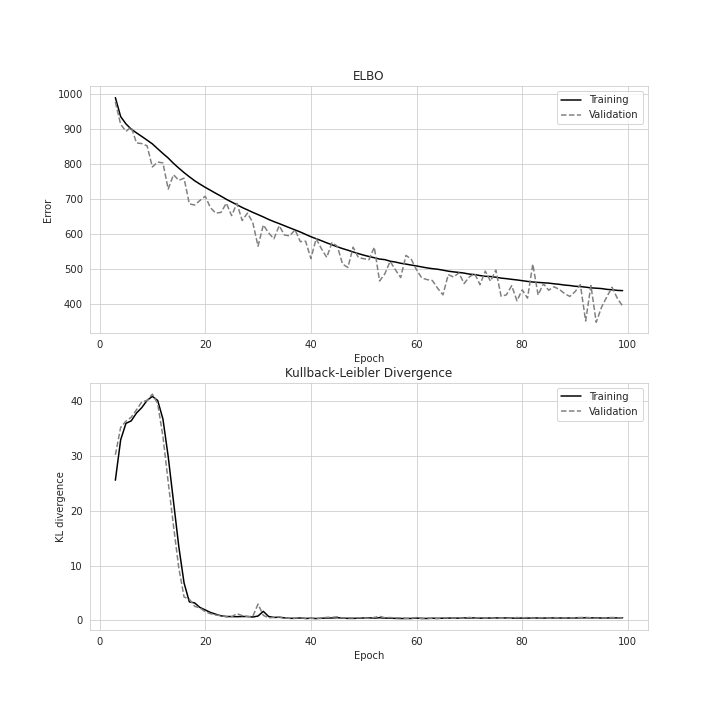

Time elapsed     : 185.8066005706787 seconds
Final KL. Train  : 0.4589581977237355, Validation: 0.4188249707221985
Final loss. Train: 438.8637778542259, Validation: 394.6295166015625


In [24]:
skip = 3
if not os.path.exists('midi'):
    os.makedirs('midi')
save_img = os.path.join("midi","kl_elbo.png")
if skip > num_epochs:
    print("Can't skip more than epochs run.")
    skip = 0
f, axarr = plt.subplots(2, 1, figsize=(10, 10))
    
# Loss
ax = axarr[0]
ax.set_title("ELBO")
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')
ax.plot(np.arange(skip, epoch+1), train_loss[skip:], color="black")
ax.plot(np.arange(skip, epoch+1), valid_loss[skip:], color="gray", linestyle="--")
ax.legend(['Training', 'Validation'])

# KL / reconstruction
ax = axarr[1]
ax.set_title("Kullback-Leibler Divergence")
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')
ax.plot(np.arange(skip, epoch+1), train_kl[skip:], color="black")
ax.plot(np.arange(skip, epoch+1), valid_kl[skip:], color="gray", linestyle="--")
ax.legend(['Training', 'Validation'])
plt.savefig(save_img)
plt.close(f)
display(Image(filename=save_img))

print("Time elapsed     : {} seconds".format(end_time))
print("Final KL. Train  : {}, Validation: {}".format(train_kl[-1], valid_kl[-1]))
print("Final loss. Train: {}, Validation: {}".format(train_loss[-1], valid_loss[-1]))

### 3.2 Show reconstructions and compare

*The reconstructed and originial melodies are plot bellow. This way, the quality of our variational autoencoder can be judge empirically. We can see that the reconstruction is quiet similar to the original for most melodies. Thus, even with a small amount of data we are able to perform good reconstruction of piano rolls. One can however have a critical point of view towards the reconstruction methode used. The teacher forcing parameter was set on so that the reconstruction is partially supervised : the sequence does not go to far from the original as its model reconstruction possess few random supervising timestep notes. It is avoid propagating the error but it is also giving a partially inaccurate reconstruction : it is a controlled reconstruction. A real free reconstruction with the parameter off give melodies that quickly diverge. It might be because of our lack of data and because of the to few amount of learning epochs.*

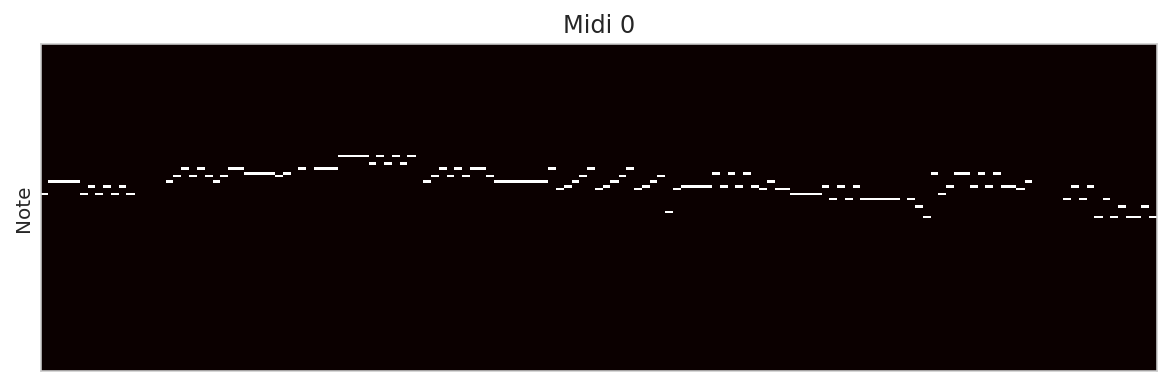

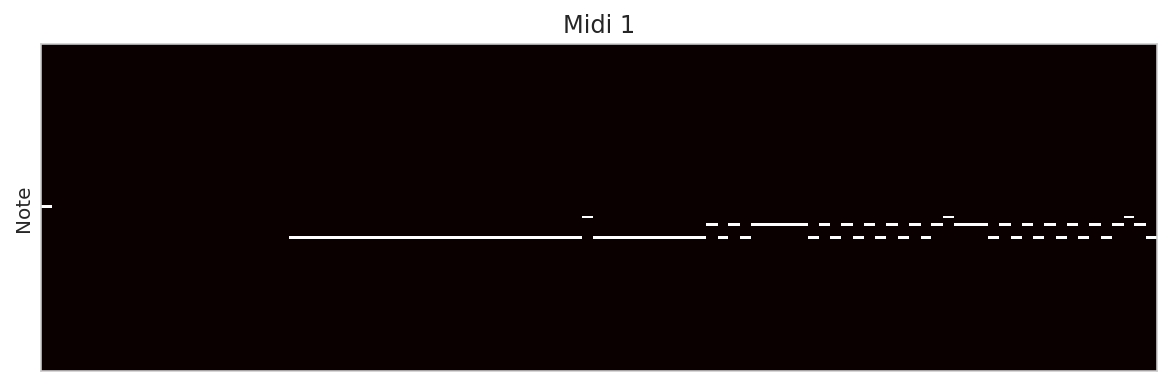

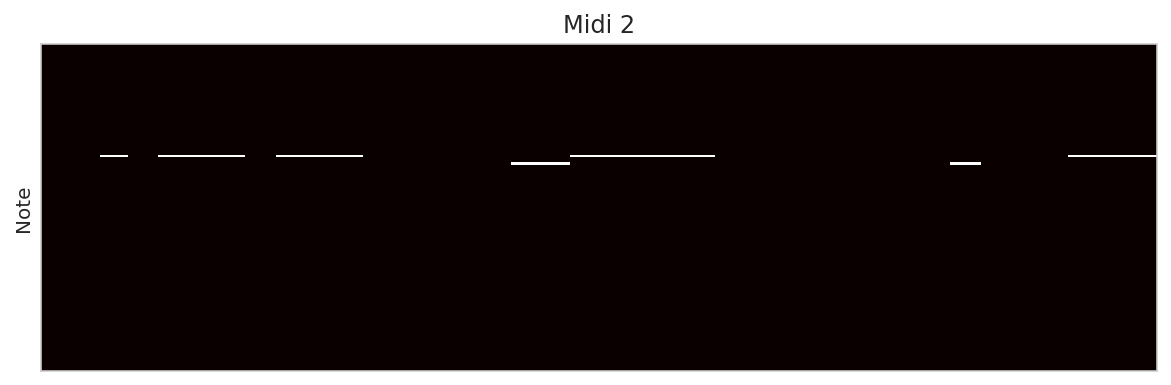

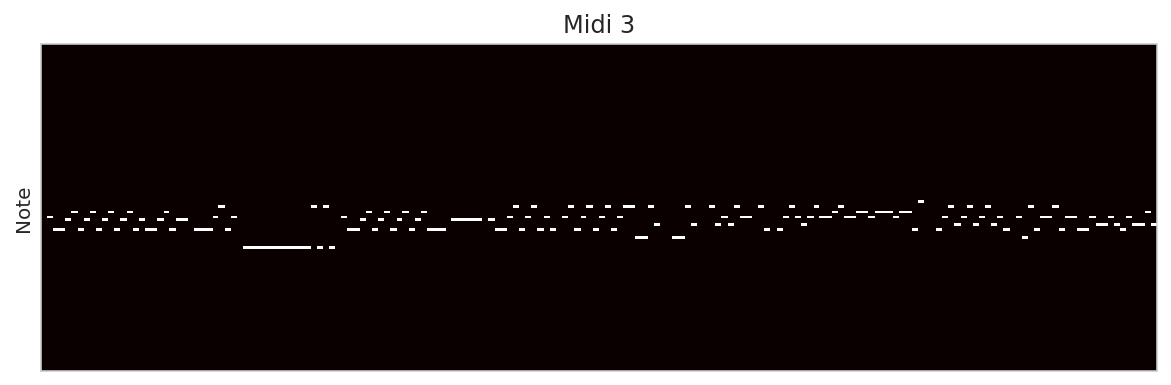

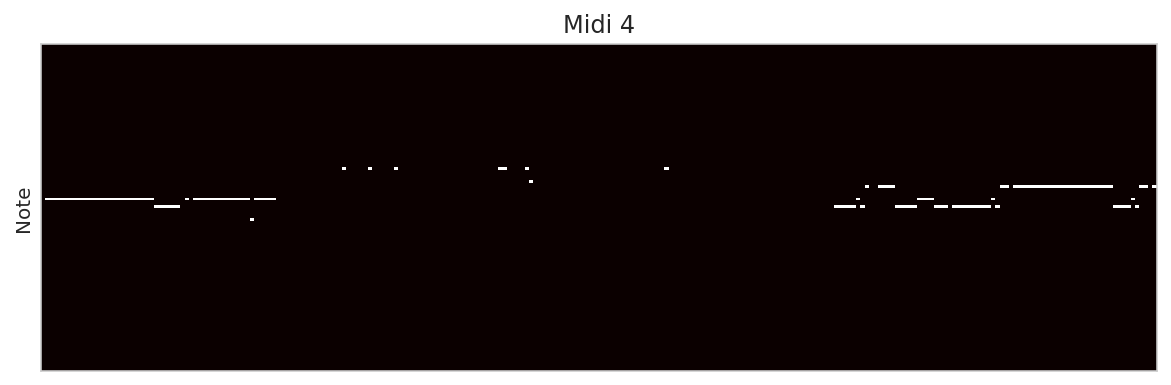

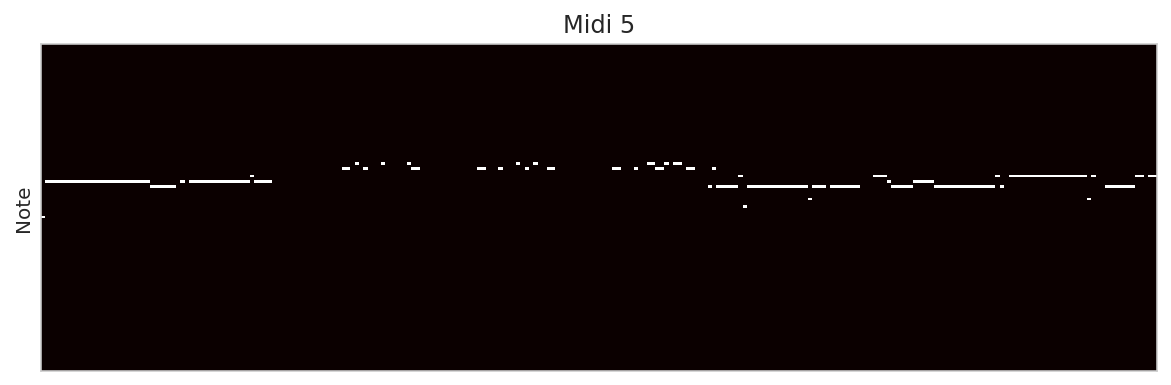

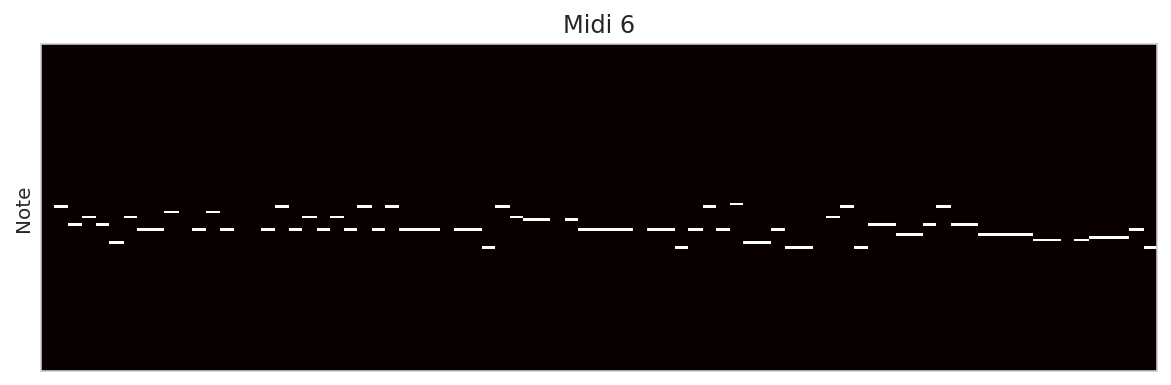

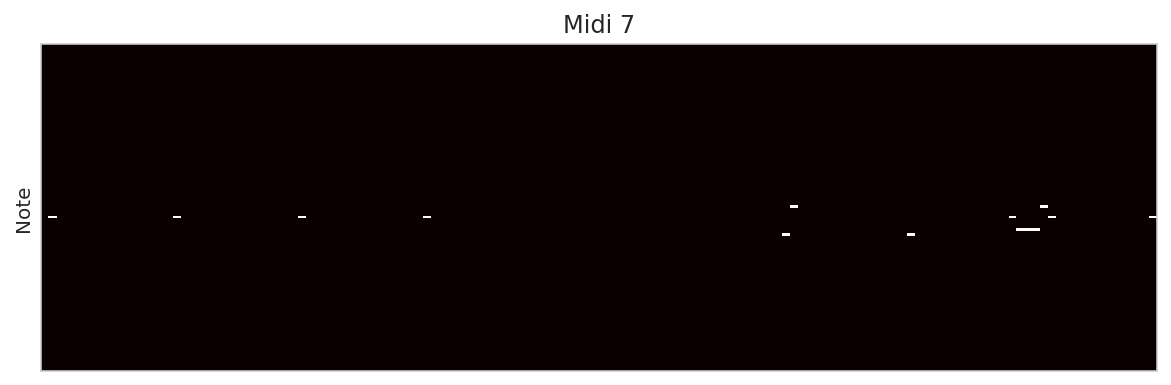

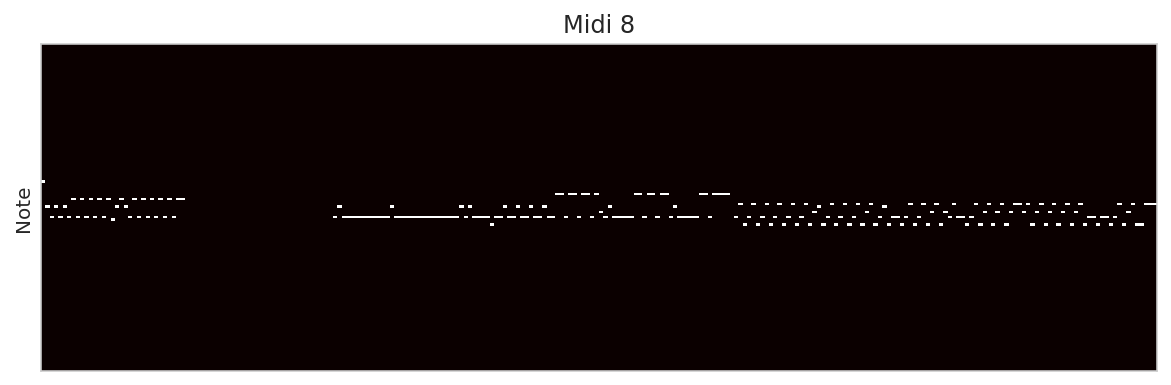

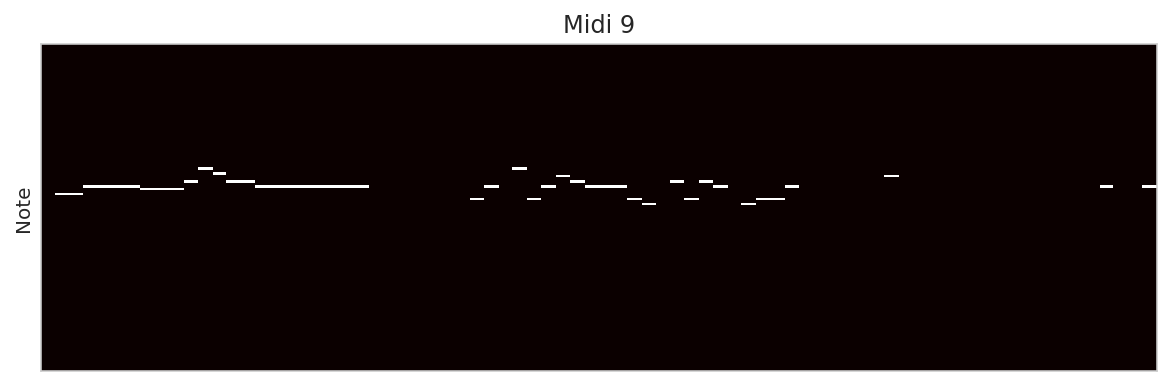

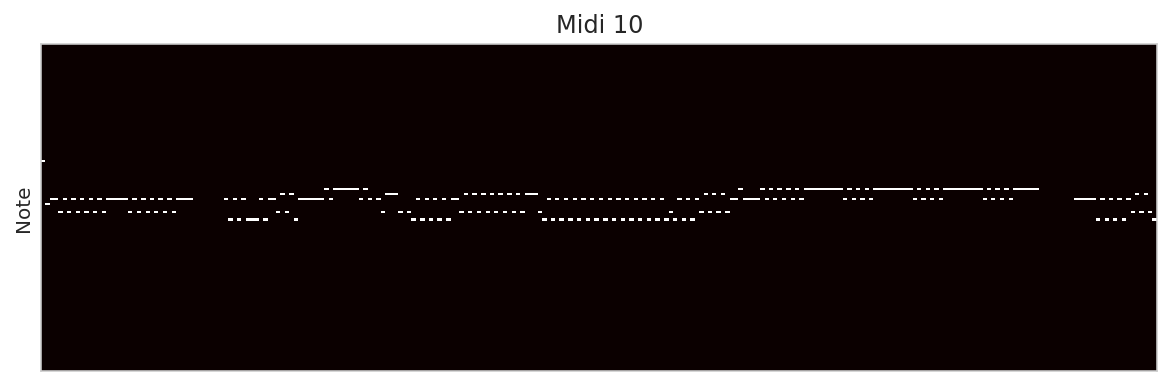

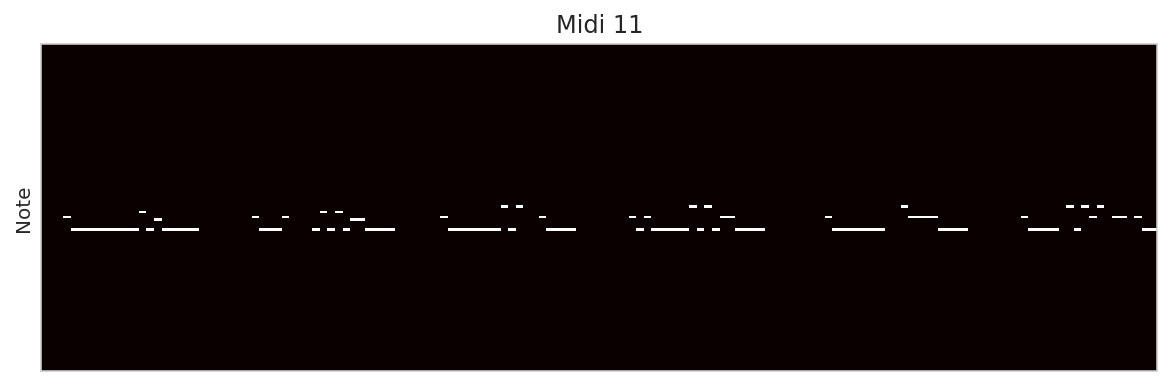

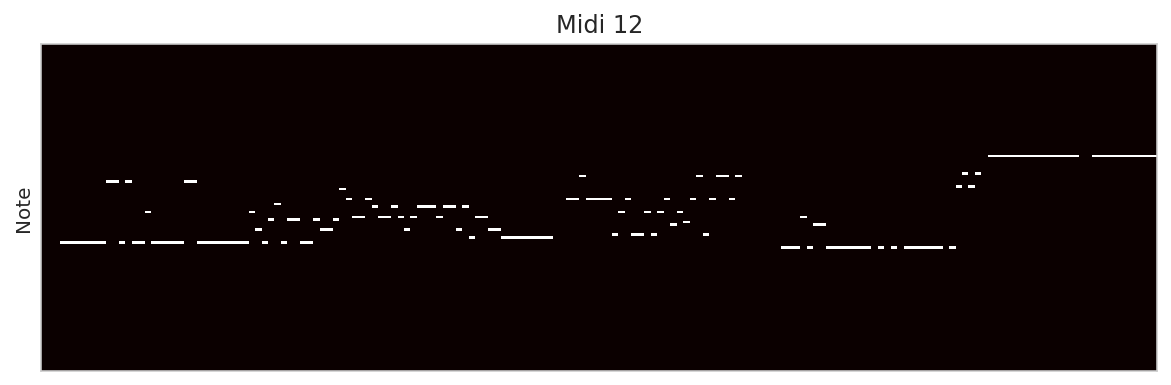

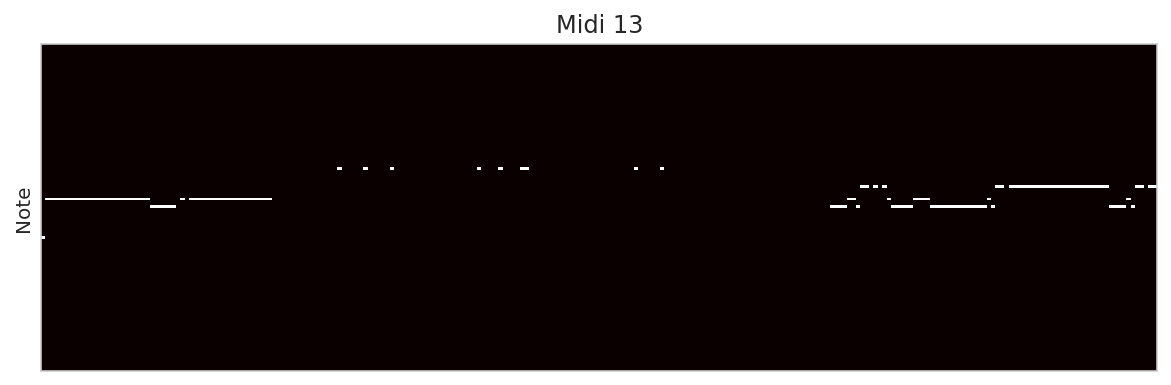

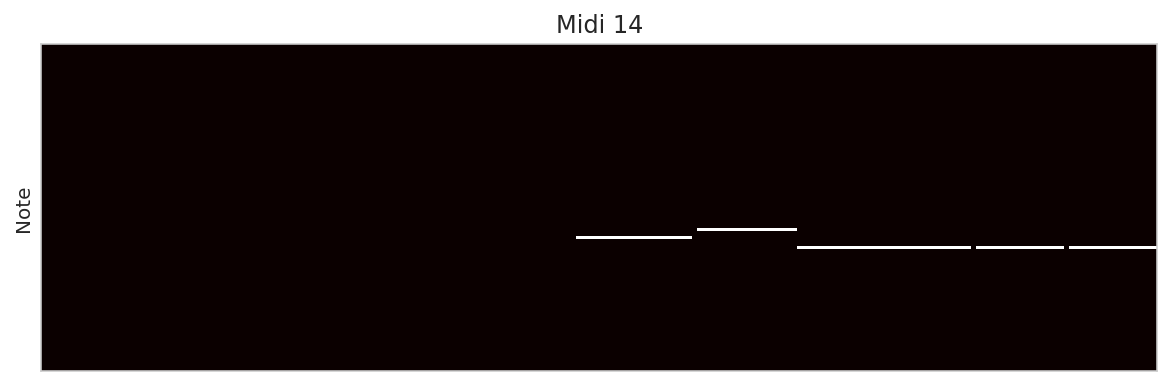

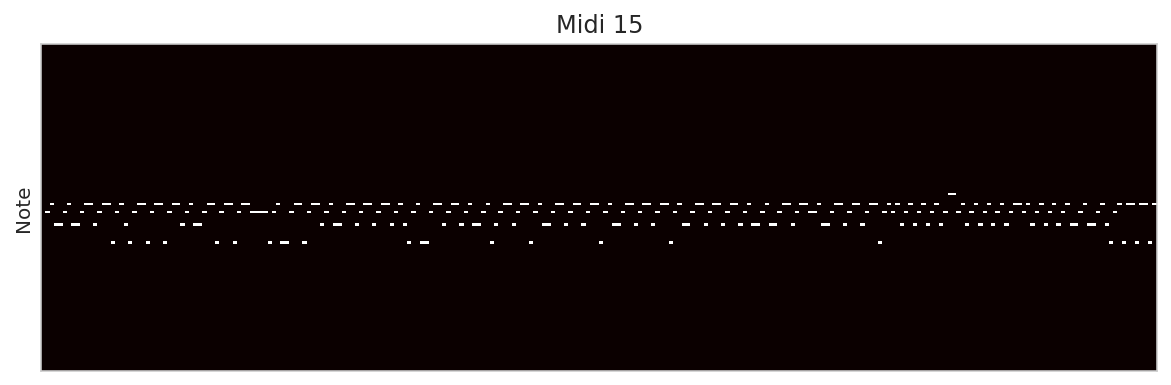

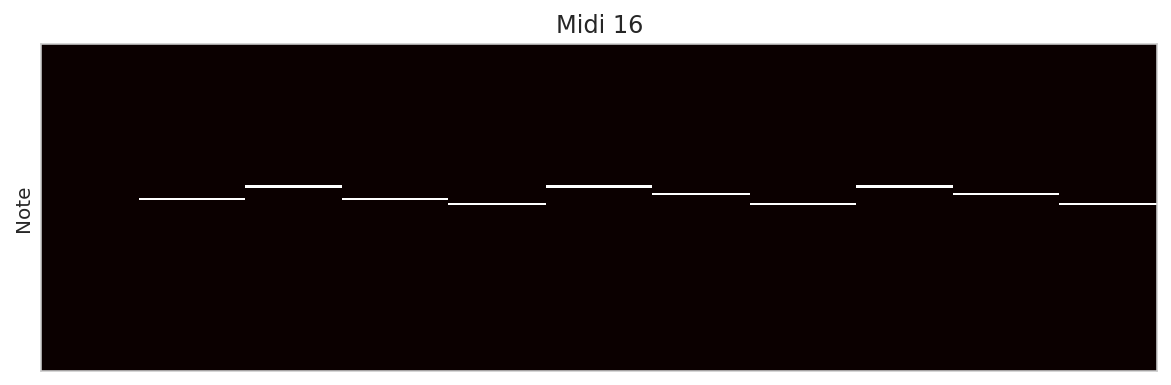

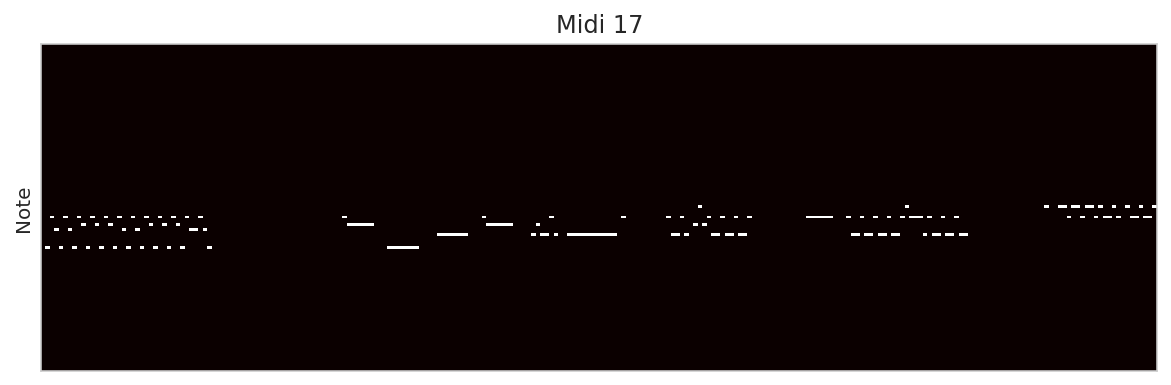

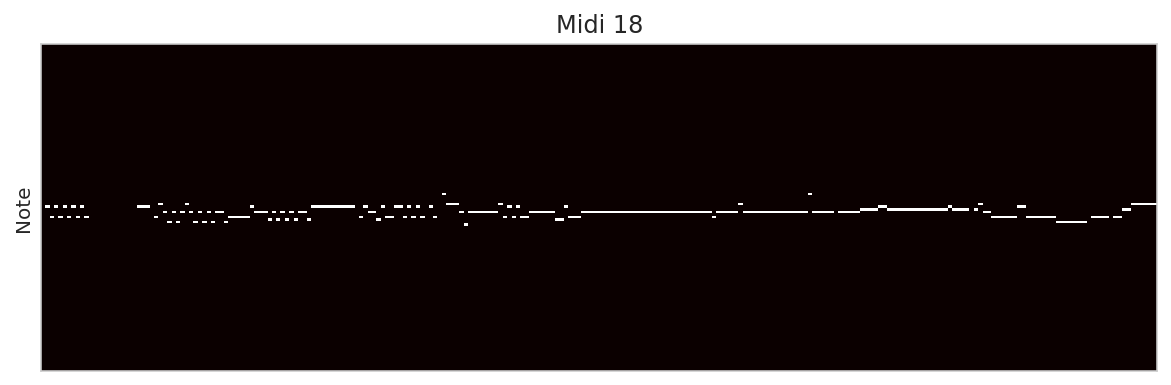

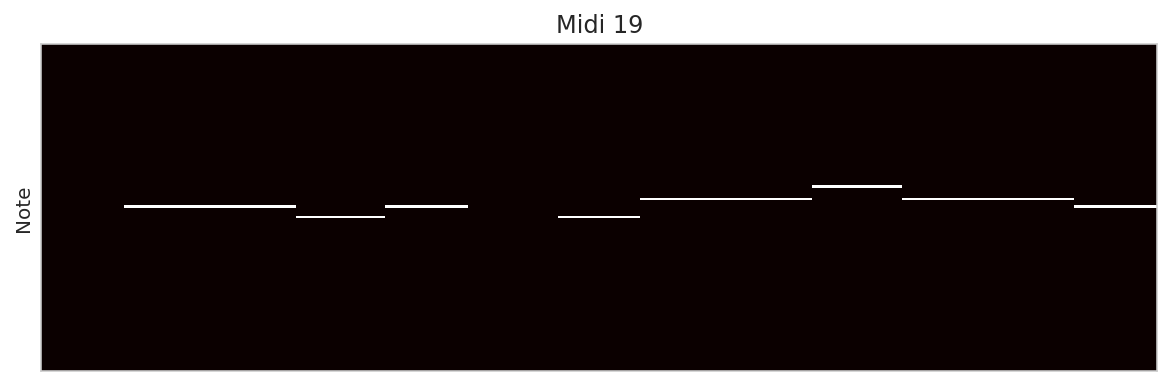

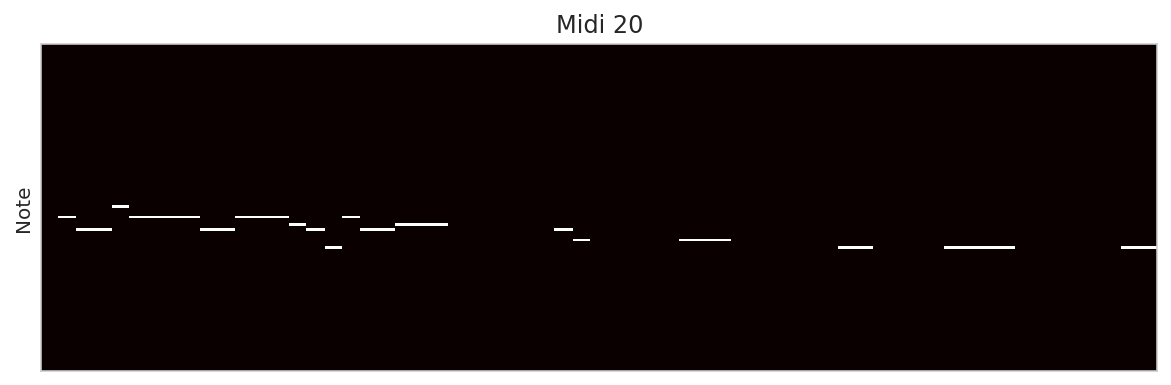

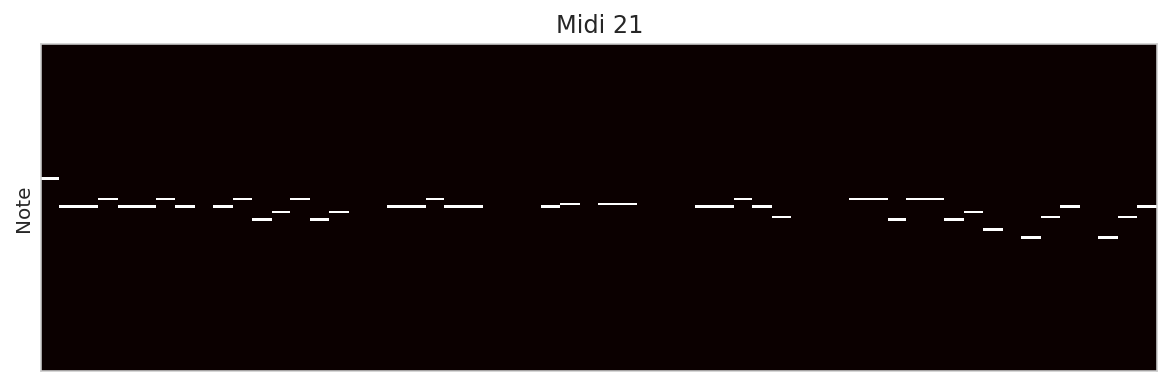

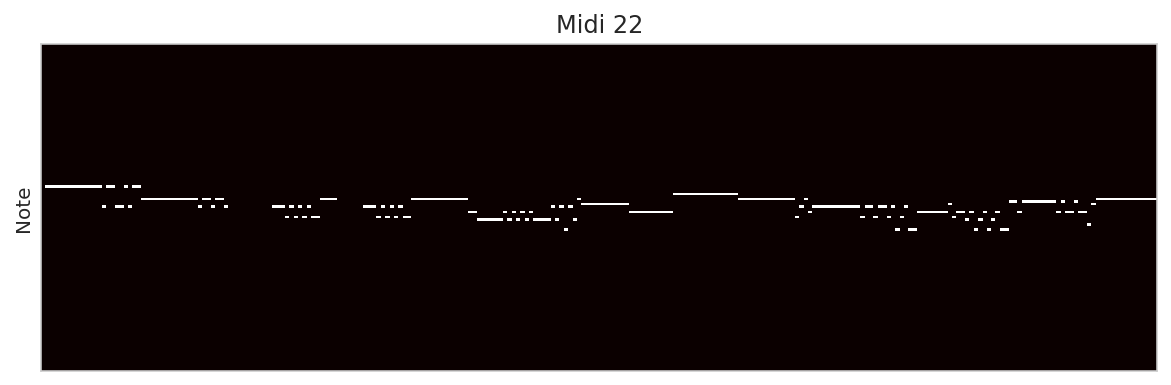

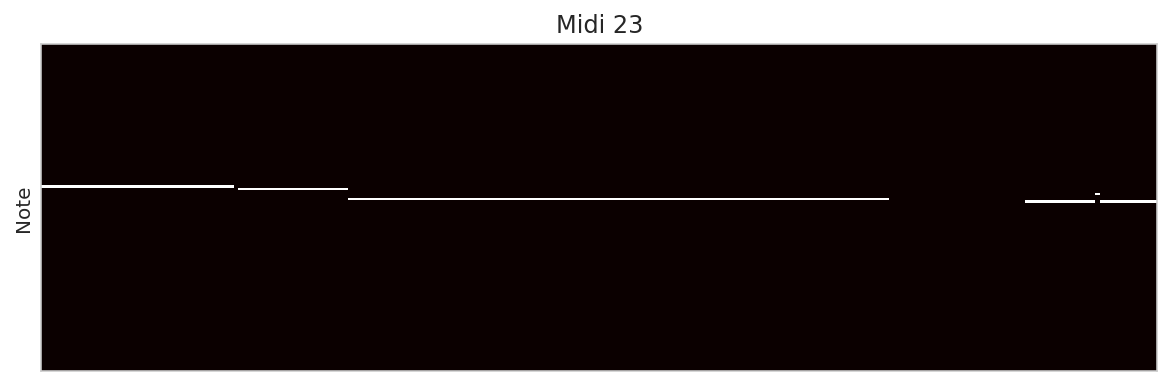

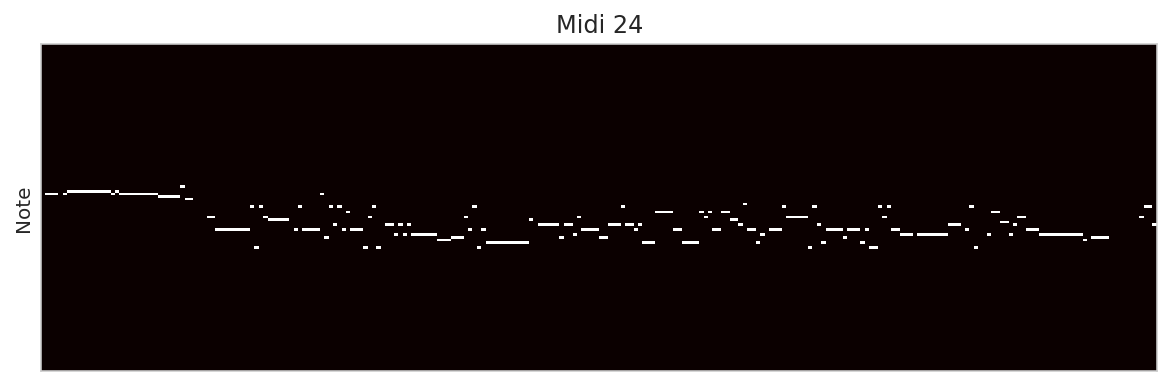

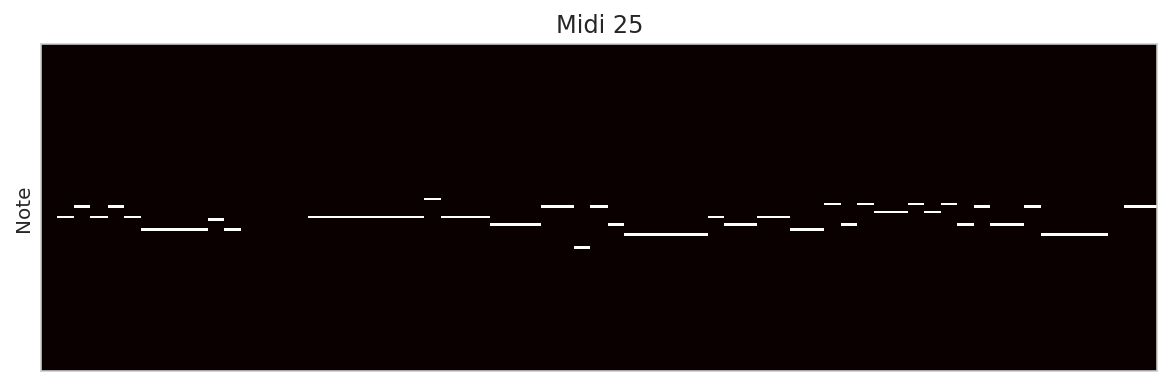

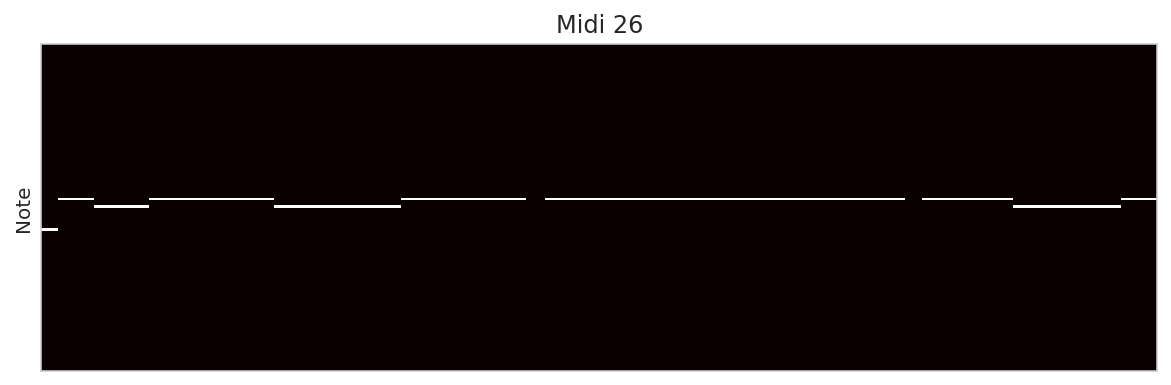

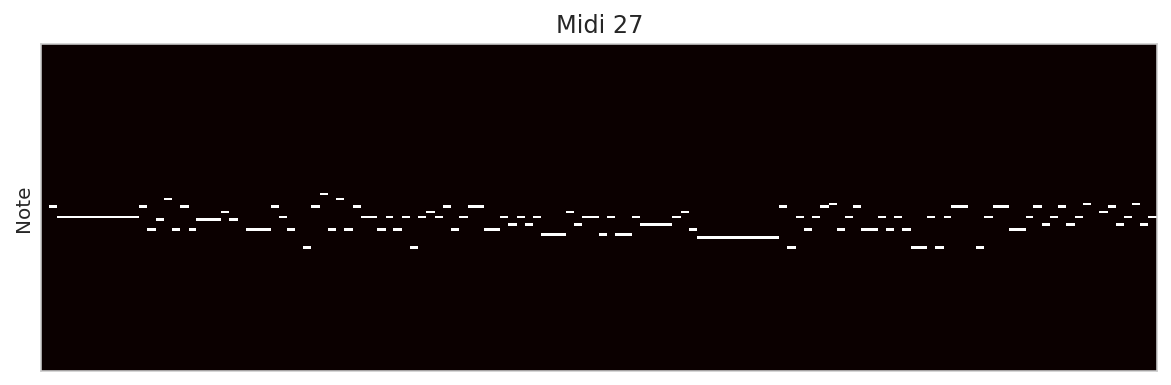

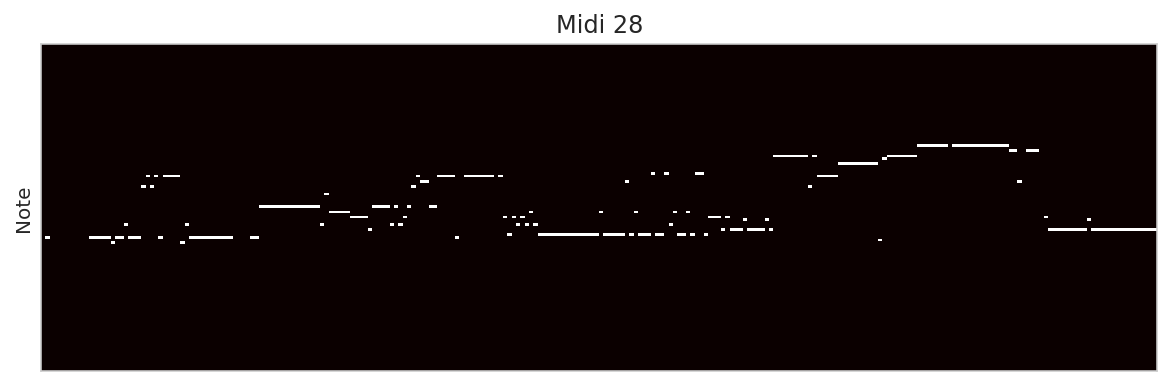

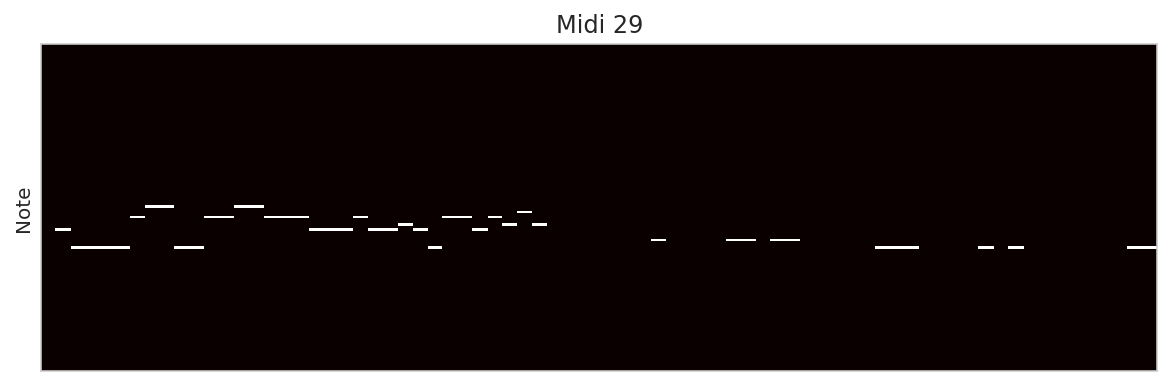

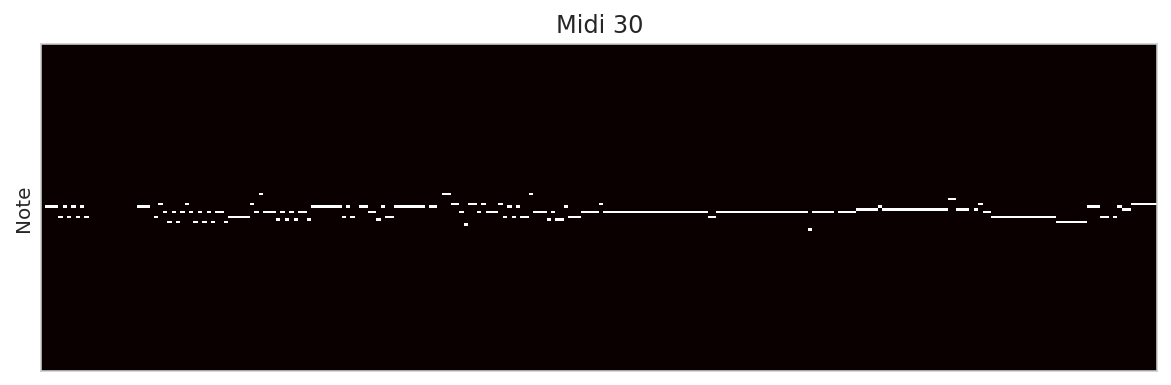

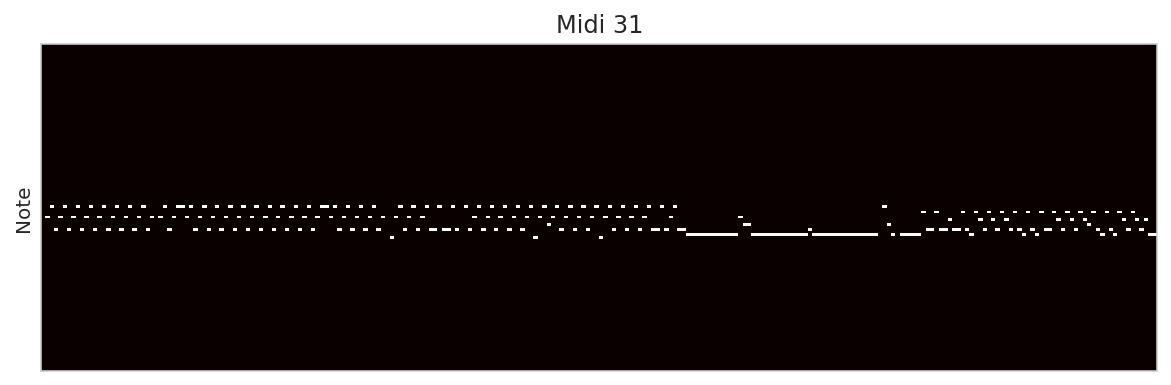

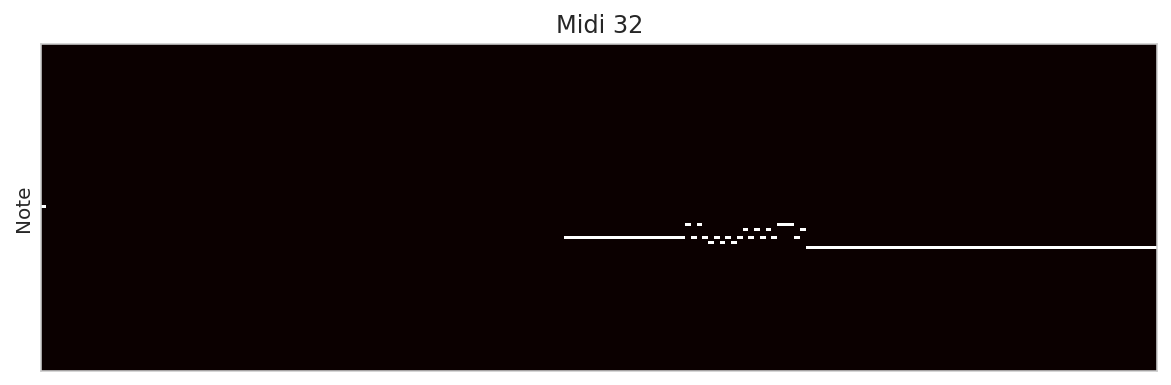

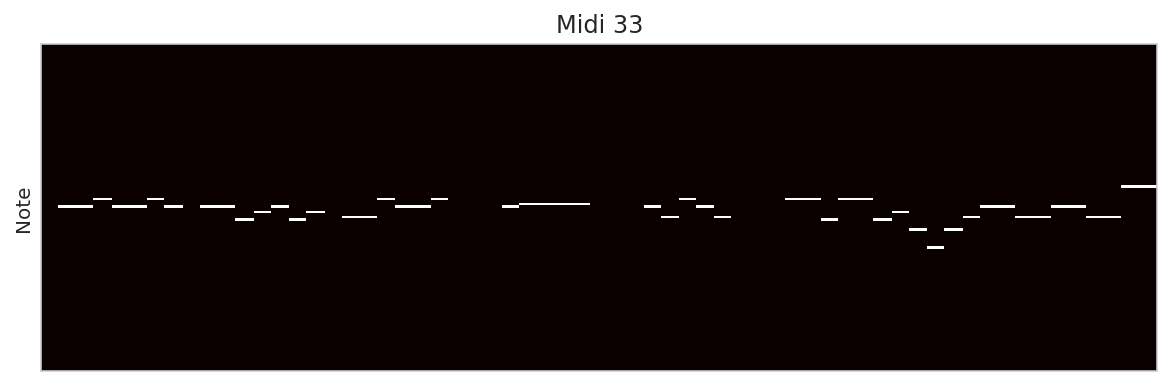

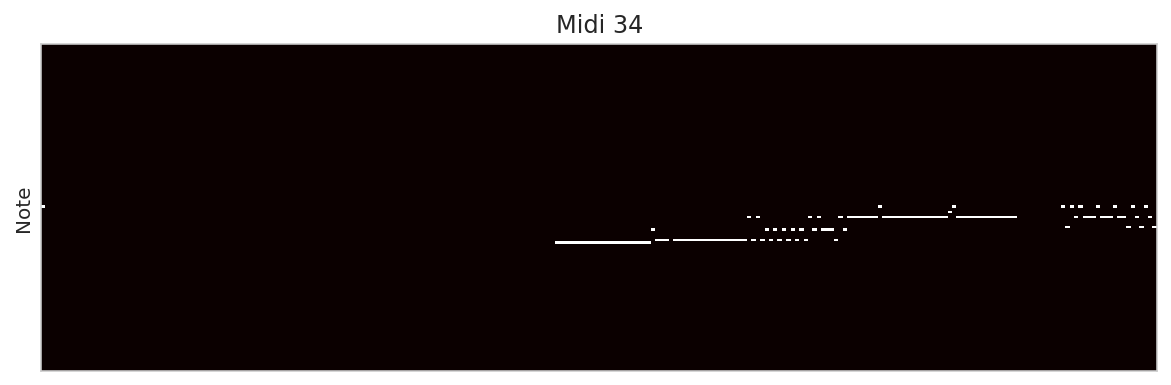

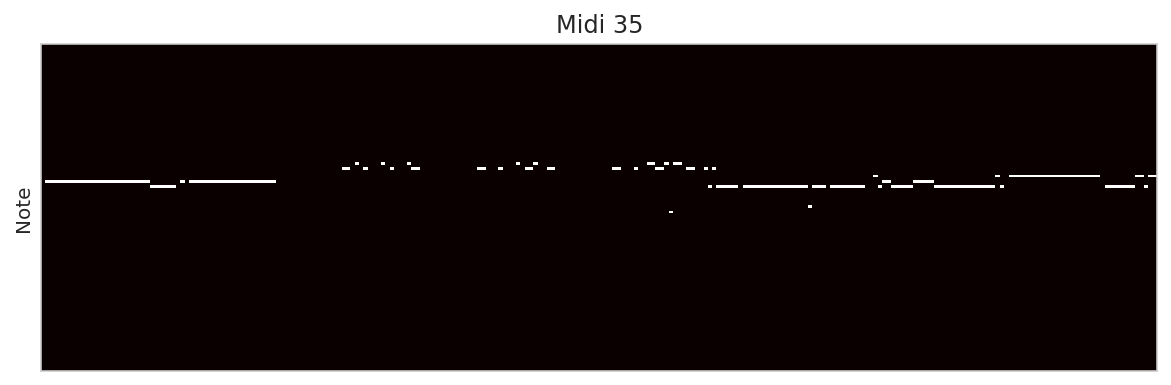

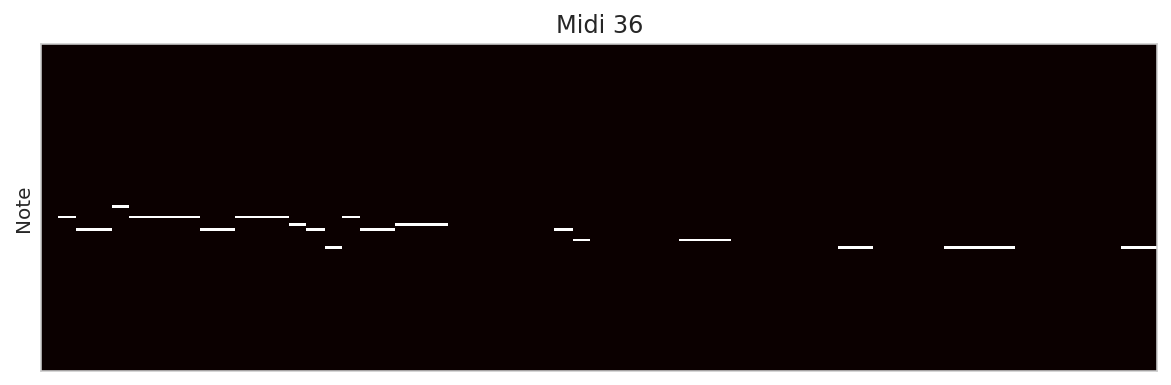

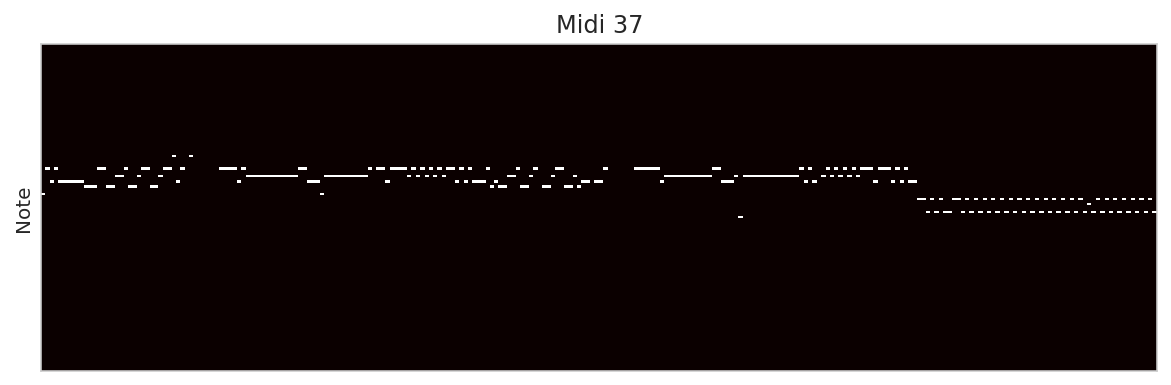

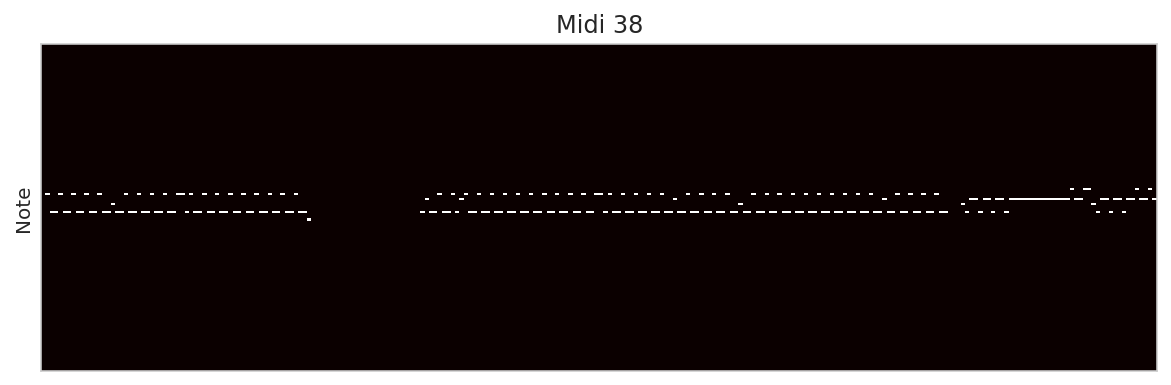

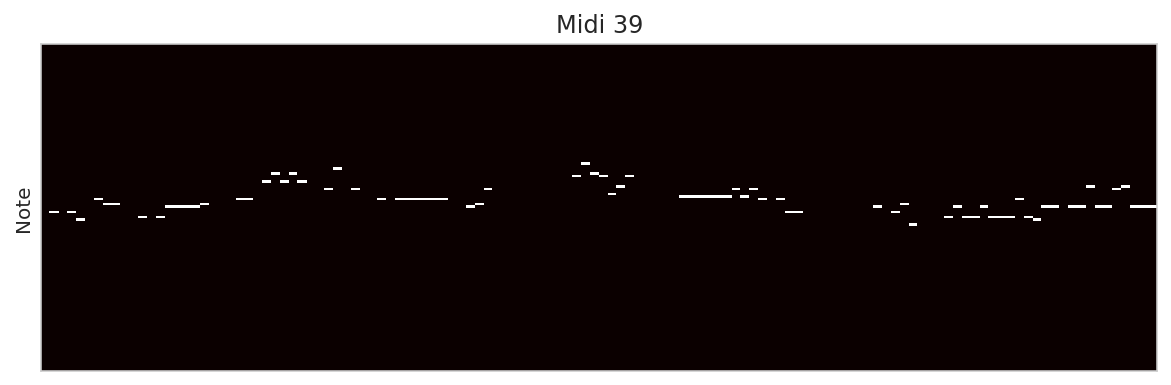

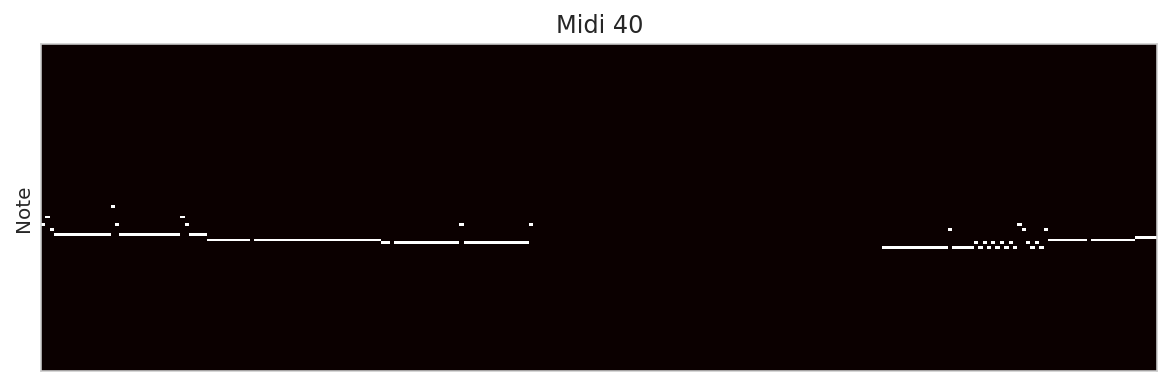

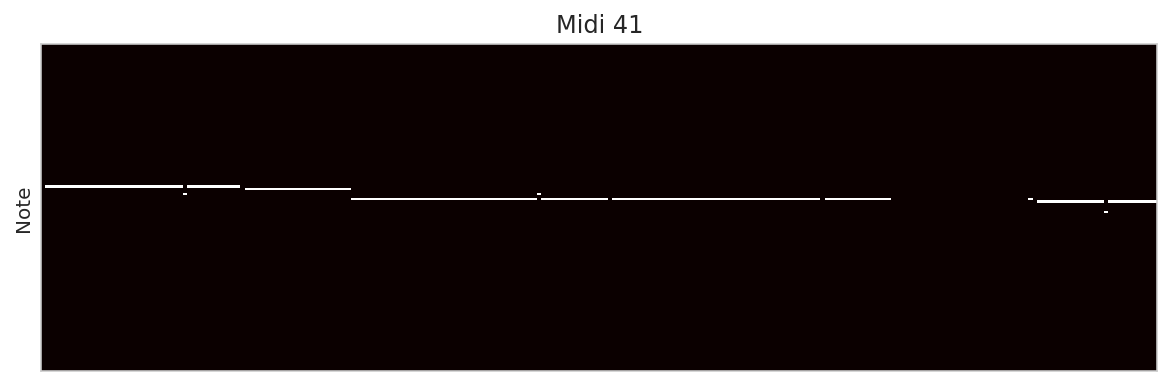

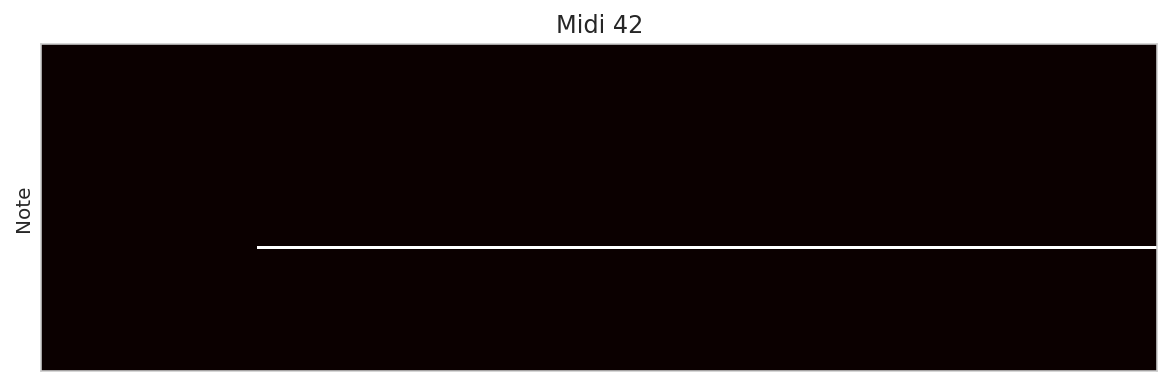

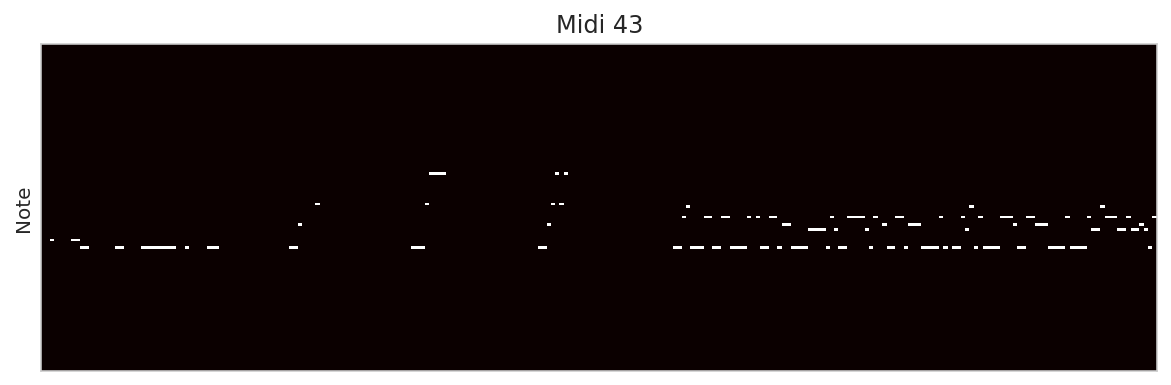

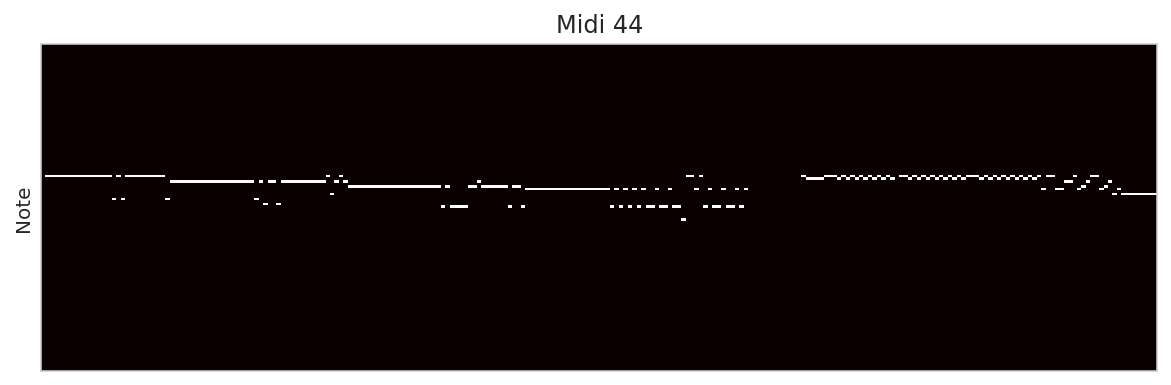

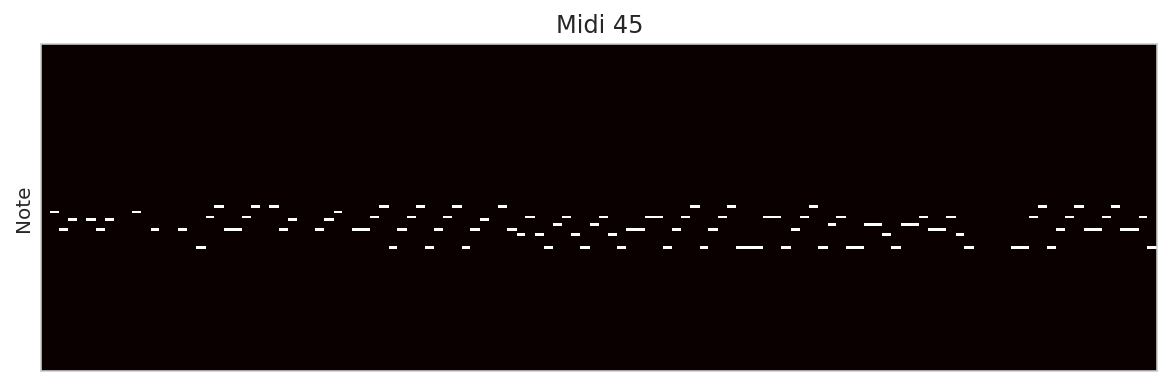

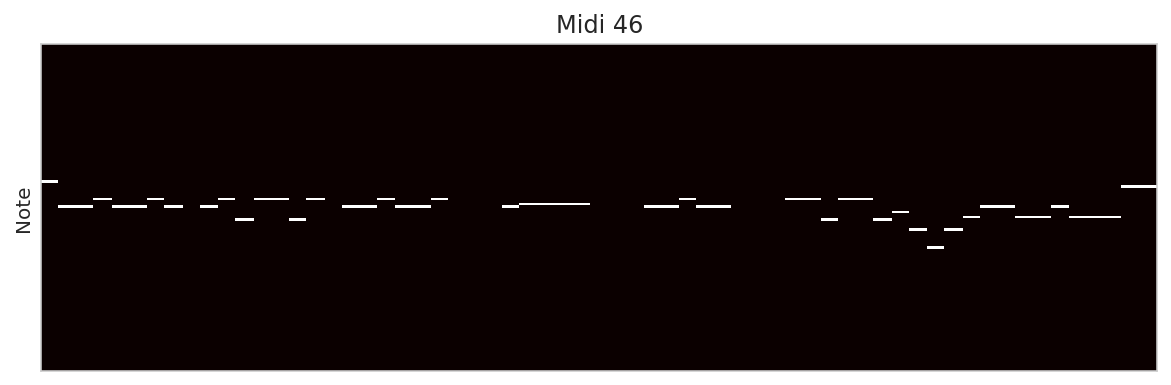

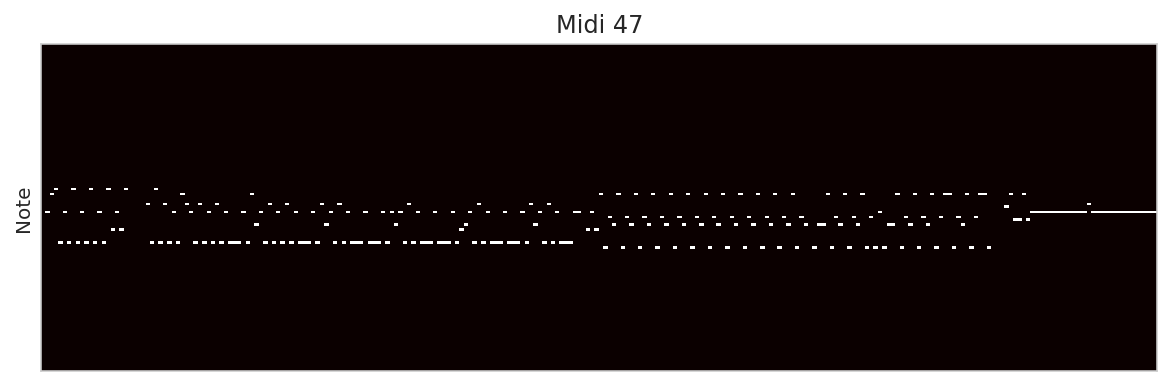

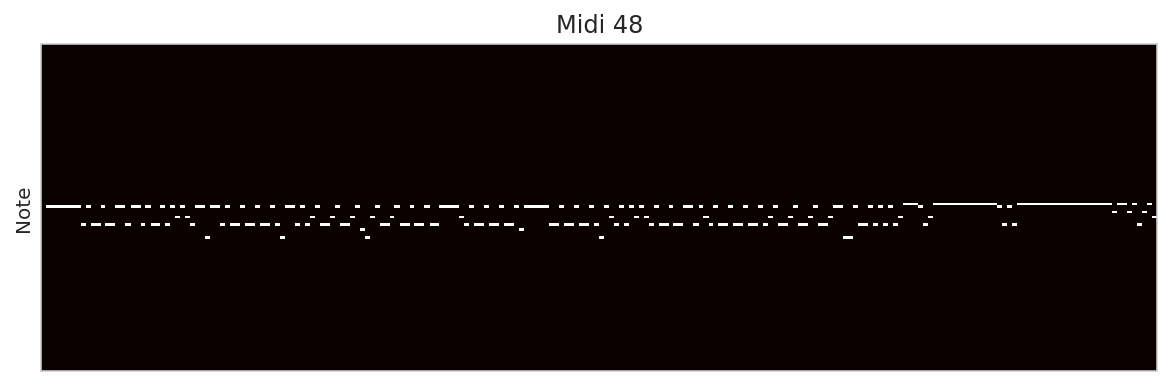

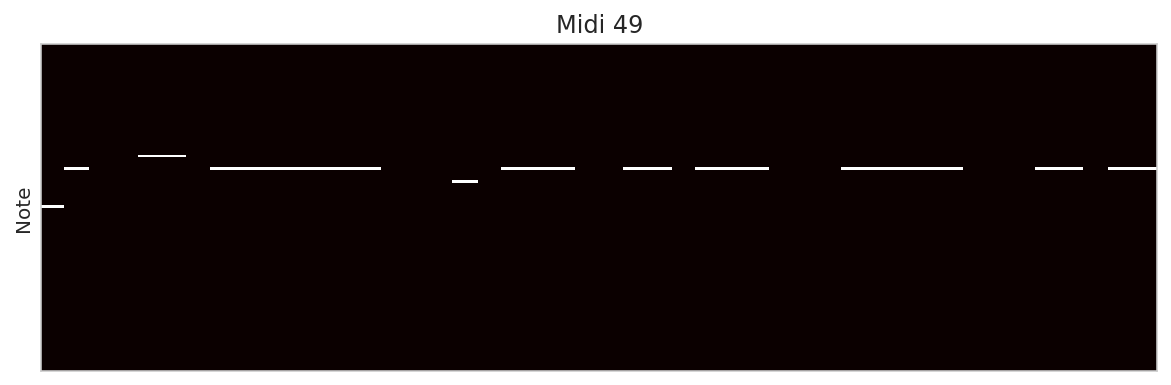

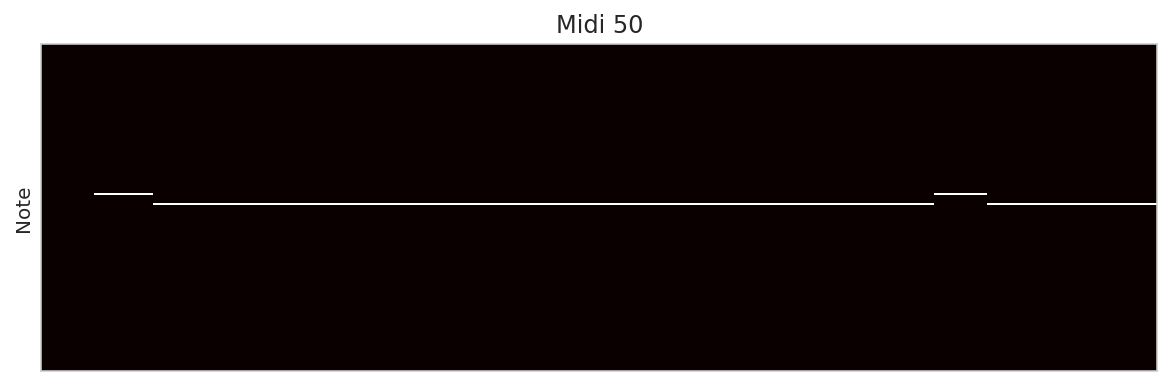

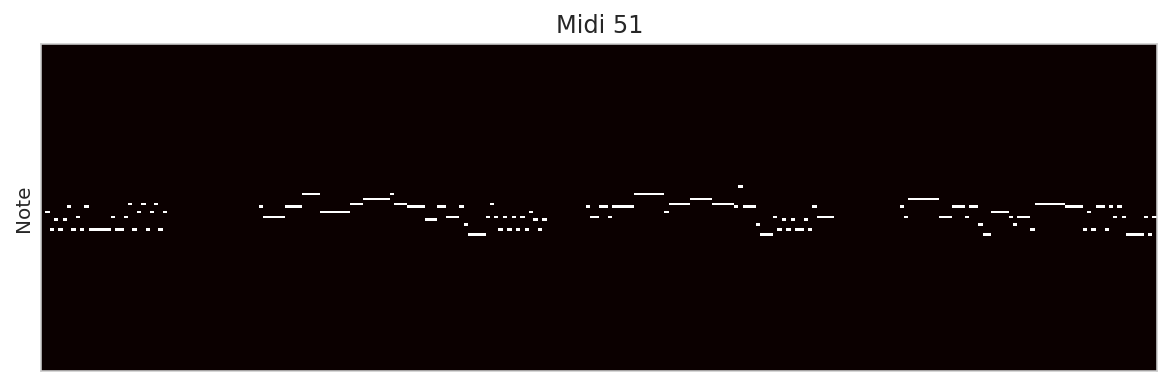

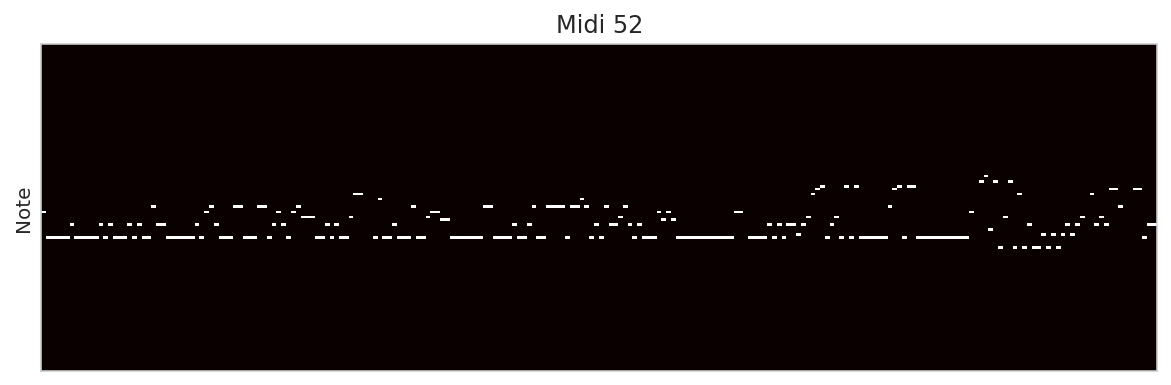

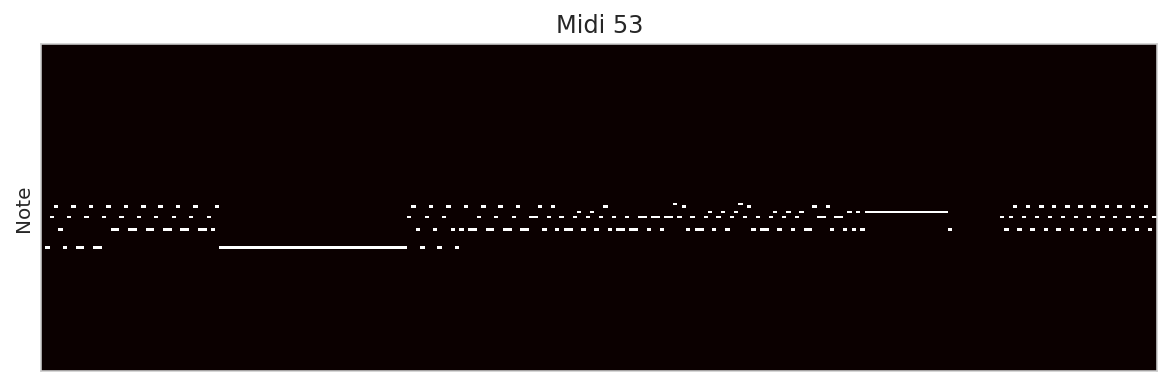

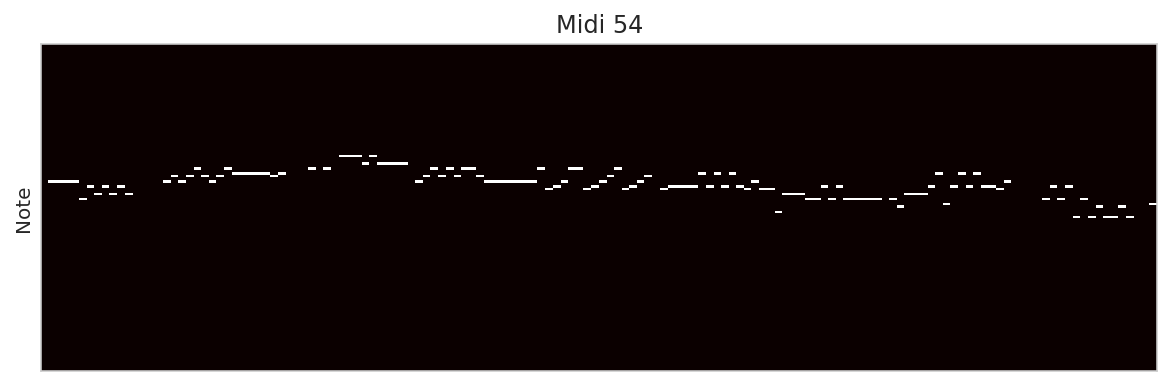

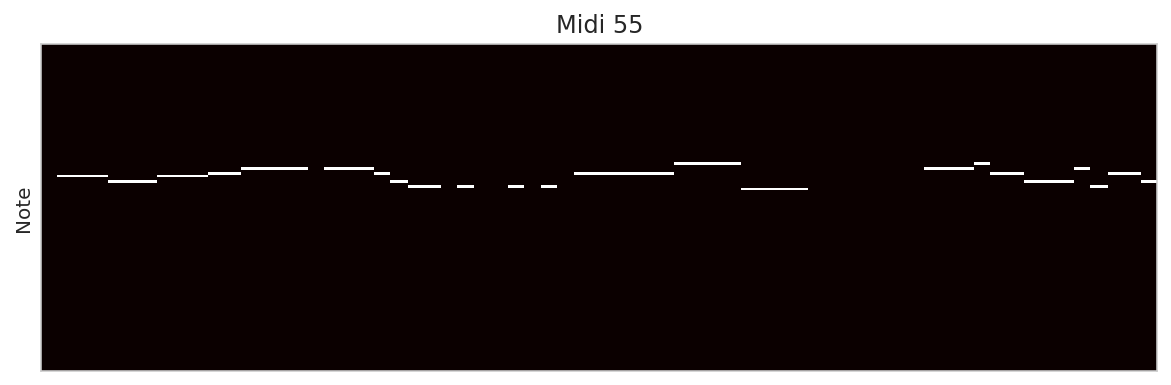

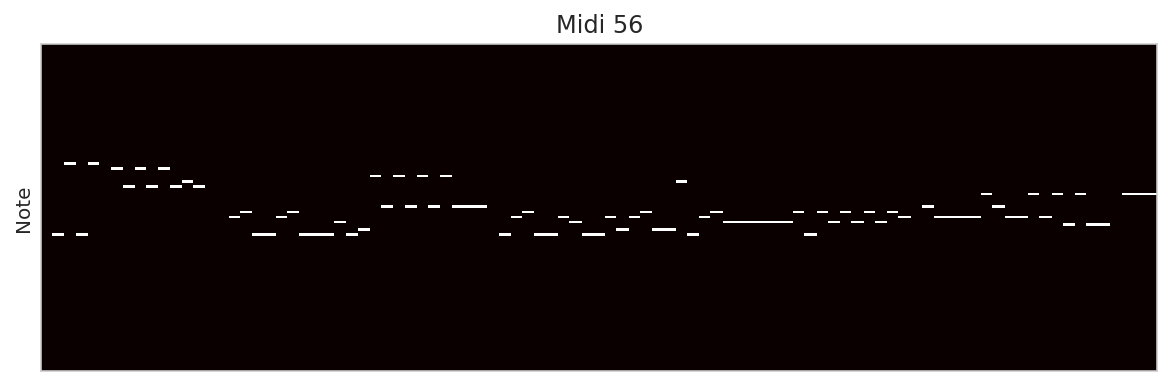

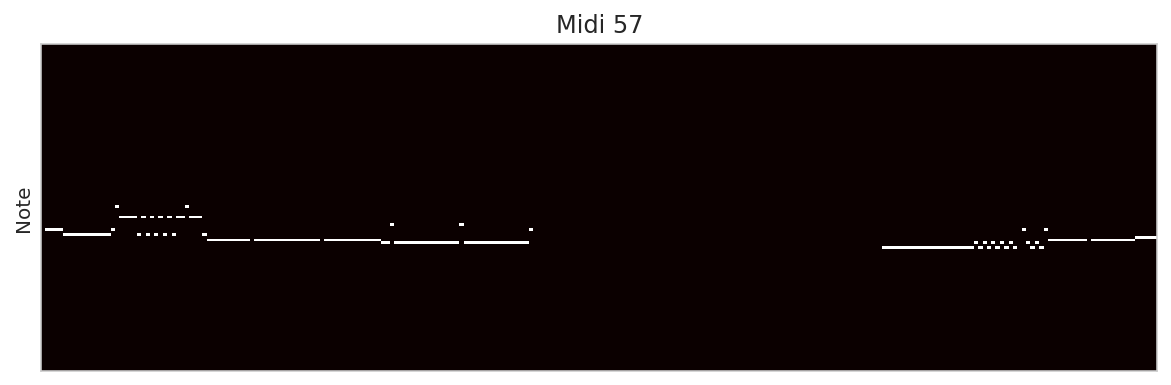

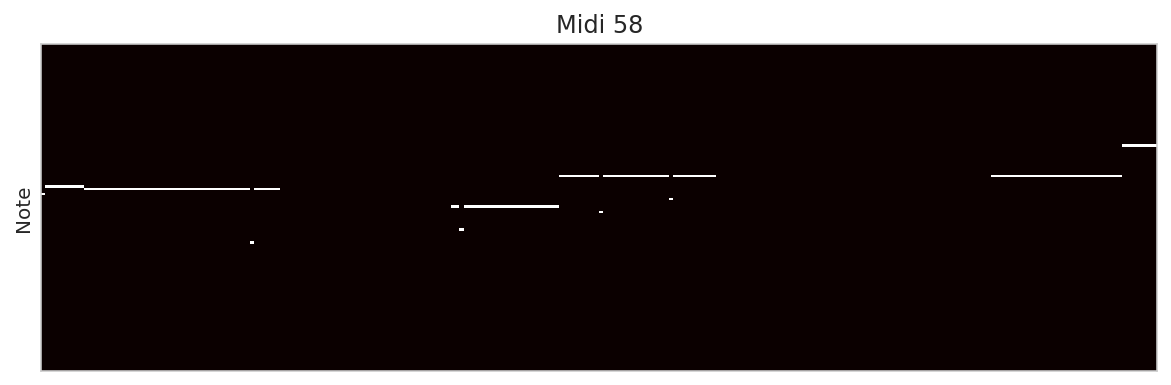

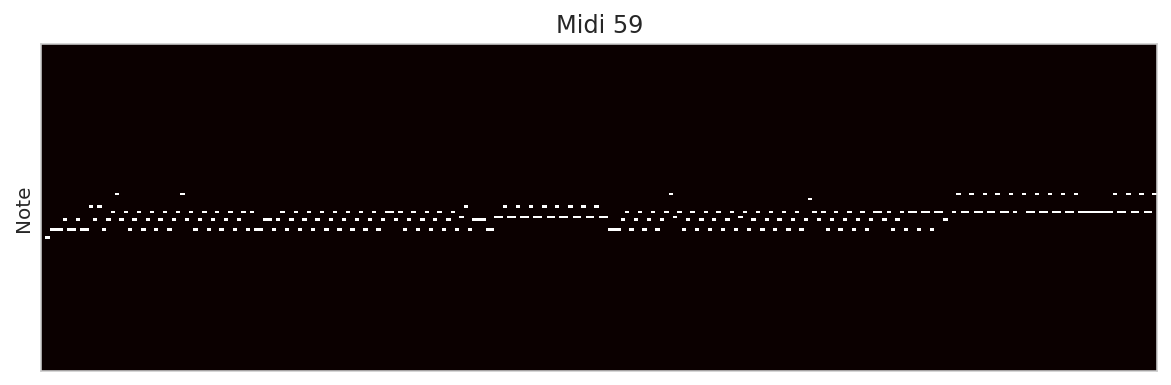

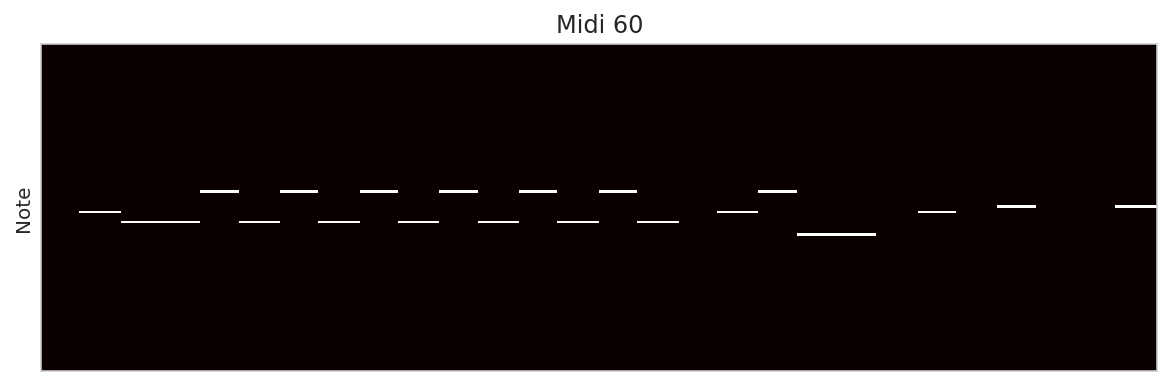

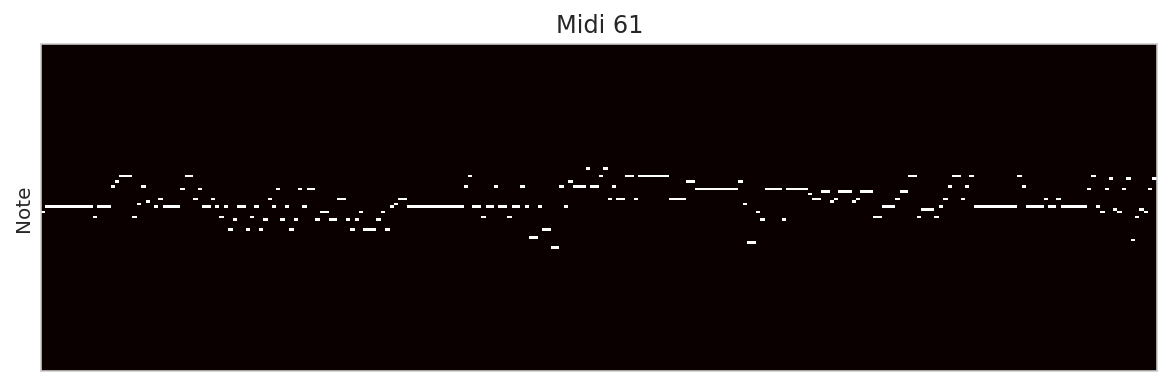

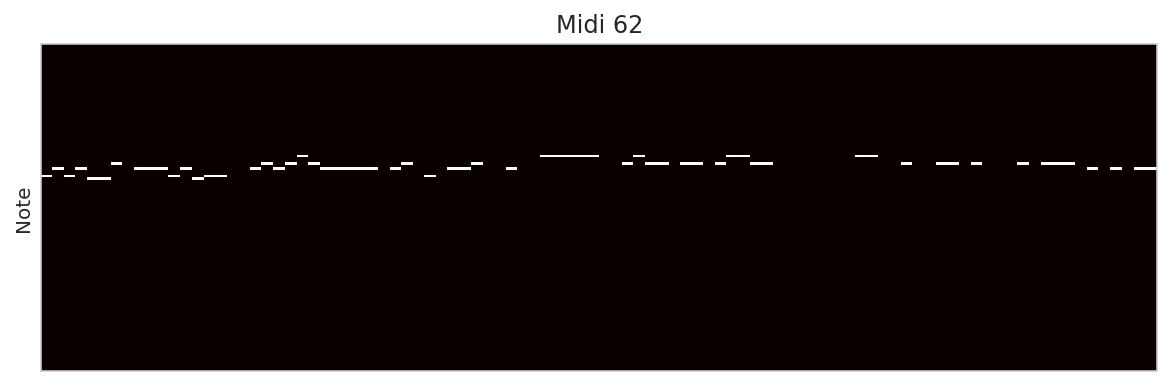

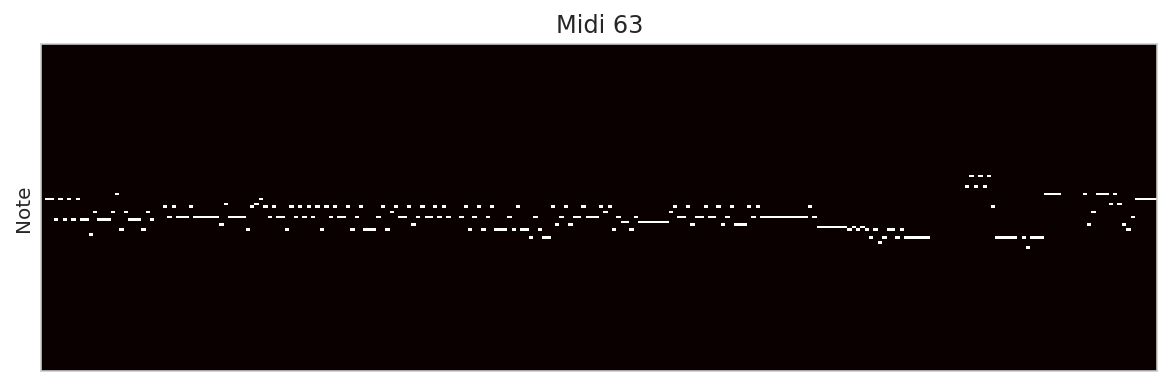

In [25]:
 ate(x_hat_np):
    row_maxes = seq.max(axis=1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    if np.all(midi_out[:,-1]):
        print("Midi: {} is all silent".format(i))
        continue
    np.savetxt("midi/csv_midi_out_{}.csv".format(i), midi_out, delimiter=";")
    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Midi {}".format(i))
    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_{}.png".format(i))
    midi.write('midi/{}.mid'.format(i))

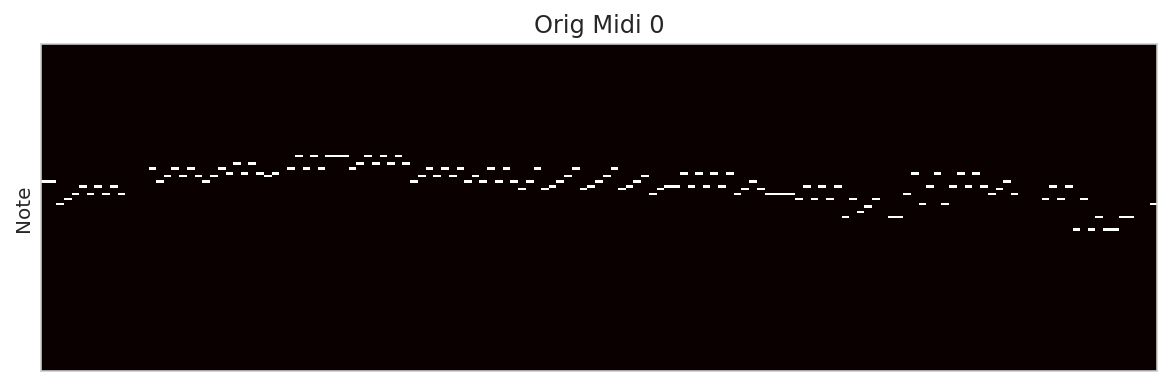

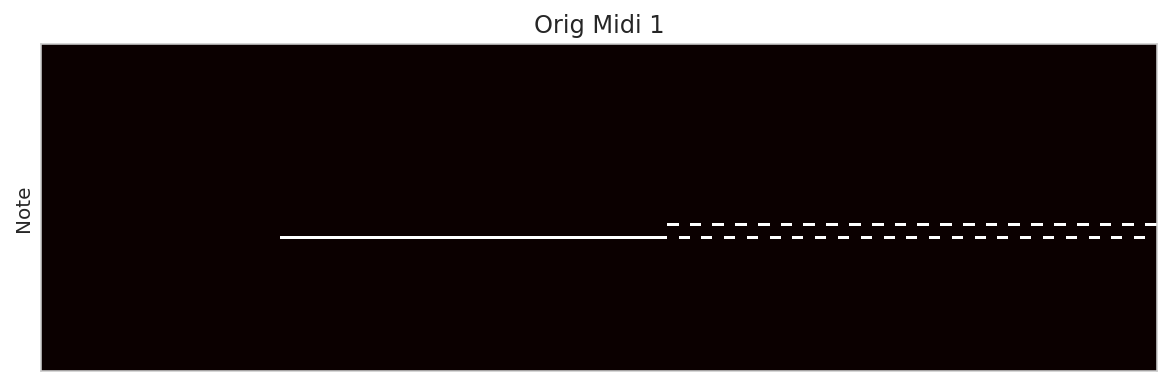

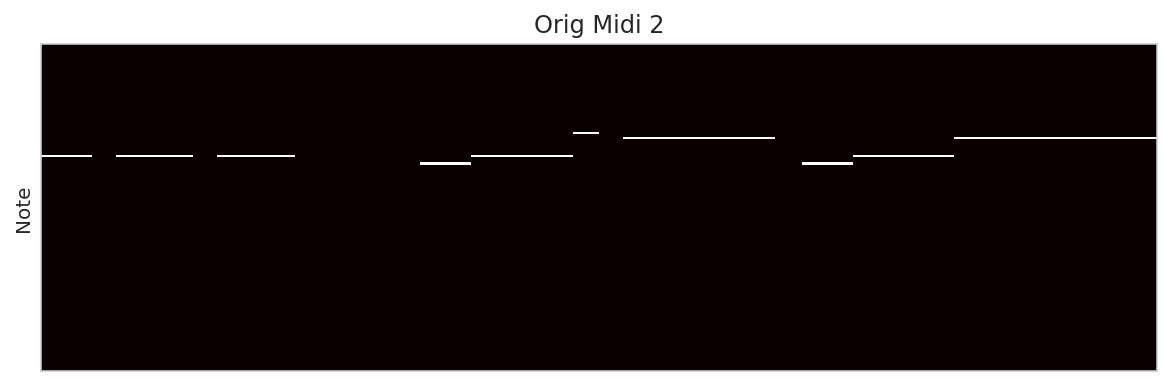

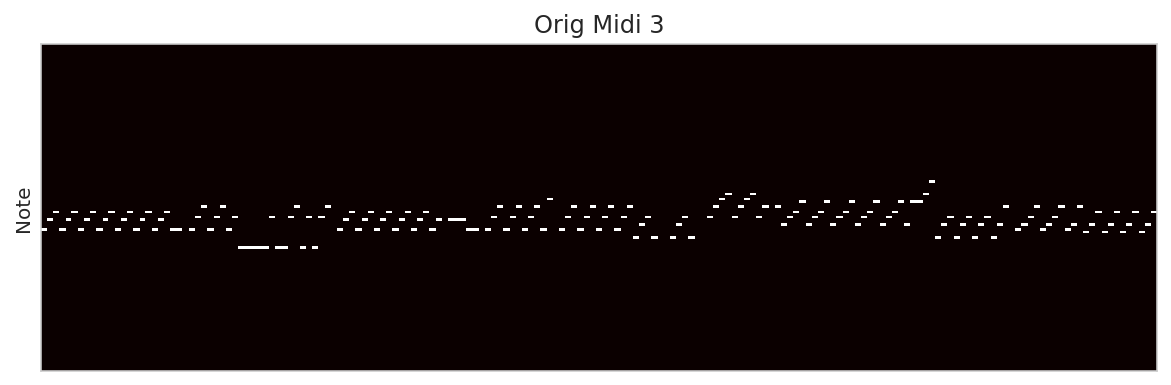

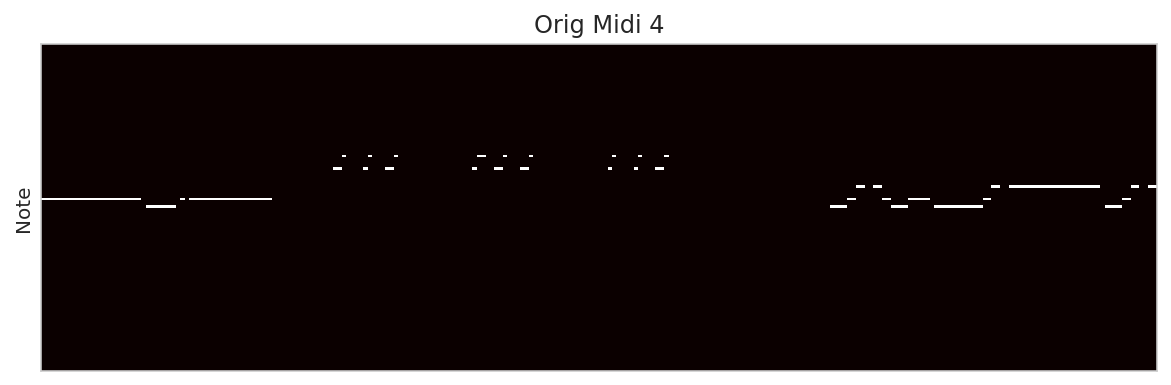

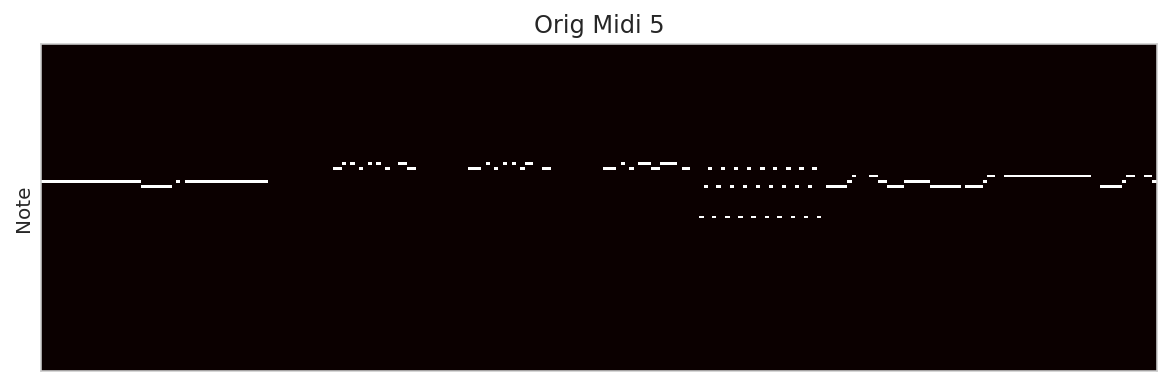

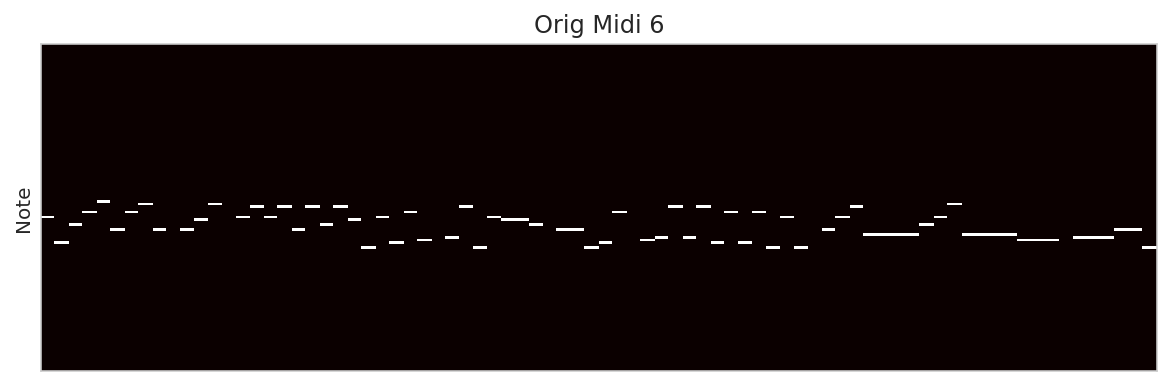

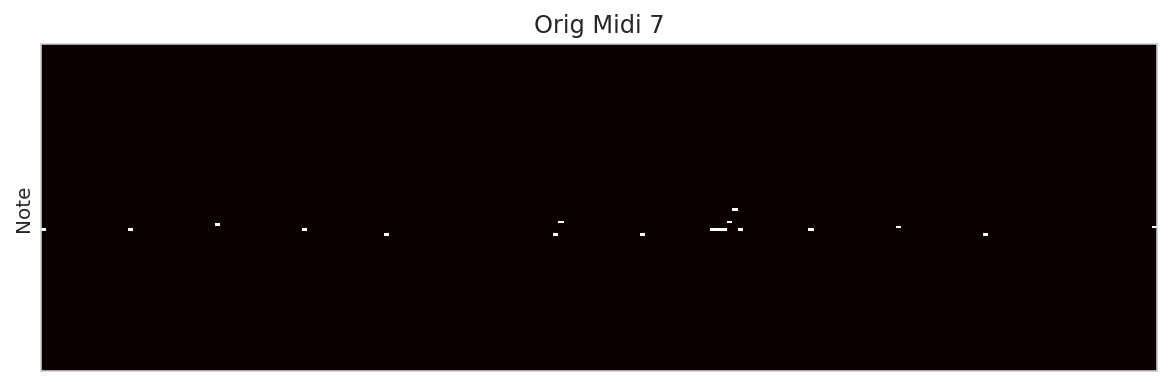

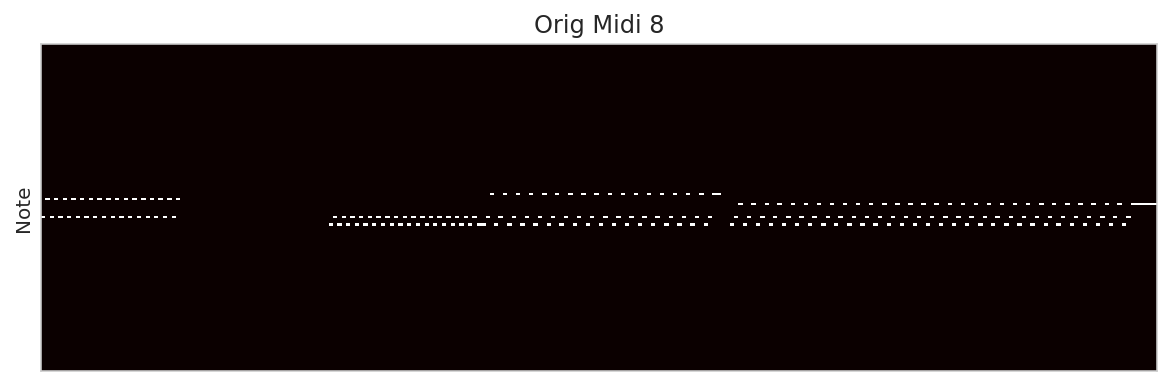

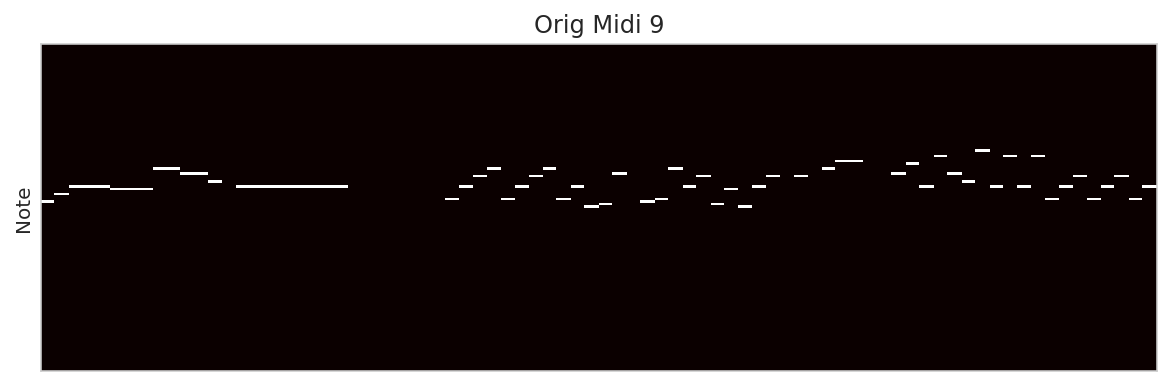

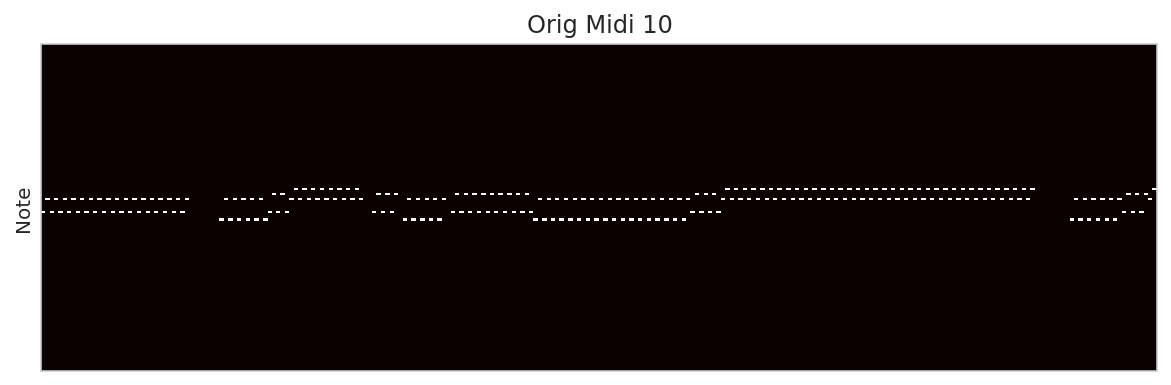

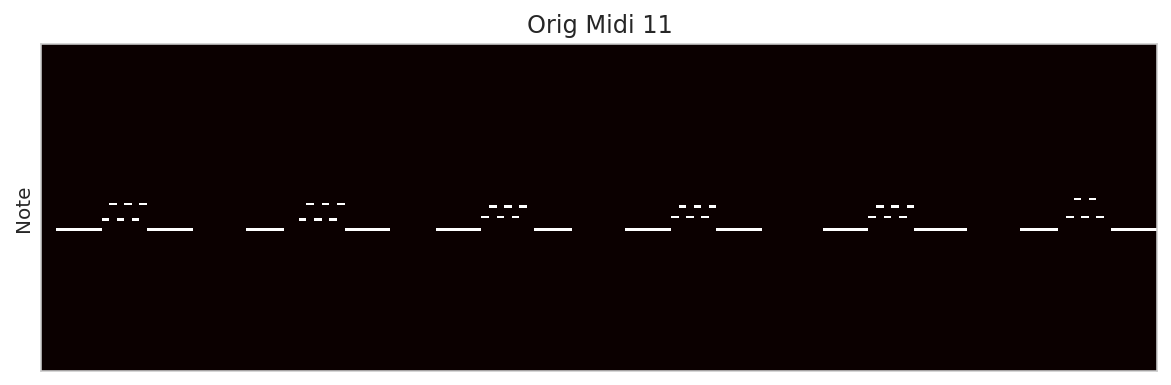

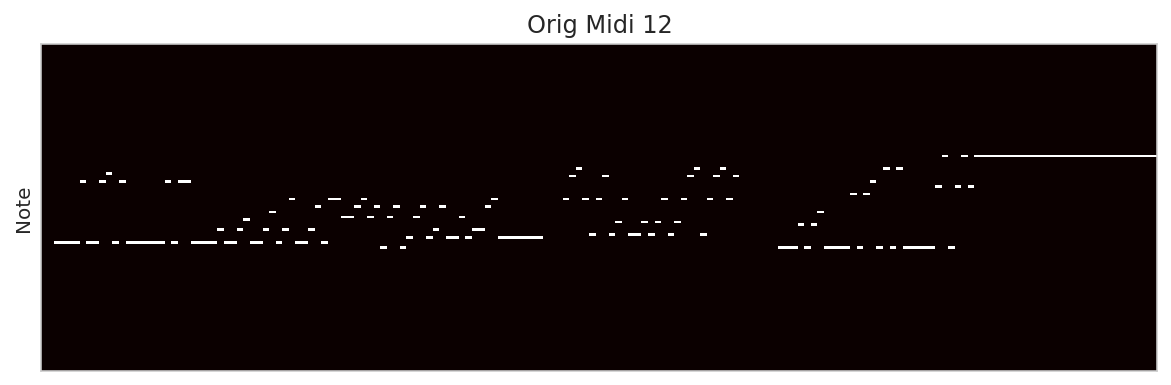

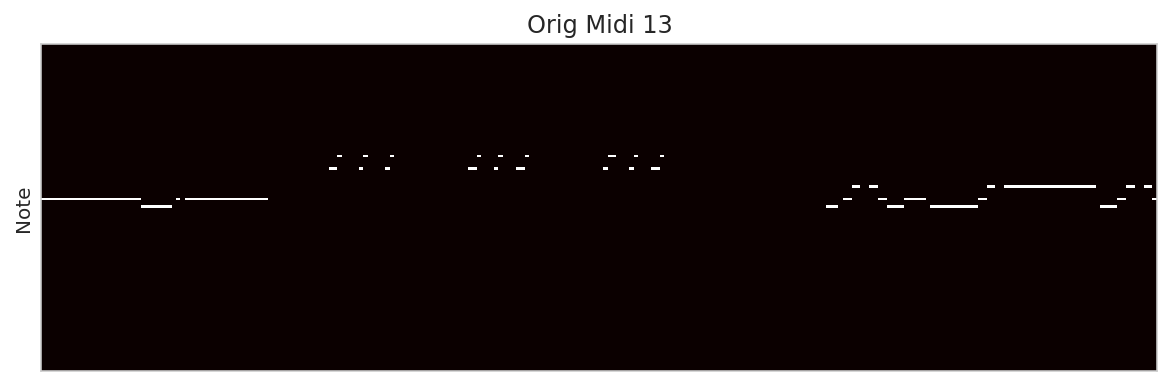

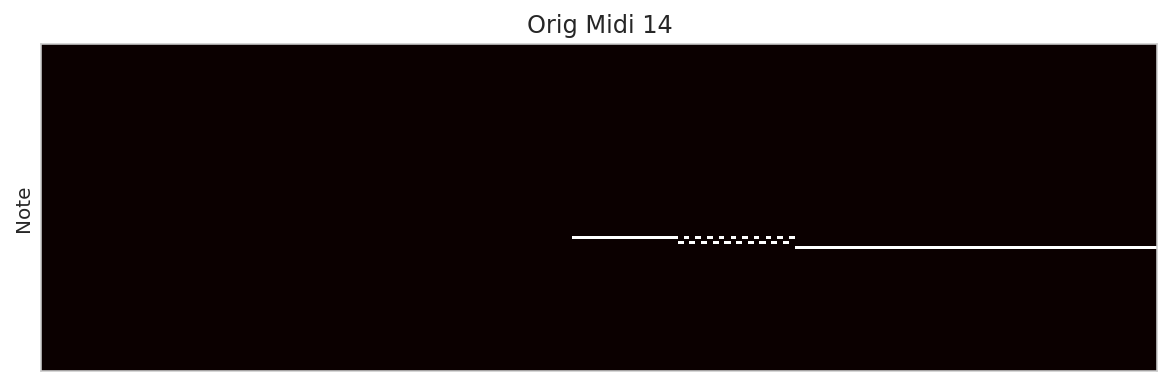

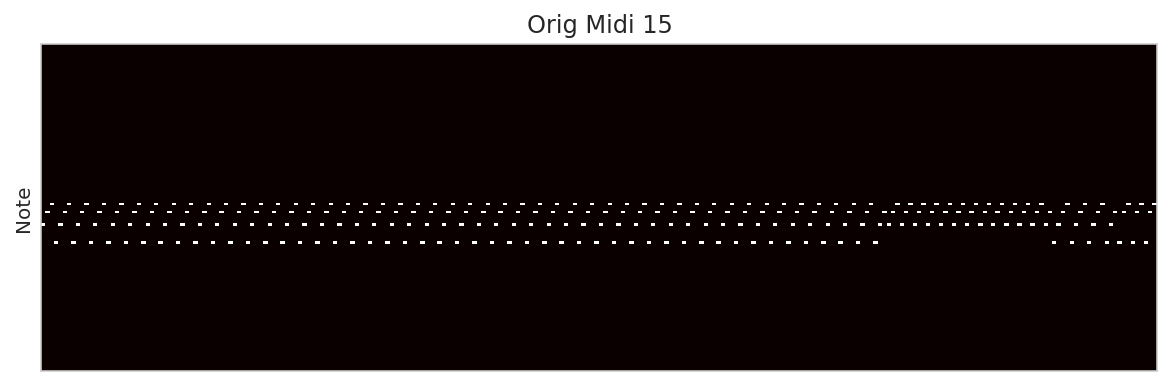

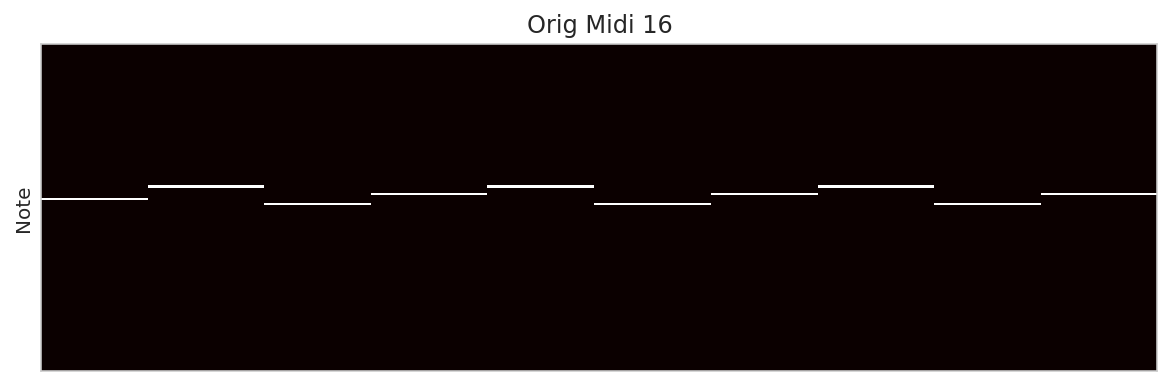

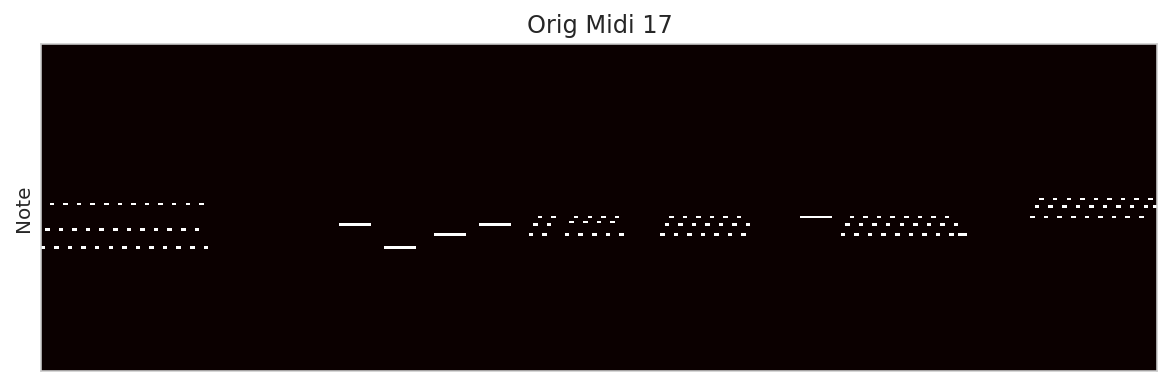

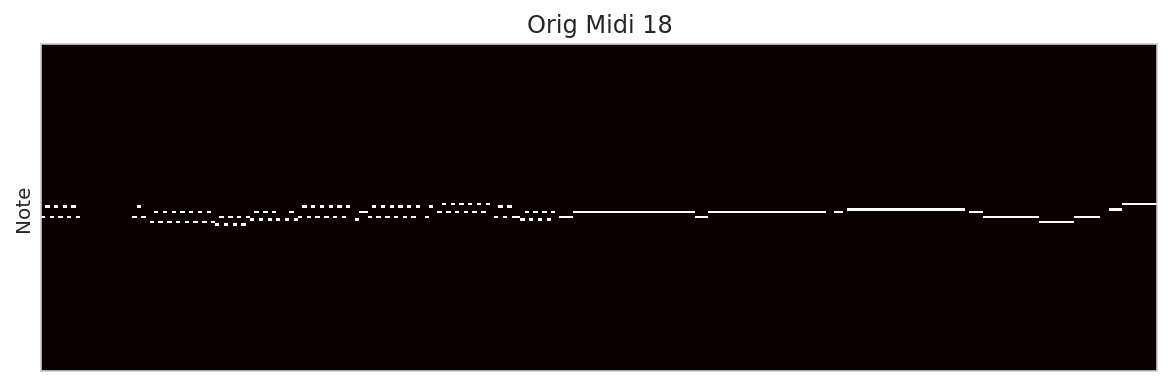

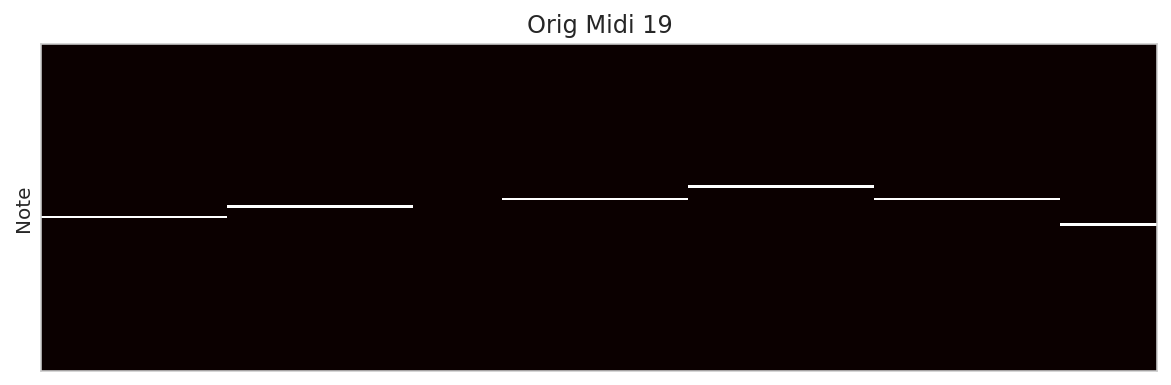

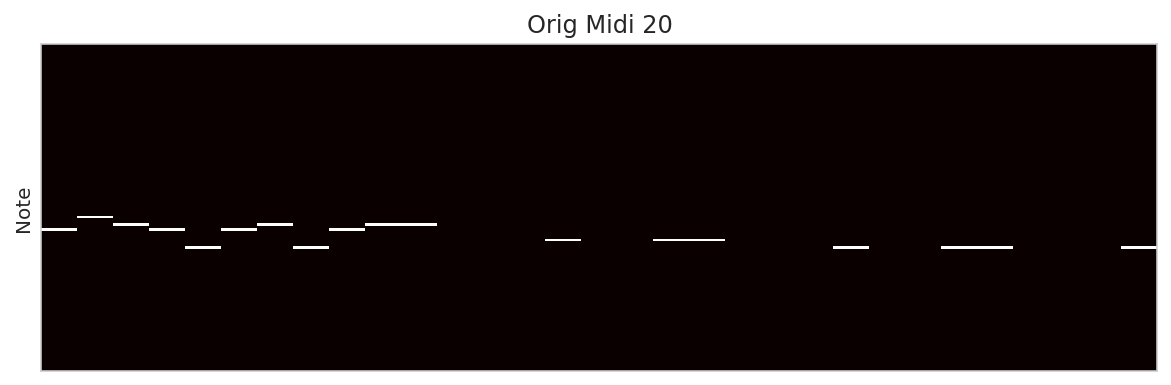

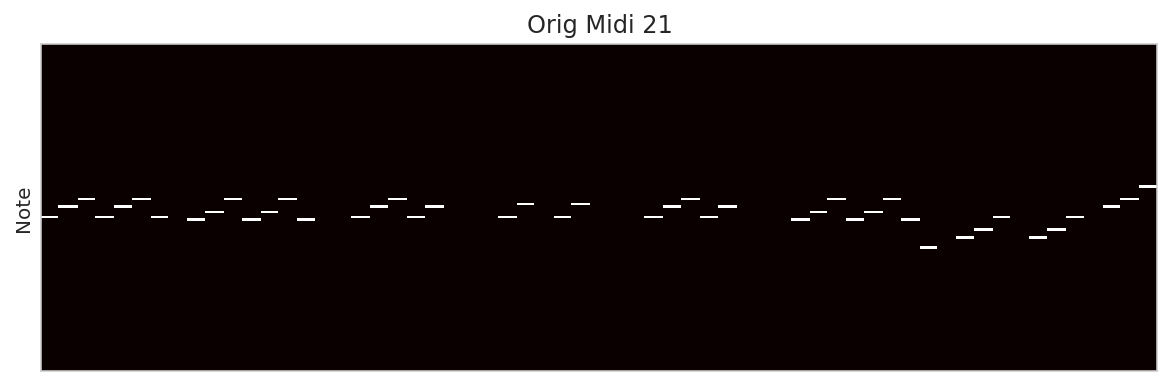

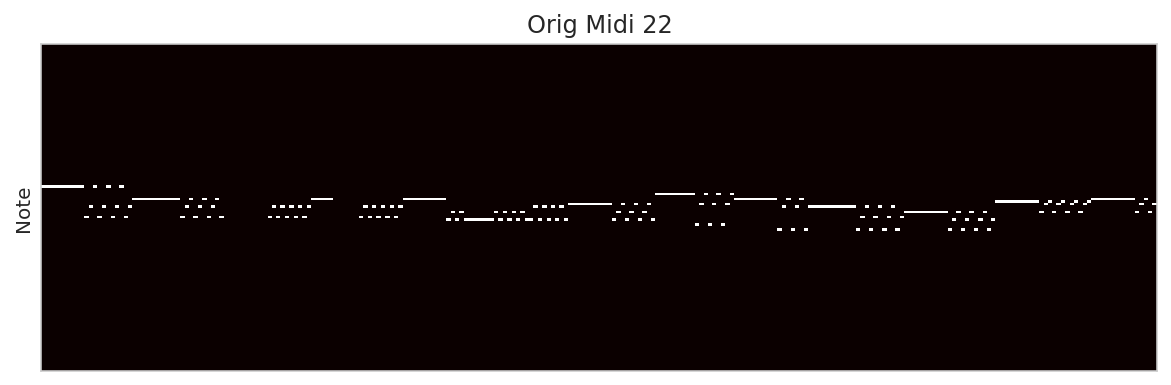

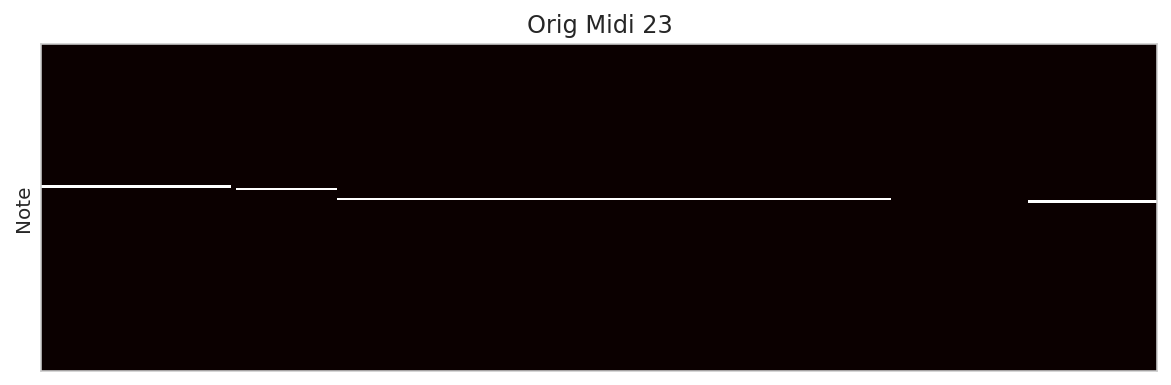

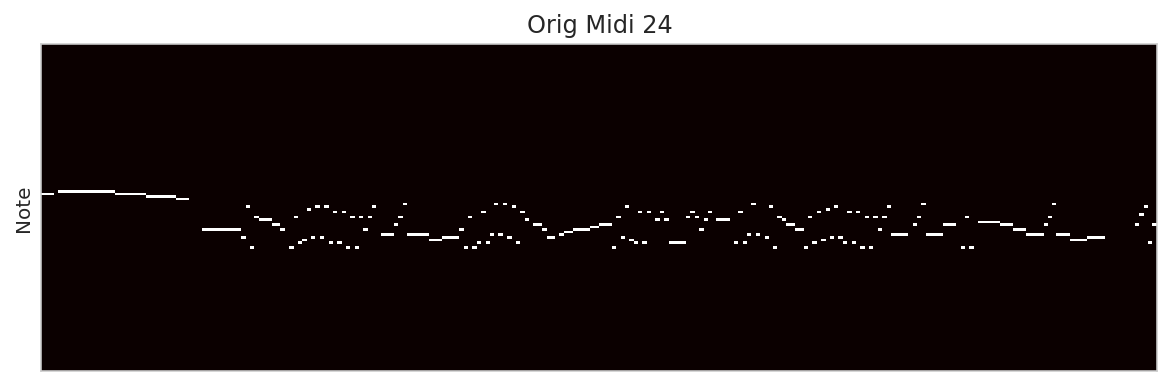

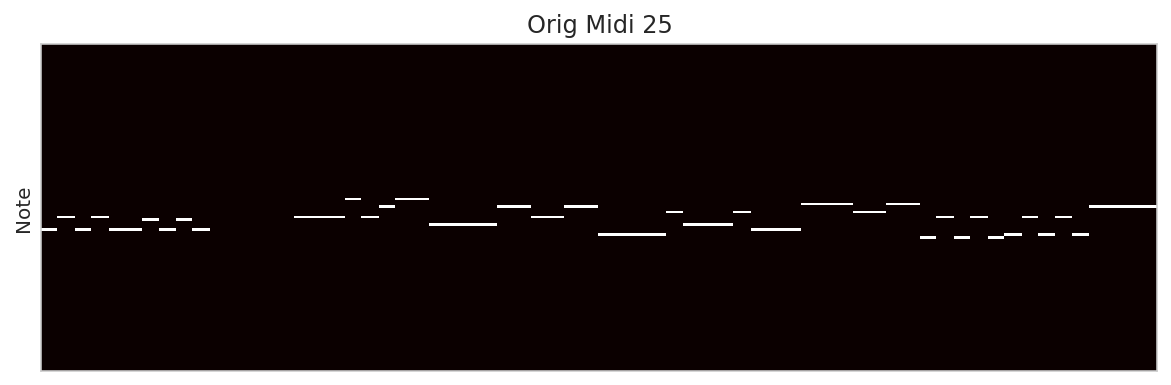

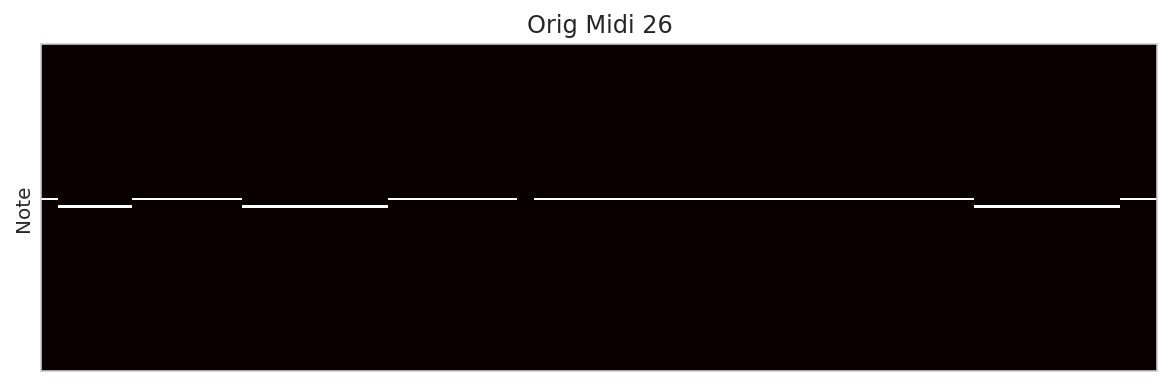

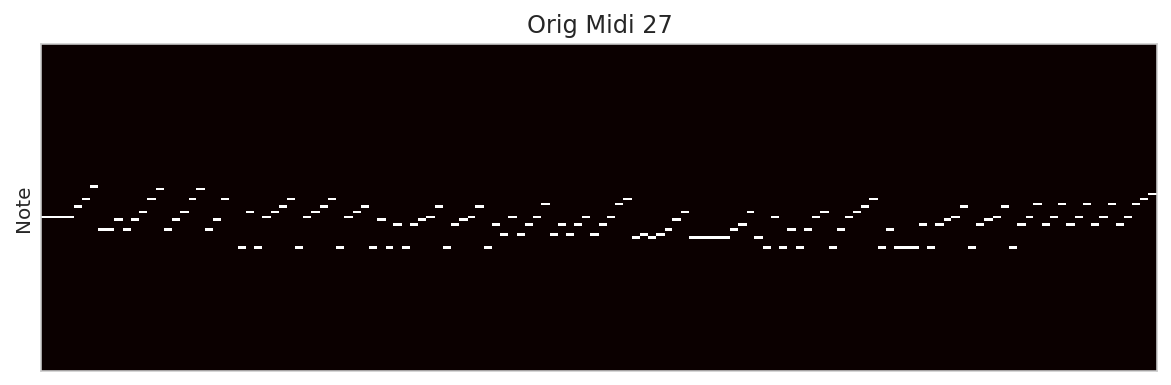

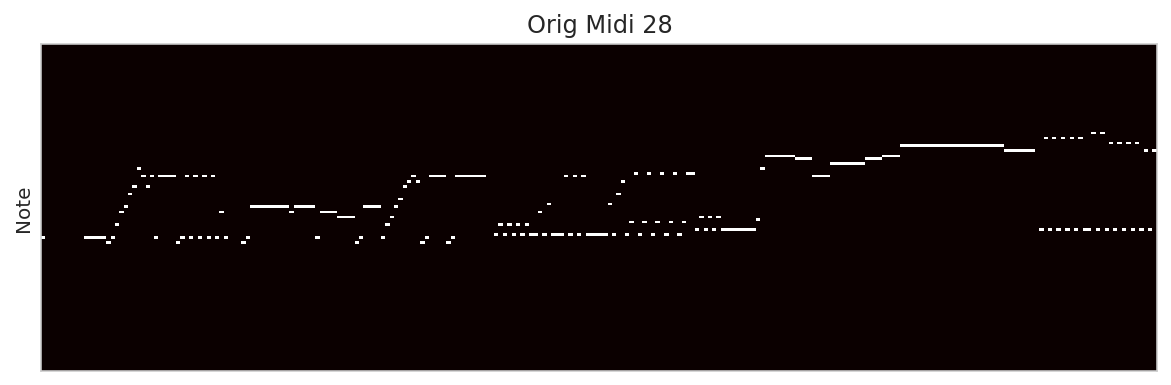

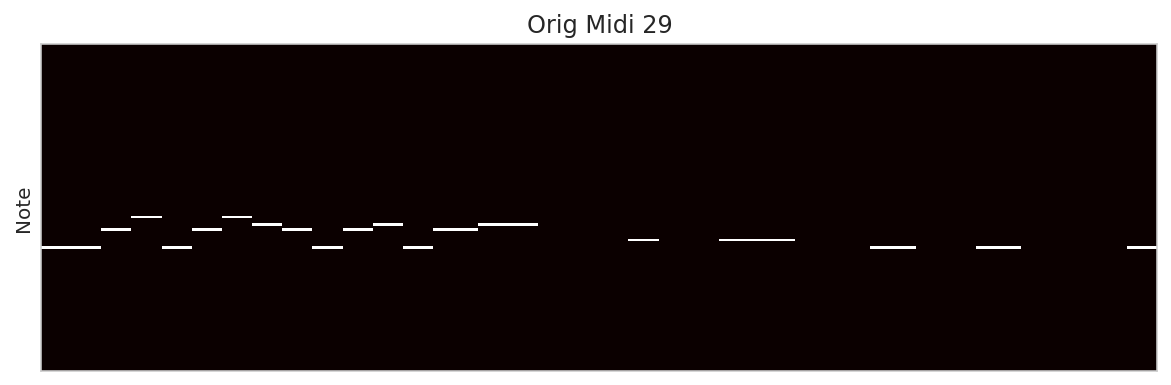

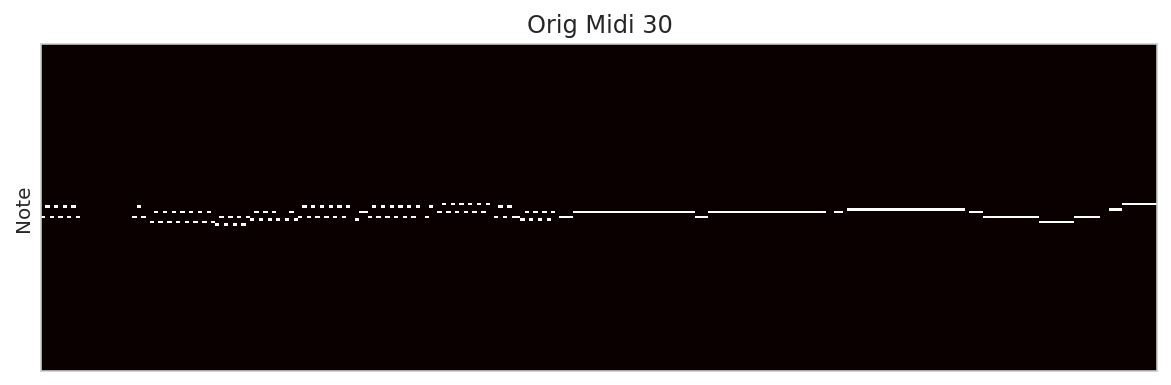

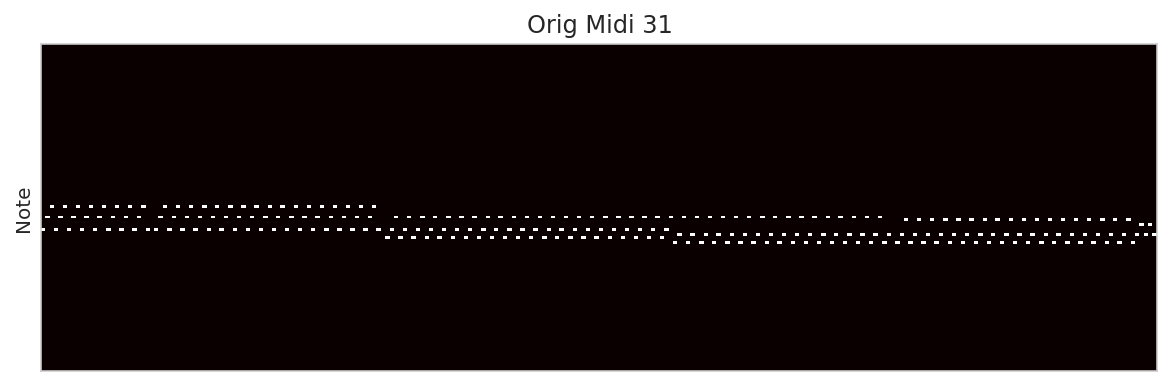

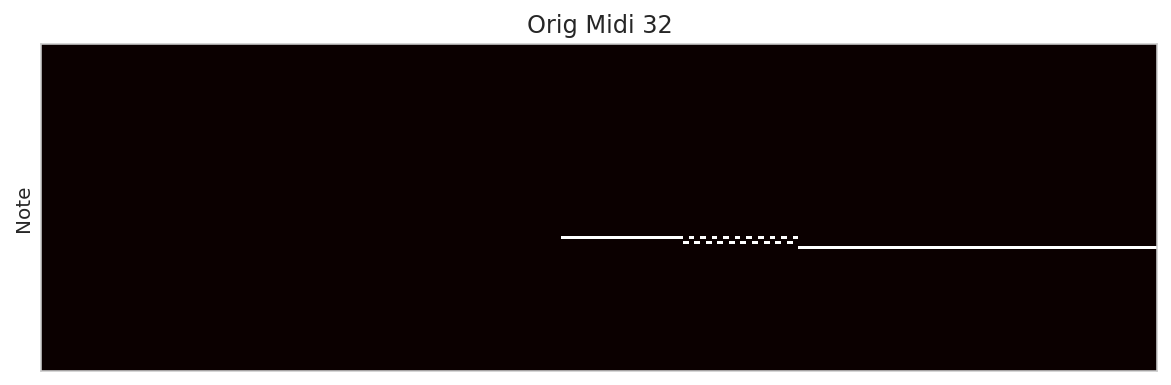

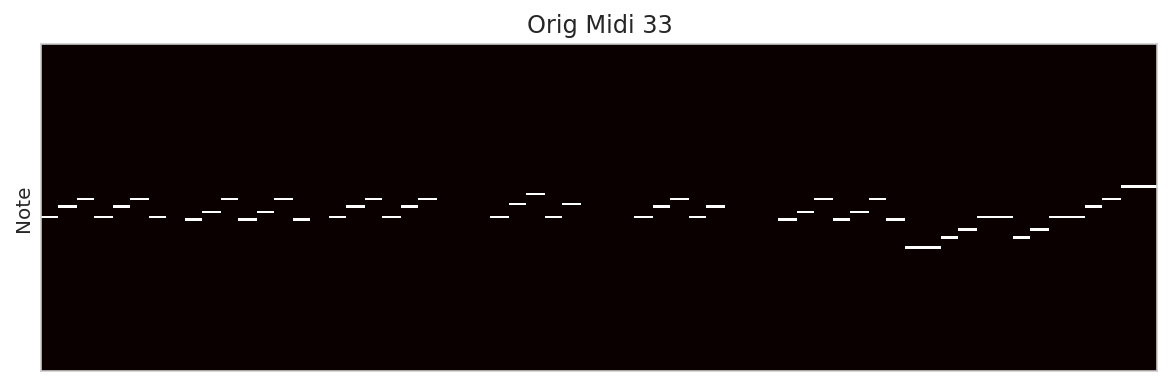

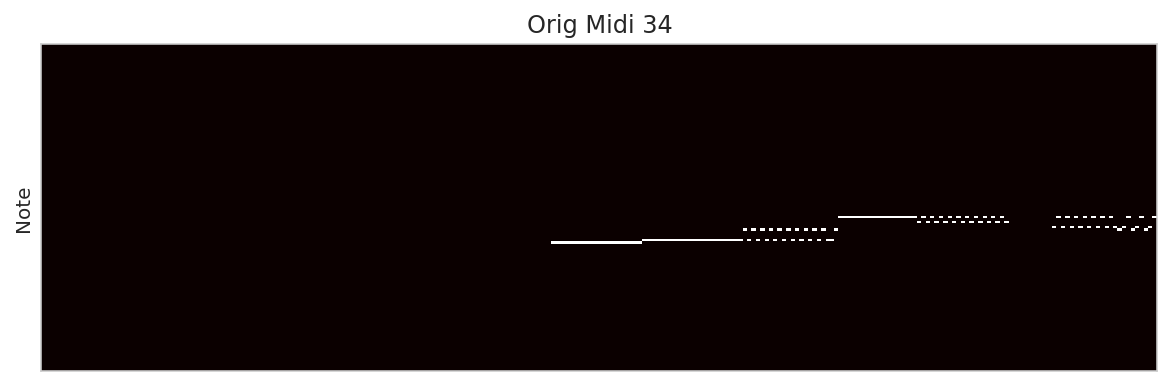

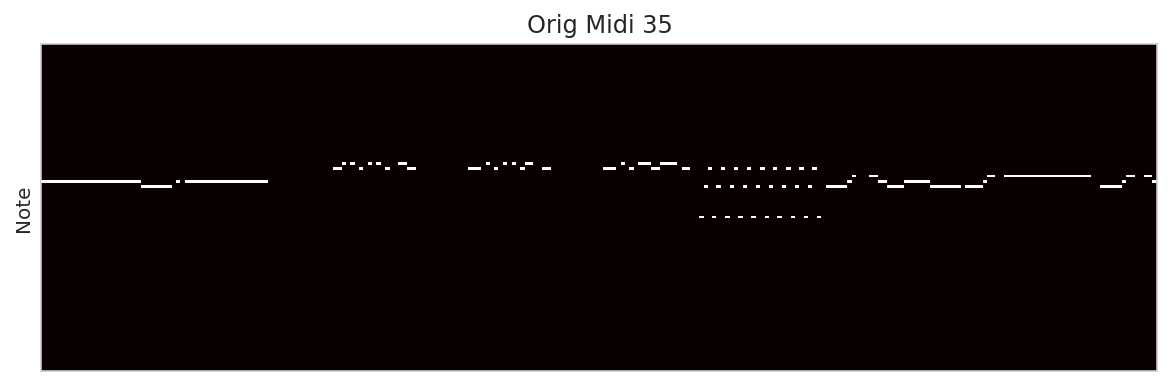

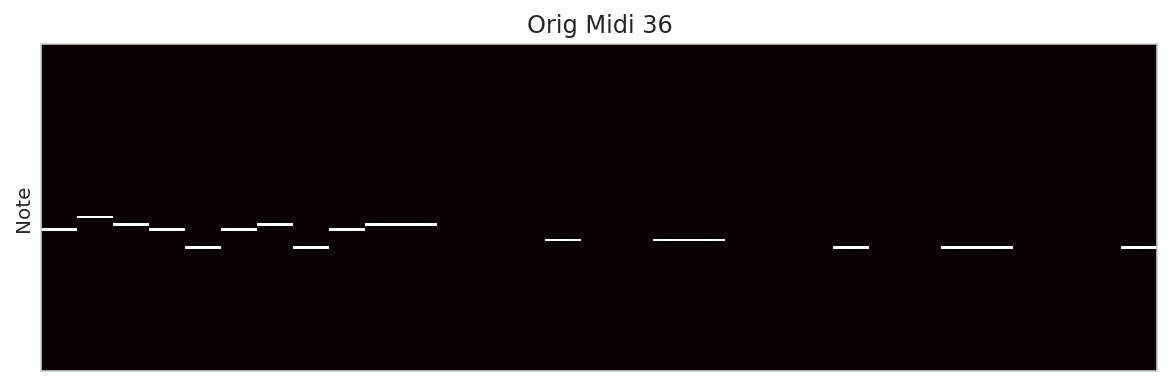

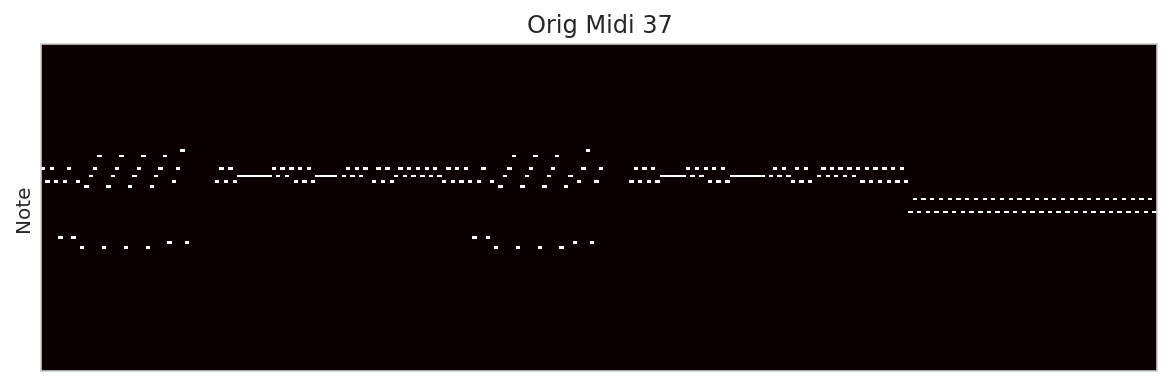

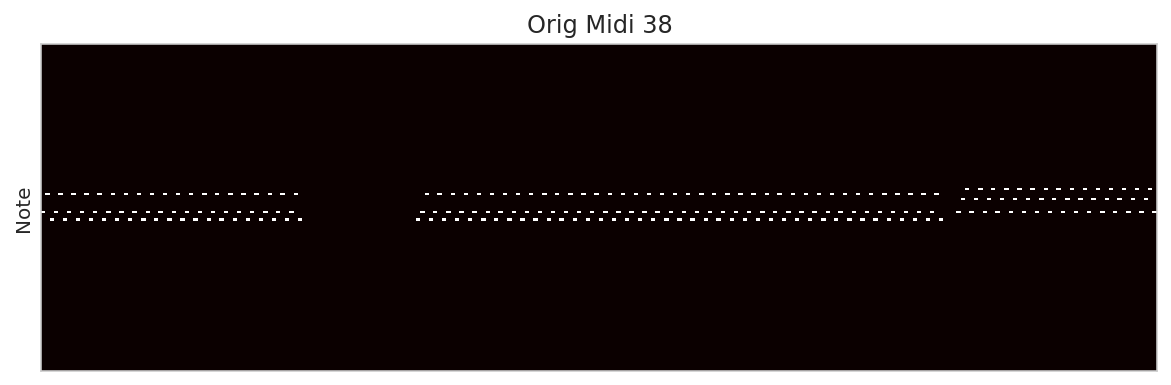

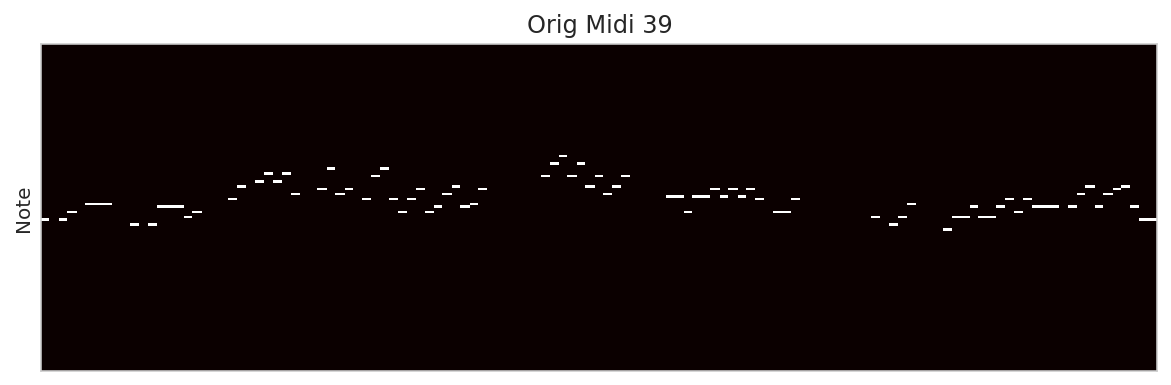

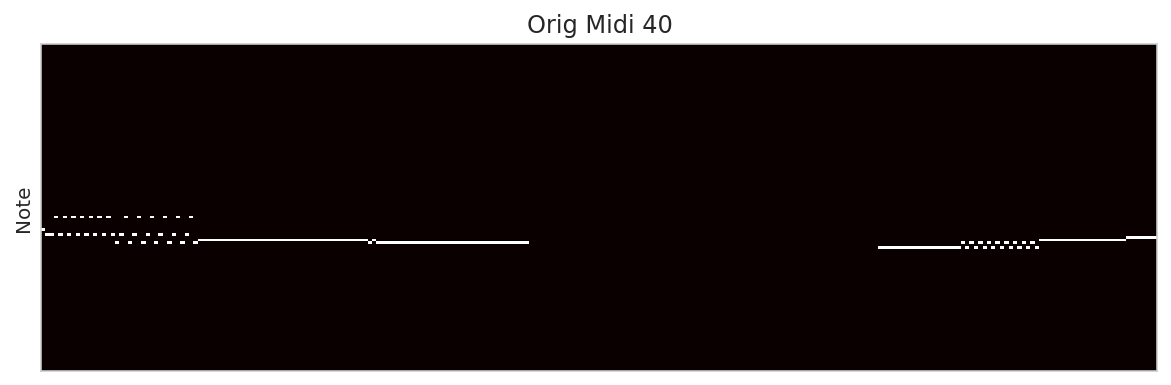

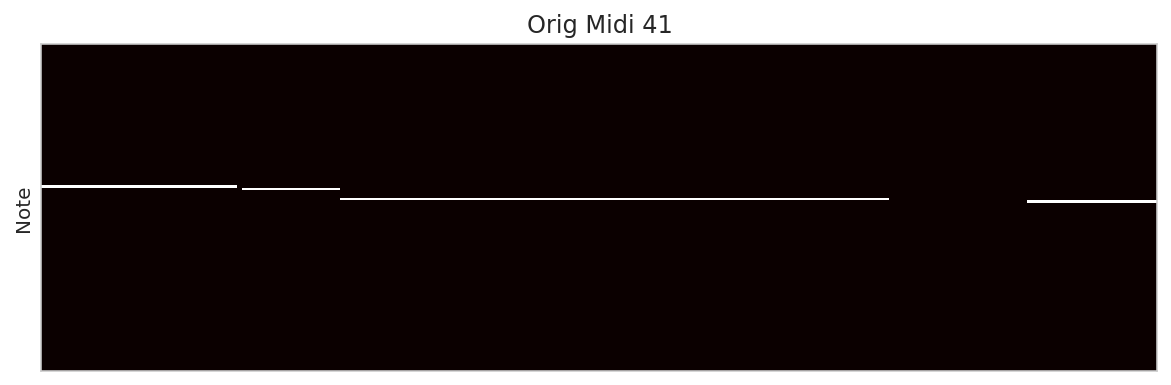

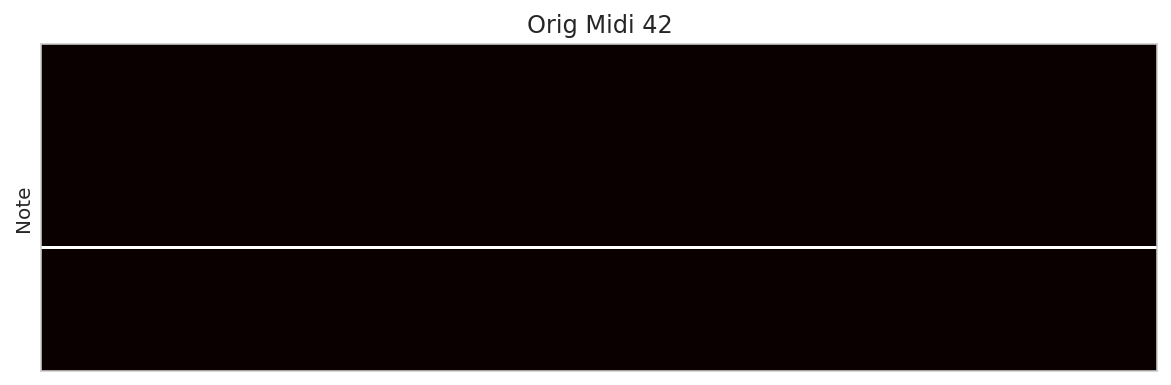

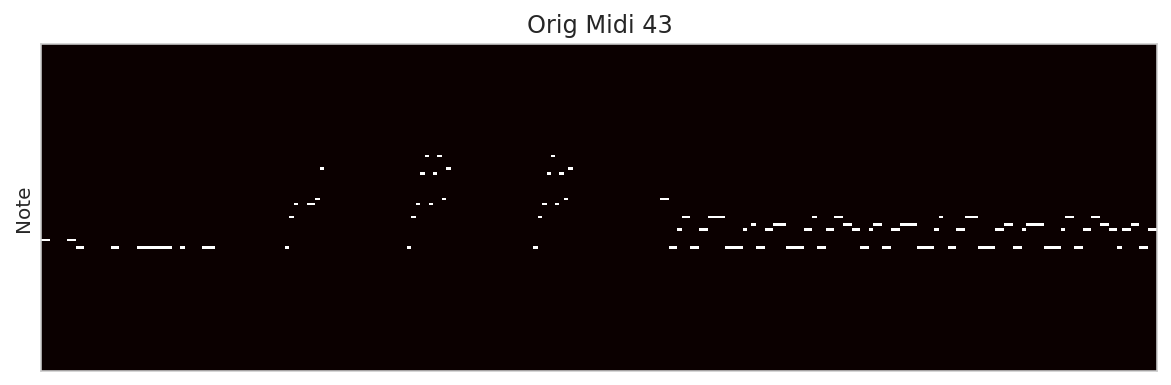

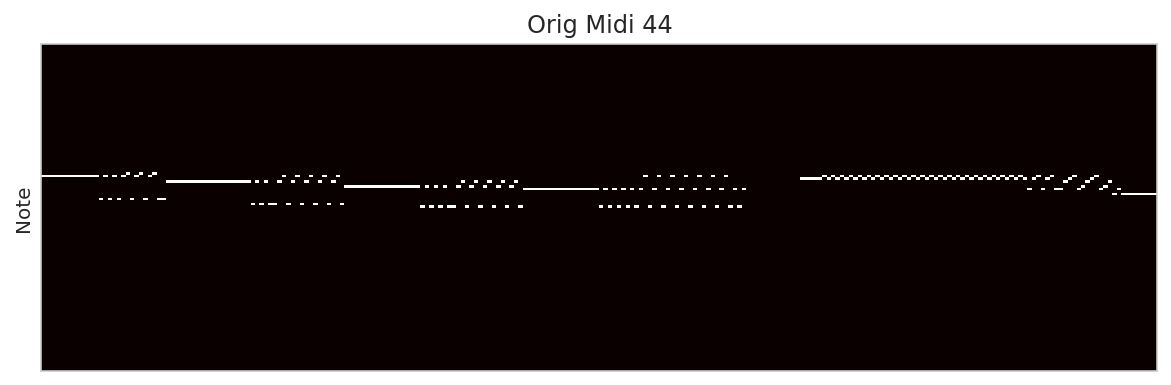

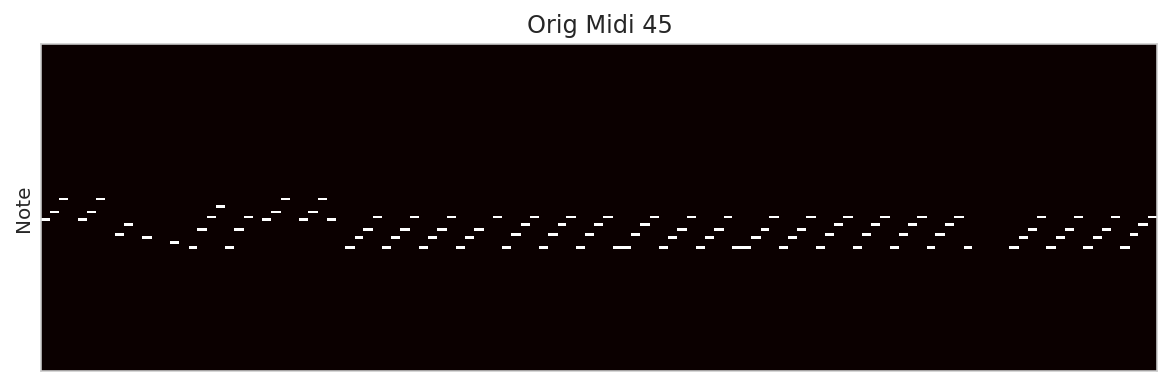

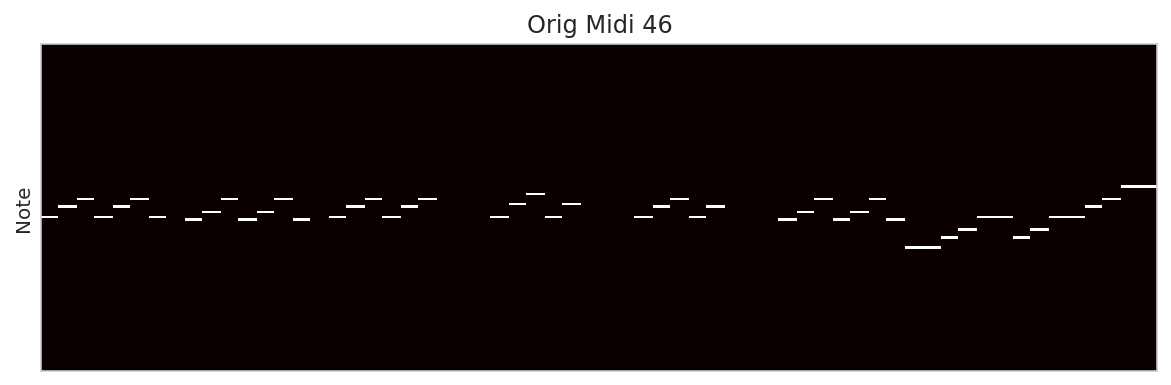

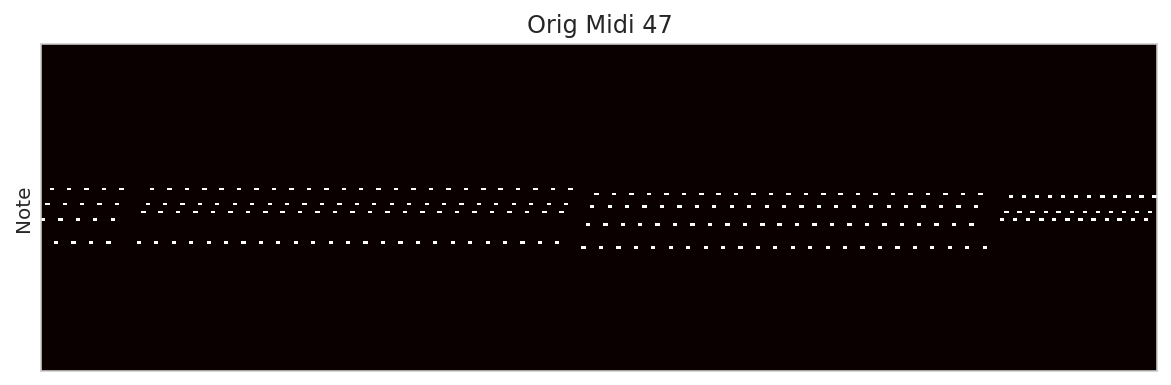

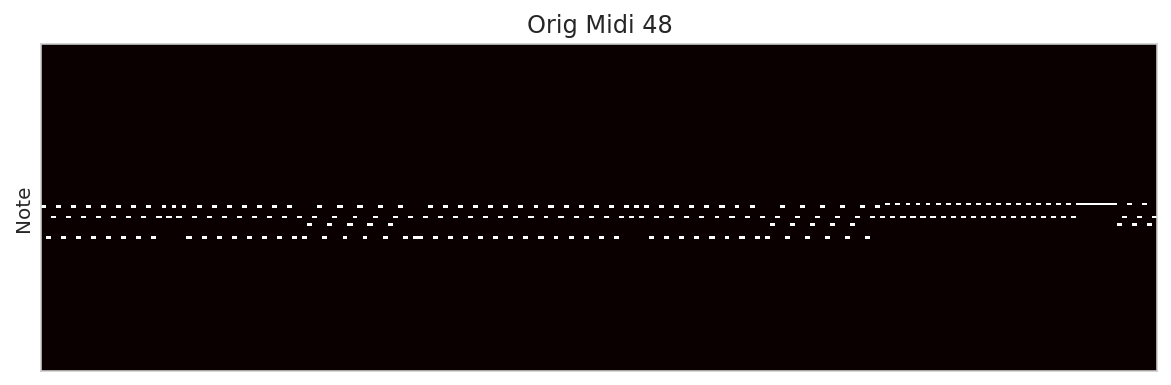

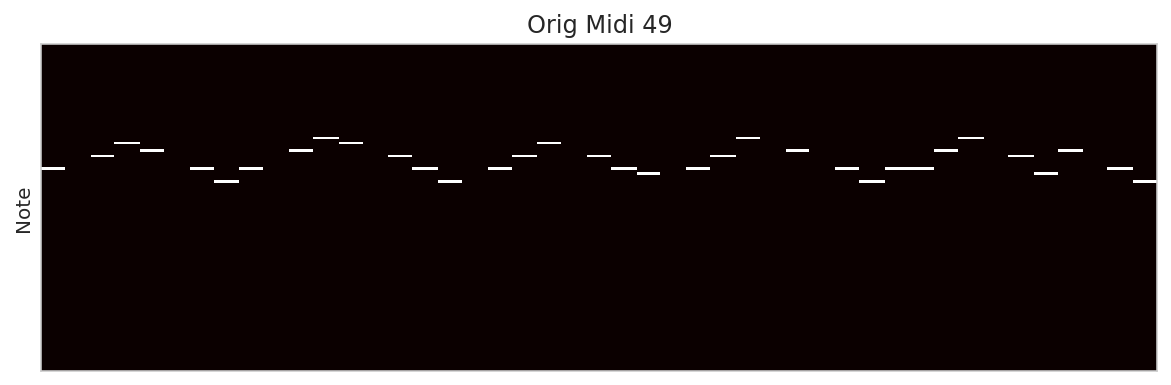

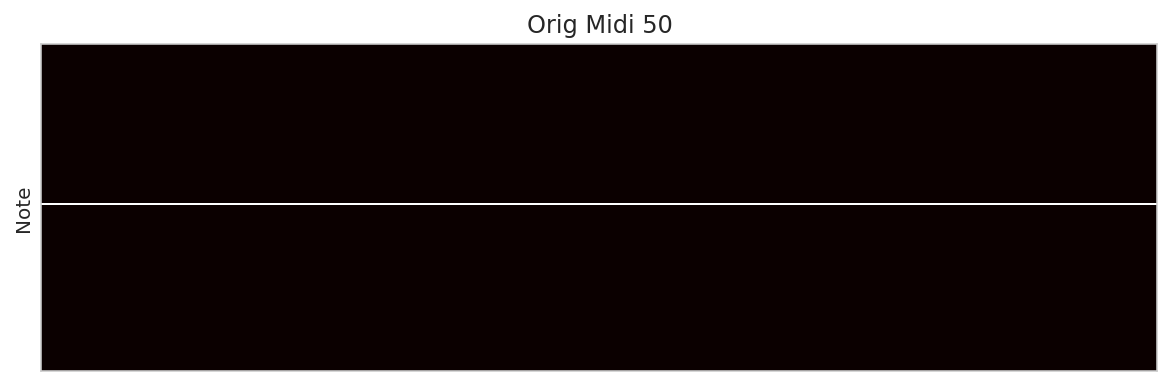

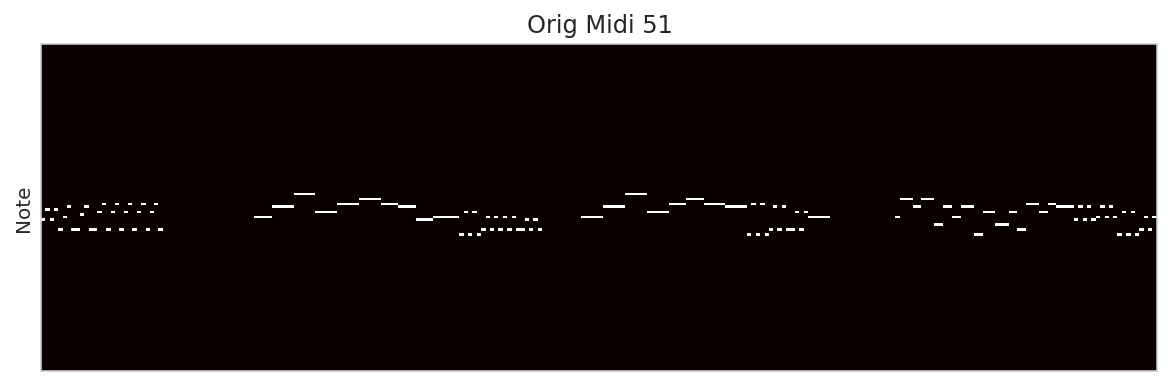

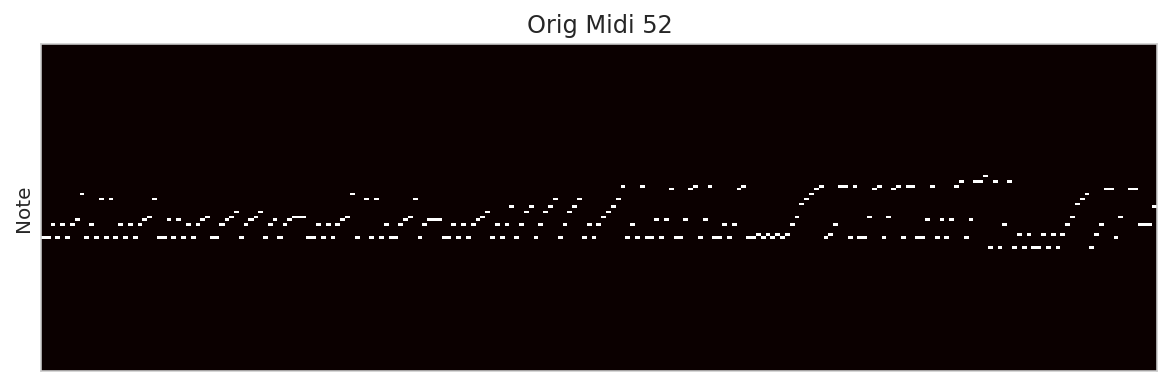

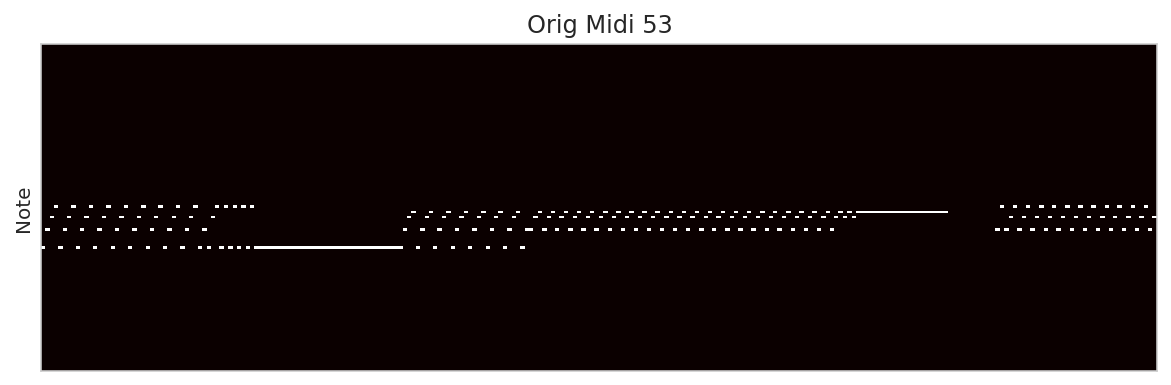

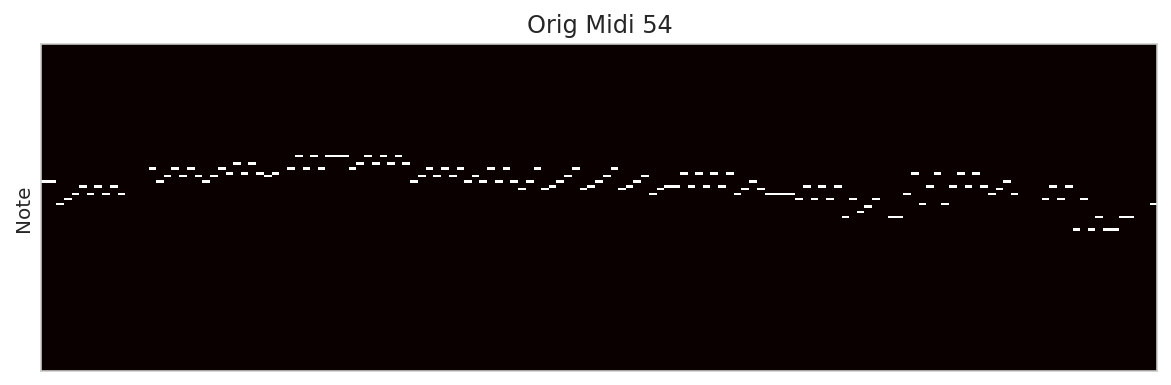

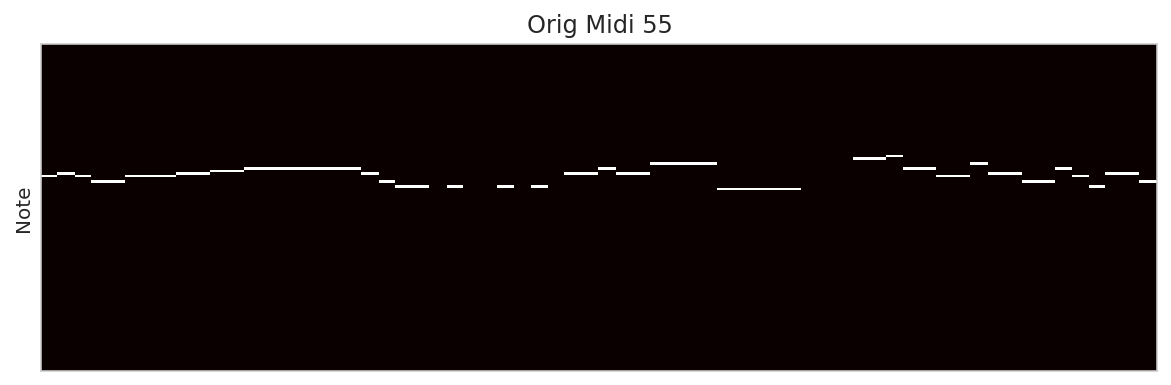

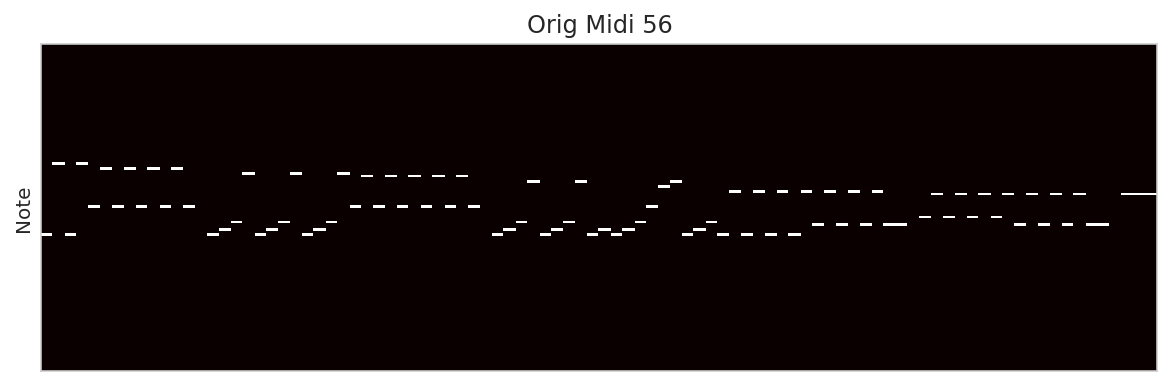

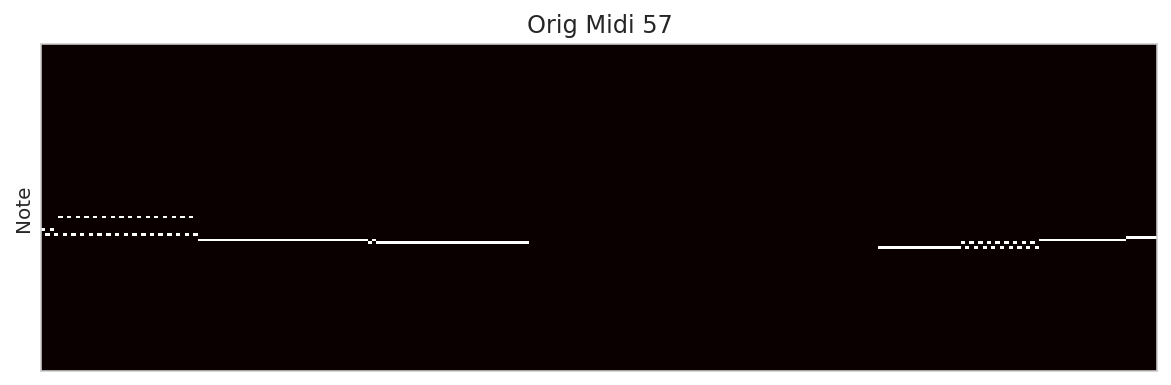

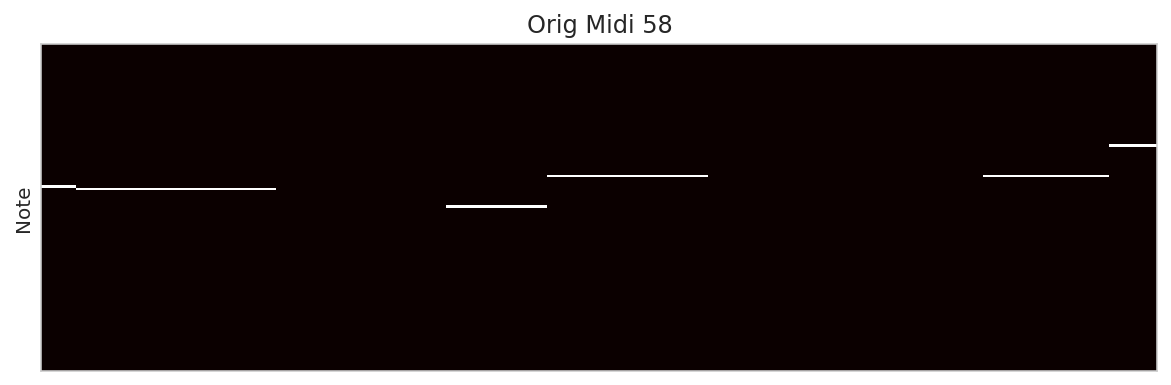

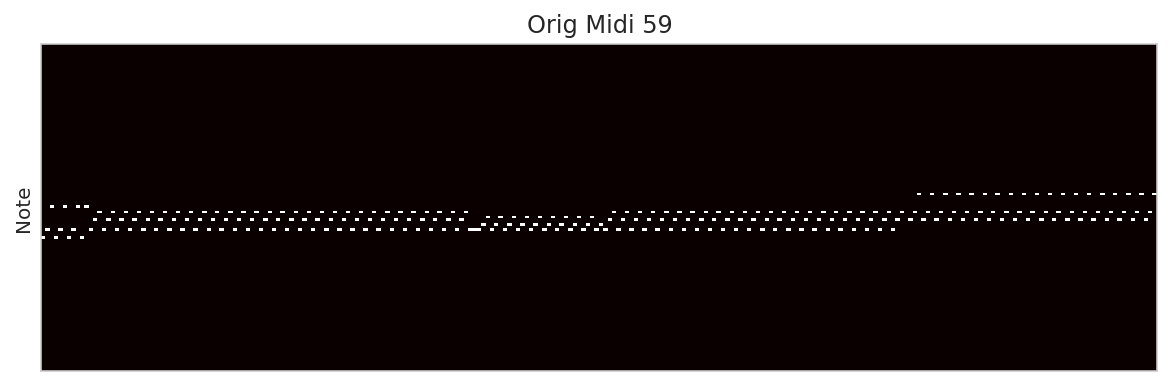

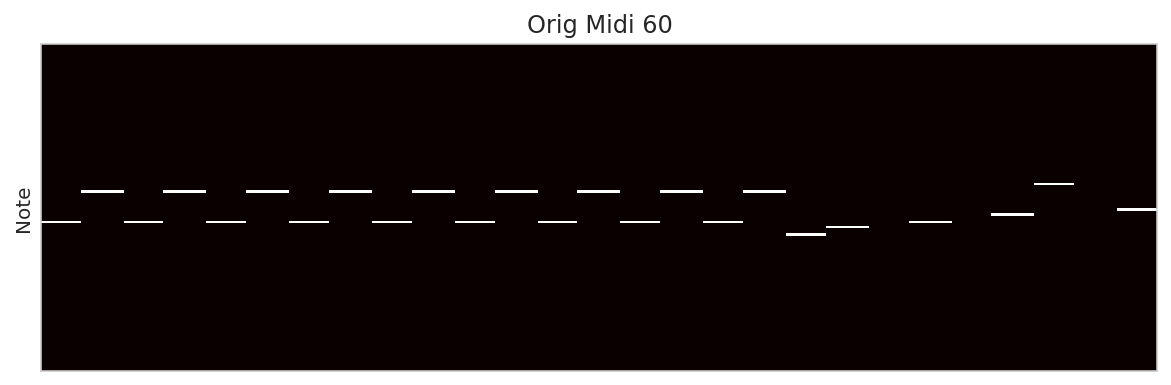

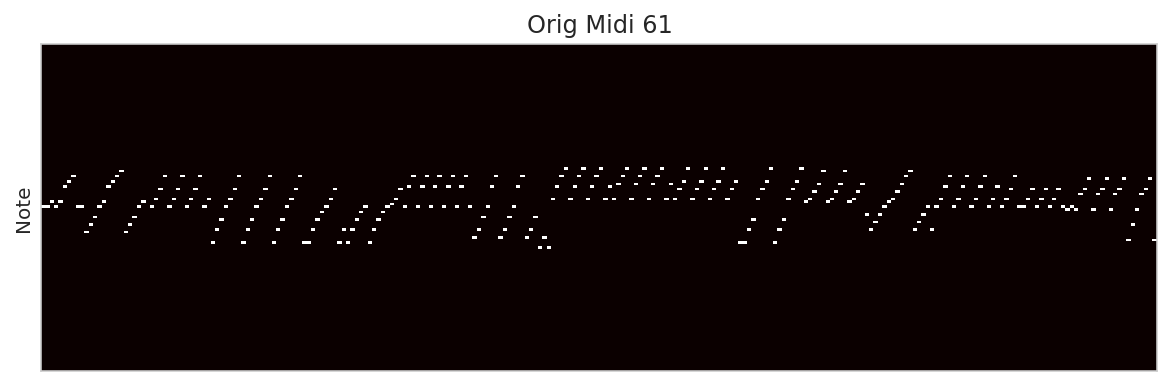

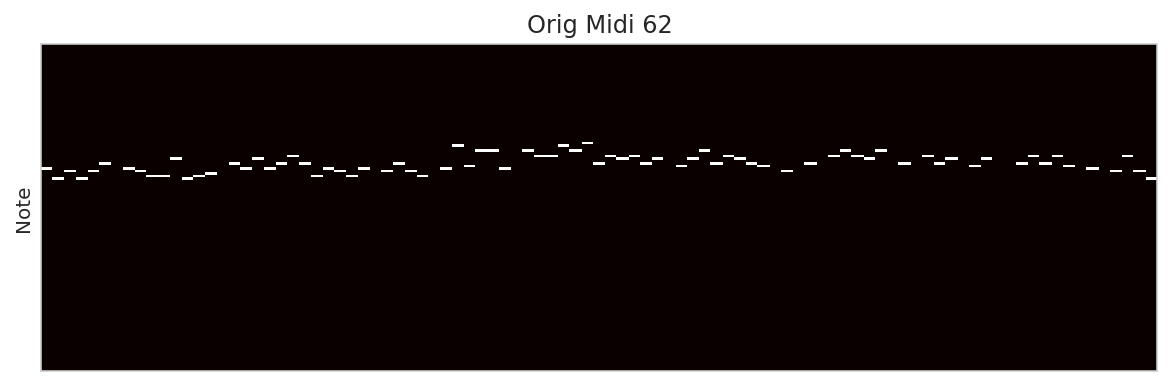

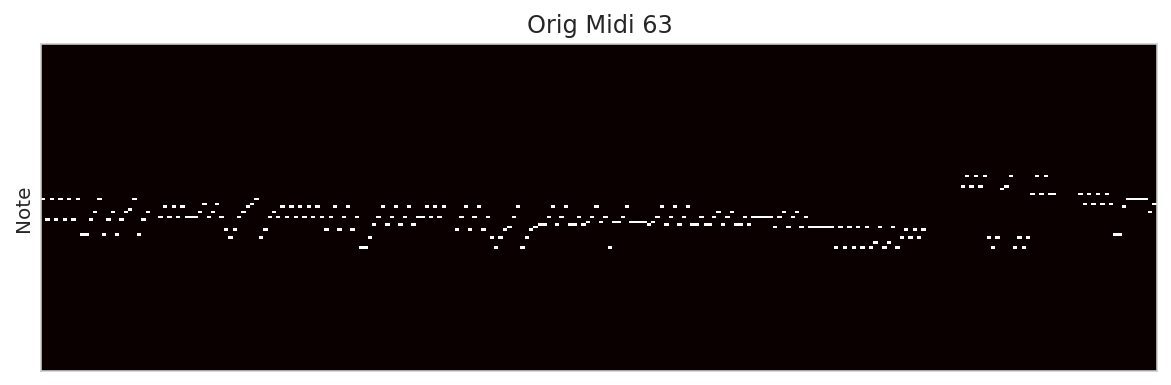

In [26]:
# showing originals
# -----------------
x_np = x.detach().numpy()
x_np.shape
for i, seq in enumerate(x_np):
    midi_out = seq
    if np.all(midi_out[:,-1]):
        print("Midi: {} is all silent".format(i))
        continue
    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Orig Midi {}".format(i))
    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_{}_orig.png".format(i))
    midi.write('midi/{}_orig.mid'.format(i))

## 4. Transition between melodies

### 4.1 Transitions

*This study is the initial goal of this work : performing the continuous transition between two melodies. The task was harder than initially thought by the team and many constraints have been met so that less time than expected has been allocated to this task. It can be continued in later works. In the following cells,the aim is to make the transition between 10.mid an 20.mid. The first two melodies are plotted, and the loss and Kullback-Leibler are inspected so that we ensure out-of-scope non-standards melodies among the dataset are not being used. Three strategies to perform the transition are tried. The problem being that it is not as easy as it would be with the first presented image of MNIST dataset as we have a relation of order between the transforming melody : with the LSTM, it has to take into account past and future bar (group of 16 notes) to generate the audio. The strategy are thus more empirical and future work could be brung to it.*

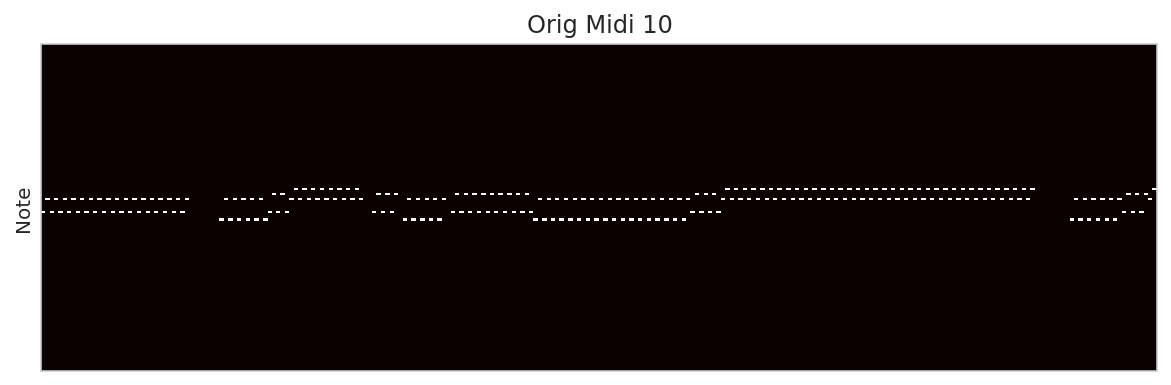

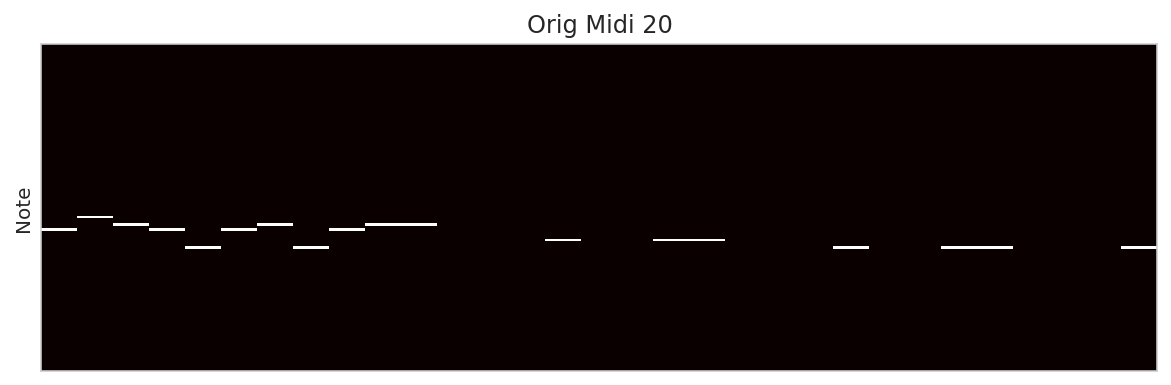

In [27]:
# x_np = x.detach().numpy() # first time only
x_np.shape
midi_out_2_melodies = []
for i, seq in enumerate(x_np):
    if i in [10,20]:  # mid_10_piano_roll and mid_20_piano_roll
        midi_out = seq
        midi_out_2_melodies.append(seq)
        if np.all(midi_out[:,-1]):
            print("Midi: {} is all silent".format(i))
            continue
        midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
        plt.figure(figsize=(10, 3))
        plt.title("Orig Midi {}".format(i))
        builder.plot_midi(midi)
        plt.savefig("midi/img_midi_{}_orig.png".format(i))
        midi.write('midi/{}_orig.mid'.format(i))    

In [28]:
x = midi_out_2_melodies
x = Variable(torch.Tensor(x))
if cuda:
    x = x.cuda()
outputs = net(x)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]
loss, kl,klw = loss_function(x_hat, x, mu, log_var,1)


print("loss", loss.cpu().detach().numpy())
print("kl  ", kl.cpu().detach().numpy())

loss 310.6593
kl   0.44976568


*At this point, the two latent layer $z_1$ and $z_2$ from the two melodies are computed. The problem is now to determine how the balance will be made along those two during the transition.* 
- *Strategy 3, implemented in the method MyDecoder3 is the easiest : as long as the model go forward in the melody, the weight of $z_1$ and $z_2$ is balanced linearly. The model thus have an evolving latent layer according to the two original melody. The issue with this strategy is that this layer $z$ is not being updated along the melody and remains the one of the two combined original melodies.* 
- *Strategy 1 works differently and performs better. $z$ is being replaced by $z_1$ as it is the song from which starts the transition. Profit is being made of the teacher_forcing parameter by controlling the reconstruction with a weighted linear mix of original melodies that evolved along the melody : the reconstruction is performed and partially supervised by a transitional mix of the melodies, where the VAE would act as a smoother for this linear mixture.*
- *Strategy 2 is combination of the two previous ones and turns out to give the best results on average. We used allo along the sequence a mixed $z$ value (from a linear combination of $z_1,z_2$) and teacher forcing control is applied with an evolving linear mixture of the two original piano roll melodies : the latent variable is evolve and a control is applied. Again, the VAE can be seemed as a transition smoother for this linear combination of the original files.*

In [29]:
output1 = net.MyDecoder1(z, x)['x_hat']

In [30]:
output2 = net.MyDecoder2(z, x)['x_hat']

In [31]:
output3 = net.MyDecoder3(z)['x_hat']

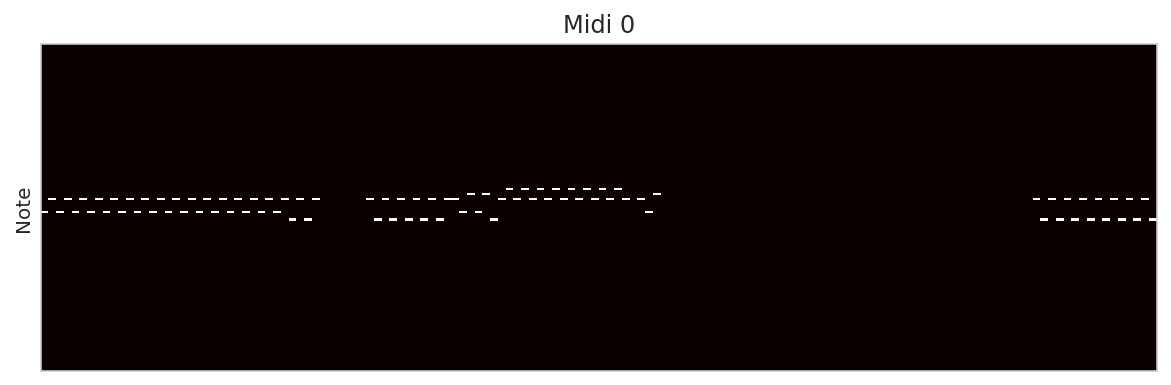

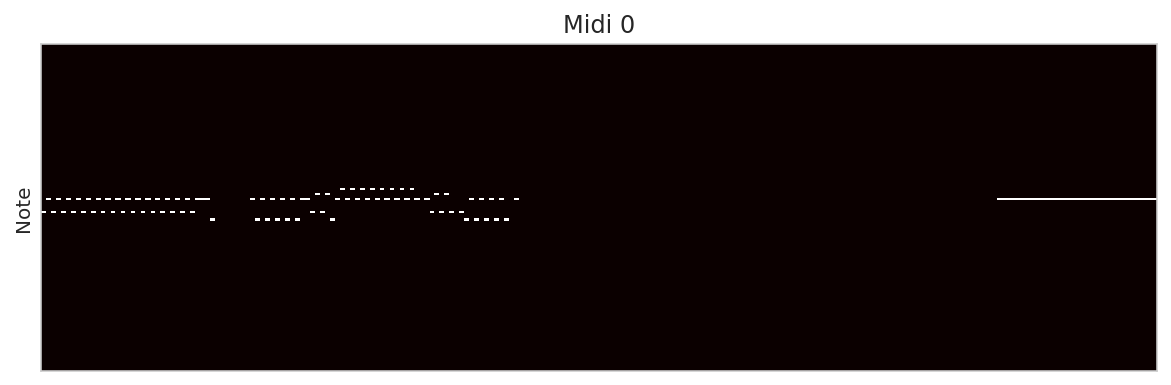

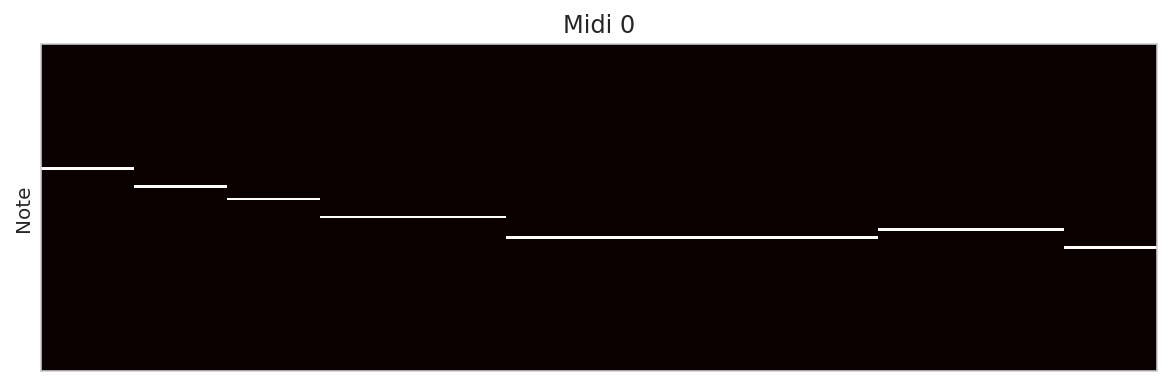

In [32]:
x_hat_np1 = output1.cpu().detach().numpy()
x_hat_np2 = output2.cpu().detach().numpy()
x_hat_np3 = output3.cpu().detach().numpy()

for i, seq in enumerate(x_hat_np1):
    row_maxes = seq.max(axis=1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    np.savetxt("midi/csv_midi_out_2_melodies_1_{}.csv".format(i), midi_out, delimiter=";")
    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Midi {}".format(i))
    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_2_melodies_1_{}.png".format(i))
    midi.write('midi/{}.mid'.format(i))

for i, seq in enumerate(x_hat_np2):
    row_maxes = seq.max(axis=1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    np.savetxt("midi/csv_midi_out_2_melodies_2_{}.csv".format(i), midi_out, delimiter=";")
    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Midi {}".format(i))
    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_2_melodies_2_{}.png".format(i))
    midi.write('midi/{}.mid'.format(i))

for i, seq in enumerate(x_hat_np3):
    row_maxes = seq.max(axis=1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    np.savetxt("midi/csv_midi_out_2_melodies_3_{}.csv".format(i), midi_out, delimiter=";")
    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Midi {}".format(i))
    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_2_melodies_3_{}.png".format(i))
    midi.write('midi/{}.mid'.format(i))

### 4.2 Generate from the latent space

*As a bonus, this section is let to show how the autoencoder is able to generate a melody. To do that, the latent layer $z$ is being fed with a random normal distribution along its features and print its out. The ouput audio show look and hear like some song of the dataet.*

In [30]:
gen_batch = 10
z_gen = torch.randn(gen_batch, 256, 32).cuda()

# Sample from latent space
h_gen,c_gen,hconductor_gen,cconductor_gen = net.init_hidden(gen_batch)
conductor_hidden_gen = (hconductor_gen,cconductor_gen)
notes_gen = torch.zeros(gen_batch,TOTAL_NOTES,NUM_PITCHES,device=device)

# For the first timestep the note is the embedding
note_gen = torch.zeros(gen_batch, 1 , NUM_PITCHES,device=device)
decoder_hidden_gen = (torch.randn(1,gen_batch, decoders_initial_size,device=device), torch.randn(1,gen_batch, decoders_initial_size,device=device))
counter=0

for i in range(totalbars):
    decoder_hidden_gen = (torch.randn(1,gen_batch, decoders_initial_size,device=device), torch.randn(1,gen_batch, decoders_initial_size,device=device))
    embedding_gen, conductor_hidden_gen = net.conductor(z_gen[:,i,:].view(gen_batch,1, -1), conductor_hidden_gen)
    
    for _ in range(sequence_length):
        # Concat embedding with previous note
        e_gen = torch.cat([embedding_gen, note_gen], dim=-1)
        e_gen = e_gen.view(gen_batch, 1, -1)
        # Generate a single note (for each batch)
        note_gen, decoder_hidden_gen = net.decoder(e_gen, decoder_hidden_gen)
        aux_gen = net.linear(note_gen)
        aux_gen=torch.softmax(aux_gen, dim=2);
        #notes_gen[:,range(i*16,i*16+16),:]=aux_gen;
        notes_gen[:,counter,:]=aux_gen.squeeze();
        note_gen=aux_gen
        counter = counter+1

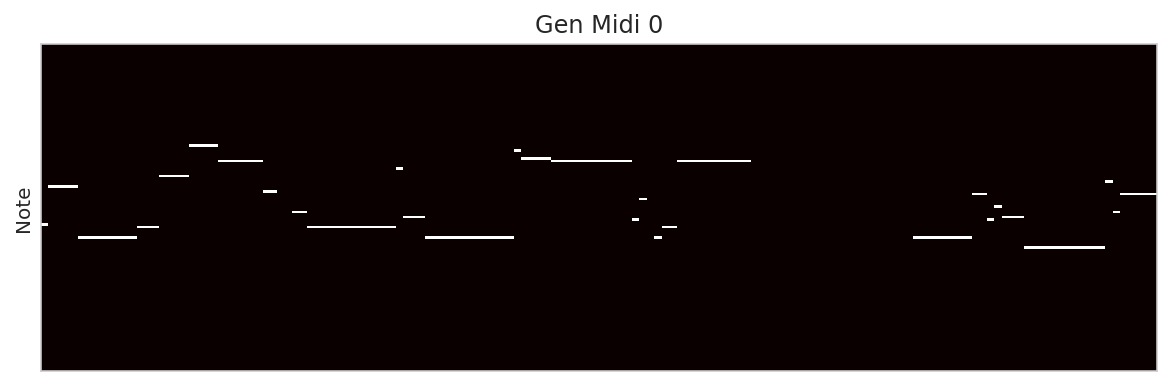

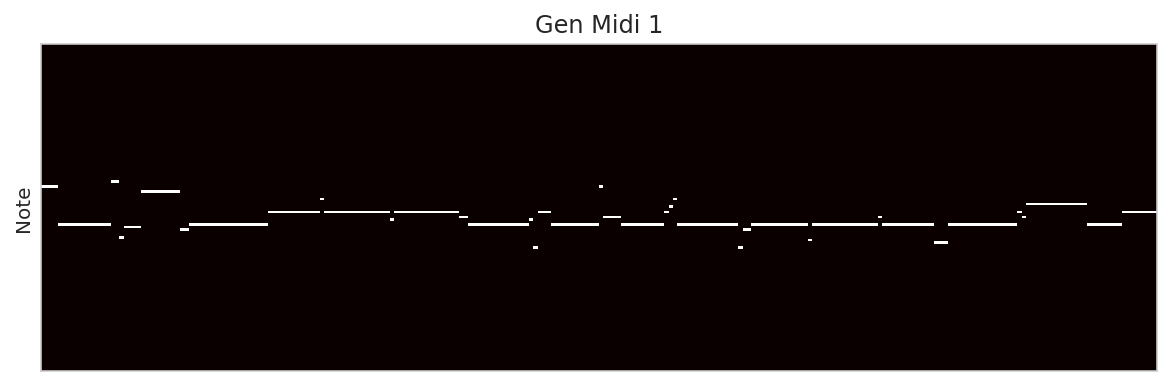

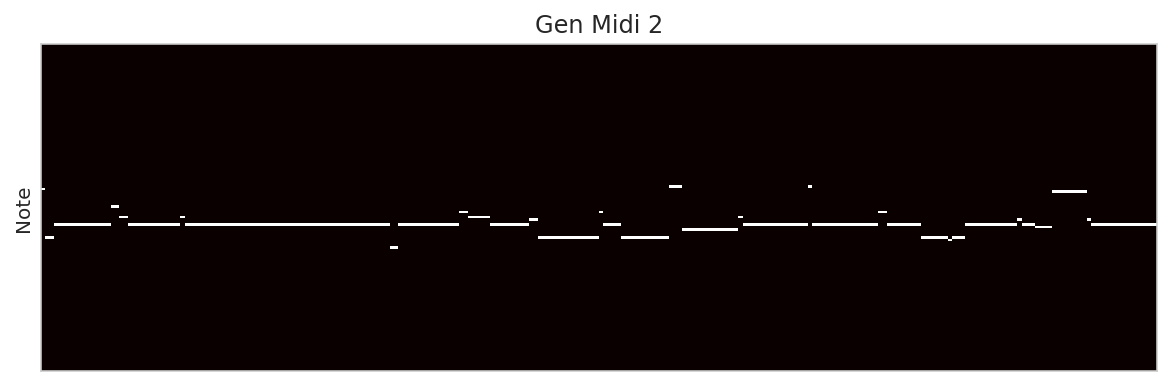

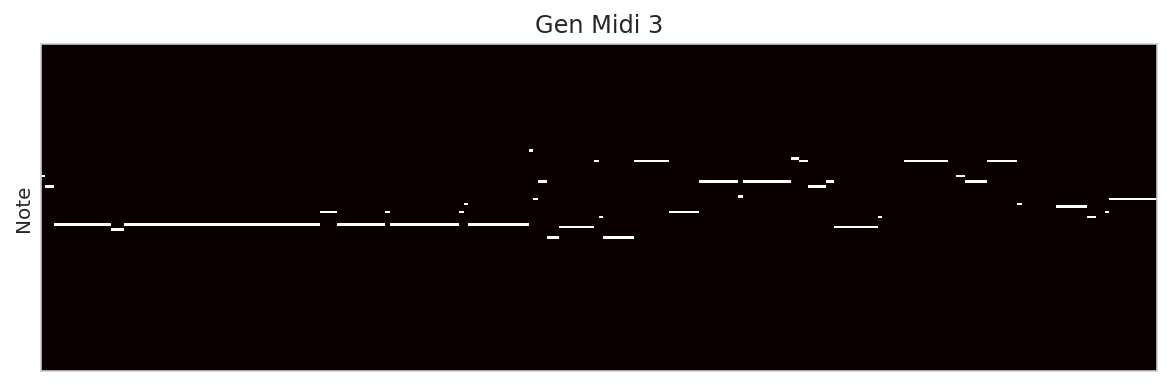

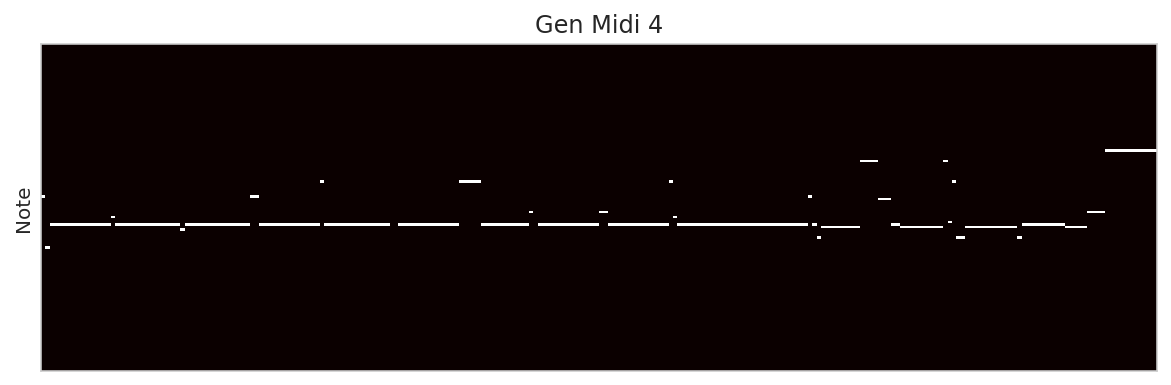

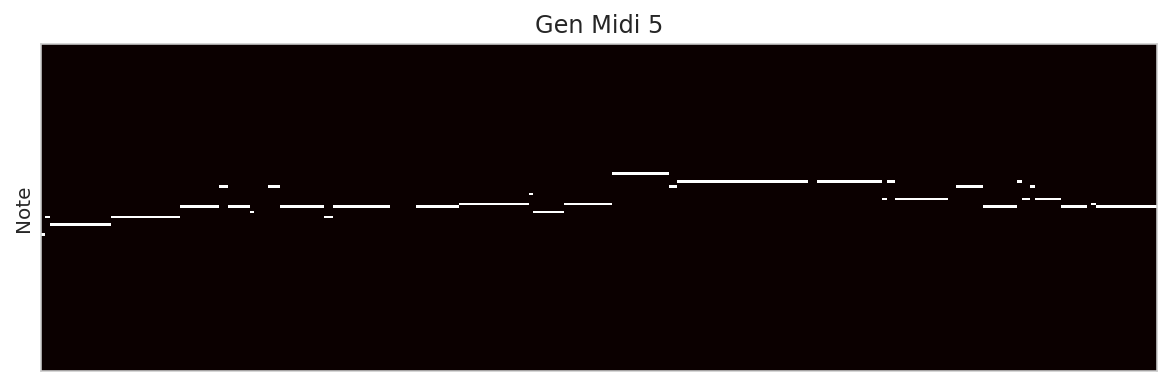

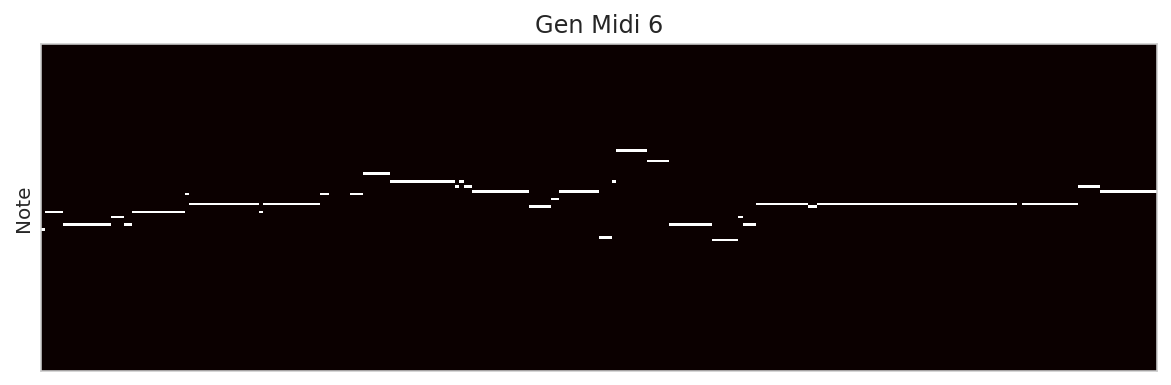

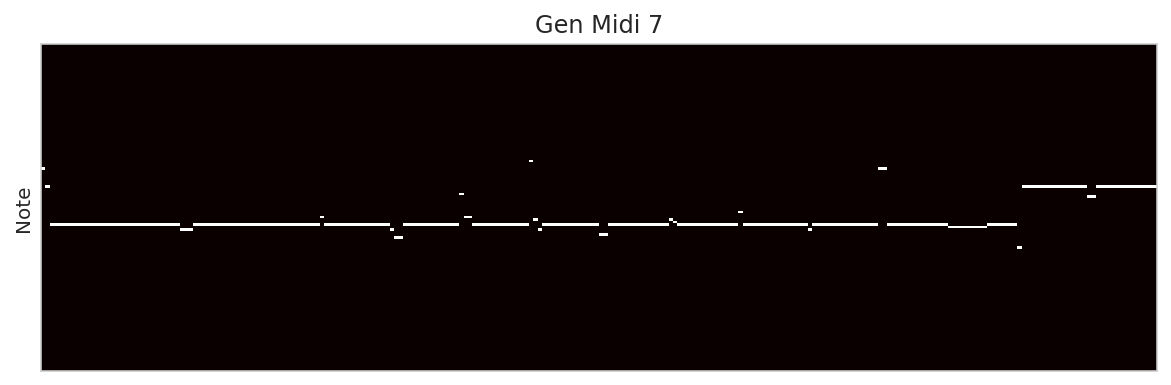

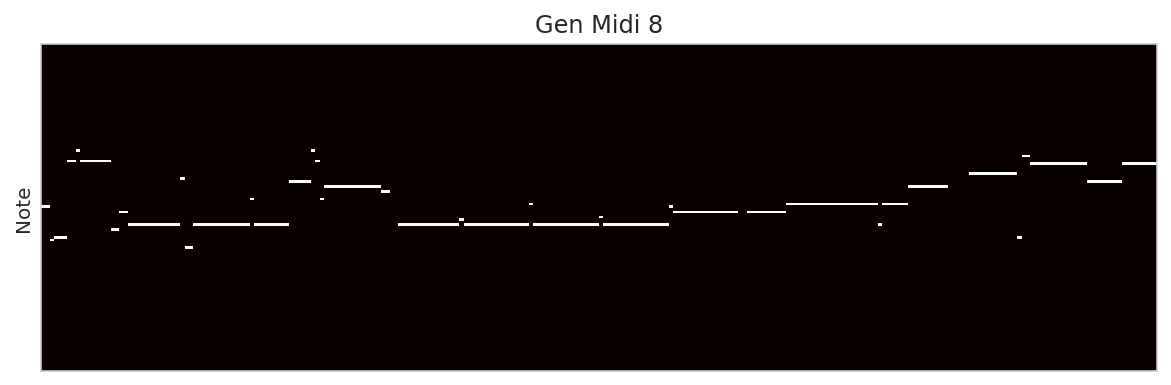

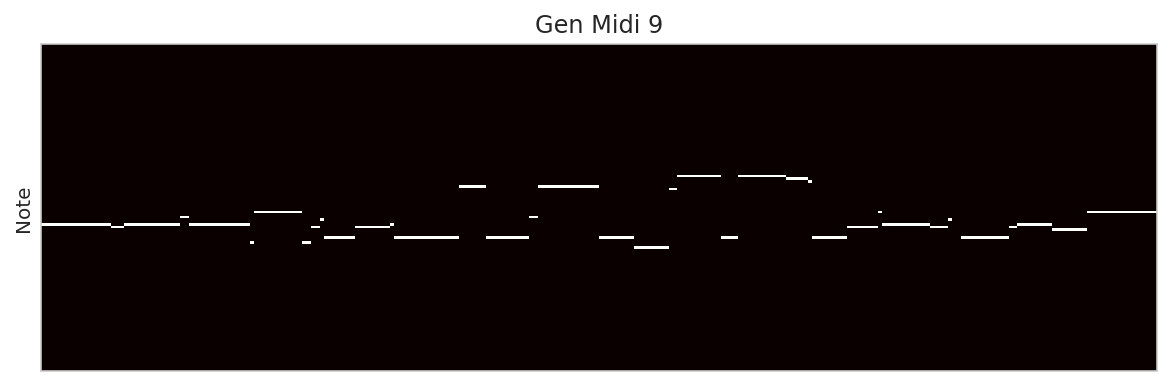

In [31]:
notes_np = notes_gen.cpu().detach().numpy()
notes_np.shape
for i, seq in enumerate(notes_np):
    row_maxes = seq.max(axis=1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    if np.all(midi_out[:,-1]):
        print("Midi: {} is all silent".format(i))
        continue
    np.savetxt("midi/gen_csv_midi_out_{}.csv".format(i), midi_out, delimiter=";")
    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Gen Midi {}".format(i))
    builder.plot_midi(midi)
    plt.savefig("midi/gen_img_midi_{}.png".format(i))
    midi.write('midi/gen_{}.mid'.format(i))